In [1]:
!pip install bayesian-optimization

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
# !cp -r /content/drive/MyDrive/hack4retail/* .

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd



import numpy as np
from datetime import timedelta, datetime
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta, datetime
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
tqdm.pandas()

pd.options.display.max_columns = 99
pd.options.display.max_rows = 99

In [5]:
# !unzip test_data.csv.zip -d .

In [6]:
# !unzip Train.zip

In [7]:
%cd /content/

/content


In [8]:

sku_final = pd.read_csv('sku_final.csv')
geo_params = pd.read_csv('geo_params.csv')
train_data = pd.read_csv('train_final.csv', parse_dates=['date'])

test_data = pd.read_csv('test_data.csv', parse_dates=['date'])
sample_submission = pd.read_csv('sample_final.csv')

In [9]:
len(test_data['SKU'].unique())

1961

In [10]:
len(train_data['SKU'].unique())

1925

In [11]:
len(list(set(train_data['SKU'])^set(test_data['SKU'])))

36

In [12]:
last_2_weeks = train_data[train_data.date > pd.datetime(2021,7,4)]
before_last_2_weeks = train_data[train_data.date < pd.datetime(2021,7,4)]

In [13]:
len(list(set(last_2_weeks['SKU'])^set(before_last_2_weeks['SKU'])))

71

In [14]:
new_items_las2weeks = list(set(last_2_weeks['SKU'])^set(before_last_2_weeks['SKU']))

In [15]:
train_data[train_data['SKU'] == new_items_las2weeks[27]]

,ID,geoCluster,SKU,date,price,sales
18828825,RR46785272,2022,846907,2021-07-08,417.59,0.5
18828826,RR46785273,2022,846907,2021-07-09,NaN,NaN
18828827,RR46785274,2022,846907,2021-07-10,NaN,NaN
18828828,RR46785275,2022,846907,2021-07-11,NaN,NaN
18828829,RR46785276,2022,846907,2021-07-12,NaN,NaN
18828830,RR46785277,2022,846907,2021-07-13,NaN,NaN
18828831,RR46785278,2022,846907,2021-07-14,NaN,NaN
18828832,RR46785279,2022,846907,2021-07-15,NaN,NaN
18828833,RR46785280,2022,846907,2021-07-16,NaN,NaN
18828834,RR46785281,2022,846907,2021-07-17,NaN,NaN


In [16]:
plot_new_item = train_data[train_data['SKU'] == new_items_las2weeks[1]].fillna(0)

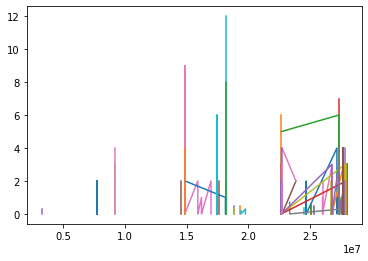

In [17]:
for item in new_items_las2weeks:
  plot_new_item = train_data[train_data['SKU'] == item].fillna(0)
  plot_new_item['sales'].plot()

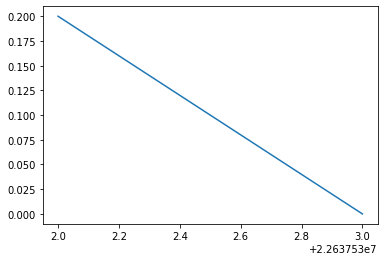

In [18]:
plot_new_item = train_data[train_data['SKU'] == new_items_las2weeks[19]].fillna(0)
plot_new_item['sales'].plot()

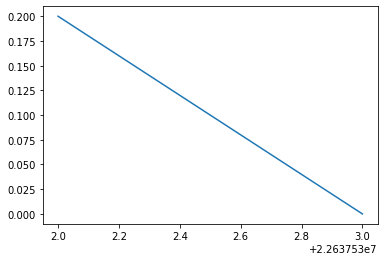

In [19]:
plot_new_item['sales'].plot()

In [20]:
train_data.sales = train_data.sales.fillna(0)

In [21]:
test_data['unqiue_id'] = test_data['geoCluster'].astype(str) + '_' + test_data['SKU'].astype(str)
train_data['unqiue_id'] = train_data['geoCluster'].astype(str) + '_' + train_data['SKU'].astype(str)

In [22]:
date_filter_for_sales = train_data[train_data.date > pd.datetime(2021,7,2)]
date_filter_for_sales2 = train_data[(train_data.date <= pd.datetime(2021,7,2)) & (train_data.date > pd.datetime(2021,6,18))]
date_filter_for_amount = train_data[train_data.date > pd.datetime(2021,6,2)]

In [23]:
date_filter_for_sales.sales.sum(), date_filter_for_sales2.sales.sum()

(373514.0650000001, 300945.3130000001)

In [24]:
date_filter_for_amount['is_zero'] = date_filter_for_amount.sales == 0

In [25]:
date_filter_for_amount

,ID,geoCluster,SKU,date,price,sales,unqiue_id,is_zero
0,RR27956447,21,32485,2021-07-08,39.69,0.9,21_32485,False
1,RR27956448,21,32485,2021-07-09,NaN,0.0,21_32485,True
2,RR27956449,21,32485,2021-07-10,NaN,0.0,21_32485,True
3,RR27956450,21,32485,2021-07-11,NaN,0.0,21_32485,True
4,RR27956451,21,32485,2021-07-12,NaN,0.0,21_32485,True
...,...,...,...,...,...,...,...,...
27956440,RR55912887,3230,841486,2021-07-15,NaN,0.0,3230_841486,True
27956441,RR55912888,3230,841486,2021-07-16,NaN,0.0,3230_841486,True
27956442,RR55912889,3230,841486,2021-07-17,NaN,0.0,3230_841486,True
27956443,RR55912890,3230,841486,2021-07-18,NaN,0.0,3230_841486,True


In [26]:
date_filter_for_amount = date_filter_for_amount.groupby('unqiue_id').agg({ 'is_zero':'sum', 'geoCluster':'count', 'sales':'sum'})

In [27]:
date_filter_for_amount

,is_zero,geoCluster,sales
unqiue_id,,,
112_16649,47,47,0.0
112_28205,47,47,0.0
112_32485,47,47,0.0
112_32550,46,47,2.2
112_674893,43,47,7.0
...,...,...,...
999_857554,2,3,2.0
999_857555,25,26,2.0
999_863583,11,12,2.0


In [28]:
len(date_filter_for_amount.sort_values('sales'))

115831

In [29]:
date_filter_for_amount = date_filter_for_amount.reset_index()

In [30]:
date_filter_for_sales[date_filter_for_sales.unqiue_id.isin(date_filter_for_amount[(date_filter_for_amount.is_zero < 20) & (date_filter_for_amount.geoCluster > 28)].unqiue_id)].sales.sum()

112203.41100000001

In [31]:
date_filter_for_sales2[date_filter_for_sales2.unqiue_id.isin(date_filter_for_amount[(date_filter_for_amount.is_zero < 20) & (date_filter_for_amount.geoCluster > 28)].unqiue_id)].sales.sum()

92456.15

In [32]:
zero_filter = date_filter_for_sales[date_filter_for_sales.unqiue_id.isin(date_filter_for_amount[(date_filter_for_amount.is_zero < 20) & (date_filter_for_amount.geoCluster > 28)].unqiue_id)]

In [33]:
zero_filter

,ID,geoCluster,SKU,date,price,sales,unqiue_id
8441,RR27964888,1321,32485,2021-07-03,38.29,3.0,1321_32485
8442,RR27964889,1321,32485,2021-07-04,38.29,5.0,1321_32485
8443,RR27964890,1321,32485,2021-07-05,38.29,1.5,1321_32485
8444,RR27964891,1321,32485,2021-07-06,39.69,2.0,1321_32485
8445,RR27964892,1321,32485,2021-07-07,39.69,2.0,1321_32485
...,...,...,...,...,...,...,...
27954380,RR55910827,3209,800506,2021-07-15,48.39,4.0,3209_800506
27954381,RR55910828,3209,800506,2021-07-16,48.39,5.0,3209_800506
27954382,RR55910829,3209,800506,2021-07-17,NaN,0.0,3209_800506
27954383,RR55910830,3209,800506,2021-07-18,NaN,0.0,3209_800506


In [34]:
zero_filter.unqiue_id.nunique()

1550

In [35]:
last_zeros = train_data[train_data.unqiue_id.isin(zero_filter.unqiue_id)].groupby('unqiue_id').progress_apply(lambda x: x.tail(6)).reset_index(drop=True)

100%|██████████| 1550/1550 [00:02<00:00, 690.23it/s] 


In [36]:
last_zeros['is_zero'] = last_zeros.sales == 0
last_zeros = last_zeros.groupby('unqiue_id').sum()['is_zero'].sort_values()

In [37]:
last_zeros = last_zeros[last_zeros < 4].reset_index()

In [38]:
last_zeros

,unqiue_id,is_zero
0,2149_32485,0
1,2358_224200,0
2,2358_219078,0
3,2043_736357,0
4,2344_32485,0
...,...,...
1453,2070_32546,3
1454,2117_32490,3
1455,2056_591899,3
1456,2252_787133,3


In [39]:
train_data_not_used = train_data[~train_data.unqiue_id.isin(last_zeros.unqiue_id)]

In [40]:
train_data = train_data[train_data.unqiue_id.isin(last_zeros.unqiue_id)]

In [41]:
test_data = test_data[test_data.unqiue_id.isin(last_zeros.unqiue_id)]

In [42]:
train_data.unqiue_id.nunique(), test_data.unqiue_id.nunique()

(1458, 1458)

In [43]:
# train_data = train_data[train_data.sales != 0]

In [44]:
train_data.unqiue_id.nunique(), test_data.unqiue_id.nunique()

(1458, 1458)

In [45]:
# map geo-city data
test_data = pd.merge(test_data, geo_params, on='geoCluster')
train_data = pd.merge(train_data, geo_params, on='geoCluster')

In [46]:
test_data['geo_city'] = test_data['geoCluster'].astype(str) + '_' + test_data['cityId'].astype(str)

In [47]:
train_data['geo_city'] = train_data['geoCluster'].astype(str) + '_' + train_data['cityId'].astype(str)

In [48]:
train_data['geo_city'].value_counts()

2001_0    14087
2043_0    13399
2023_0    12063
2049_0    11463
2077_0    11019
          ...  
2738_0       96
2616_0       95
2614_0       95
3163_0       70
2942_0       60
Name: geo_city, Length: 203, dtype: int64

In [49]:
train_data['geo_city'].isna().sum()

0

In [50]:
СITIES = train_data['geo_city'].unique()

In [51]:
СITIES

array(['1867_0', '1894_0', '1934_0', '1935_0', '1990_0', '1991_0',
       '1992_0', '1994_0', '1995_0', '1996_0', '1999_0', '2000_0',
       '2001_0', '2002_0', '2006_0', '2007_0', '2008_0', '2010_0',
       '2011_0', '2012_0', '2013_0', '2015_0', '2016_0', '2017_0',
       '2019_0', '2021_0', '2022_0', '2023_0', '2024_0', '2025_0',
       '2028_0', '2029_0', '2030_0', '2031_0', '2032_0', '2033_0',
       '2034_0', '2036_0', '2037_0', '2038_0', '2039_0', '2040_0',
       '2041_0', '2042_0', '2043_0', '2044_0', '2045_0', '2049_0',
       '2050_0', '2053_0', '2055_0', '2056_0', '2058_0', '2060_0',
       '2061_0', '2062_0', '2063_0', '2064_0', '2069_0', '2070_0',
       '2072_0', '2077_0', '2085_0', '2086_0', '2091_0', '2105_0',
       '2106_0', '2107_0', '2112_0', '2114_0', '2116_0', '2117_0',
       '2119_0', '2120_0', '2121_0', '2122_0', '2123_0', '2126_0',
       '2127_0', '2129_0', '2131_0', '2133_0', '2134_0', '2146_0',
       '2149_0', '2150_0', '2153_0', '2158_0', '2160_0', '2171

In [52]:
train_data.groupby('geo_city')['sales'].sum().sort_values()[-30:]

geo_city
2580_0    12946.819
2171_0    13240.113
2086_0    13787.445
2158_0    14244.185
2908_0    14422.400
2233_0    15013.681
2041_0    16103.290
2252_0    16579.671
2240_0    17124.370
2064_0    17334.670
2042_0    17361.090
1991_0    17534.040
2262_0    18880.440
2482_0    20511.365
2069_0    21445.031
2635_0    22528.130
2077_0    23777.714
2045_0    24510.113
2231_0    24564.173
3209_0    25452.300
2033_0    28952.340
2022_0    30134.640
2056_0    32760.101
2023_0    33347.650
2031_0    33996.701
2021_0    34340.497
2149_0    34624.702
2001_0    42086.760
2049_0    44376.200
2043_0    53703.485
Name: sales, dtype: float64

In [53]:
train_data.unqiue_id.nunique(), test_data.unqiue_id.nunique()

(1458, 1458)

In [54]:
# extract seasonality
for df in [train_data, test_data]:
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['dayofweek'] = df['date'].dt.dayofweek
  df['week'] = df['date'].dt.week
  df['season'] = df['month'].apply(lambda x: (x%12 + 3)//3)


In [55]:
# fix price
median_price = train_data[train_data.price.notna()].groupby('unqiue_id').median()['price'].reset_index().rename(columns={'price':'median_price'})
train_data = pd.merge(train_data, median_price, how='left', on=['unqiue_id'])
train_data['price'] = train_data['price'].fillna(train_data['median_price'])

In [56]:
train_data.unqiue_id.nunique(), test_data.unqiue_id.nunique()

(1458, 1458)

In [57]:
test_data['sku_city'] = test_data['SKU'].astype(str) + '_' + test_data['cityId'].astype(str)
train_data['sku_city'] = train_data['SKU'].astype(str) + '_' + train_data['cityId'].astype(str)

In [58]:
test_data['sku_city_geo'] = test_data['SKU'].astype(str) + '_' + test_data['cityId'].astype(str) + '_' + test_data['geoCluster'].astype(str)
train_data['sku_city_geo'] = train_data['SKU'].astype(str) + '_' + train_data['cityId'].astype(str) + '_' + train_data['geoCluster'].astype(str)

In [59]:
# holiday

In [60]:
from datetime import date
import holidays

ua_holidays = holidays.Ukraine()

In [61]:
train_data['is_holiday'] = train_data.date.progress_apply(lambda x: x in ua_holidays)
test_data['is_holiday'] = test_data.date.progress_apply(lambda x: x in ua_holidays)

100%|██████████| 20412/20412 [00:00<00:00, 155151.47it/s]


In [62]:
train_data

,ID,geoCluster,SKU,date,price,sales,unqiue_id,cityId,geo_city,quarter,month,dayofweek,week,season,median_price,sku_city,sku_city_geo,is_holiday
0,RR27971369,1867,32485,2021-04-12,46.79,1.0,1867_32485,0,1867_0,2,4,0,15,2,42.59,32485_0,32485_0_1867,False
1,RR27971370,1867,32485,2021-04-13,46.79,2.7,1867_32485,0,1867_0,2,4,1,15,2,42.59,32485_0,32485_0_1867,False
2,RR27971371,1867,32485,2021-04-14,42.59,0.0,1867_32485,0,1867_0,2,4,2,15,2,42.59,32485_0,32485_0_1867,False
3,RR27971372,1867,32485,2021-04-15,42.59,0.0,1867_32485,0,1867_0,2,4,3,15,2,42.59,32485_0,32485_0_1867,False
4,RR27971373,1867,32485,2021-04-16,45.39,1.7,1867_32485,0,1867_0,2,4,4,15,2,42.59,32485_0,32485_0_1867,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547743,RR55755434,2904,781766,2021-07-15,113.59,6.0,2904_781766,0,2904_0,3,7,3,28,3,113.59,781766_0,781766_0_2904,False
547744,RR55755435,2904,781766,2021-07-16,113.59,3.0,2904_781766,0,2904_0,3,7,4,28,3,113.59,781766_0,781766_0_2904,False
547745,RR55755436,2904,781766,2021-07-17,113.59,3.0,2904_781766,0,2904_0,3,7,5,28,3,113.59,781766_0,781766_0_2904,False
547746,RR55755437,2904,781766,2021-07-18,113.59,0.0,2904_781766,0,2904_0,3,7,6,28,3,113.59,781766_0,781766_0_2904,False


In [63]:
# is weekday

In [64]:
train_data.loc[train_data.dayofweek.isin([5,6]), 'weekday'] = 1
test_data.loc[test_data.dayofweek.isin([5,6]), 'weekday'] = 1

train_data.weekday = train_data.weekday.fillna(0)
test_data.weekday = test_data.weekday.fillna(0)

In [65]:
# difference between price and median_price

In [66]:
test_data = pd.merge(test_data, median_price, how='left', on=['unqiue_id'])

train_data['price_diff'] = train_data['price'] - train_data['median_price']
test_data['price_diff'] = test_data['price'] - test_data['median_price']

train_data = train_data.drop(columns=['median_price'])
test_data = test_data.drop(columns=['median_price'])

In [67]:
train_data.unqiue_id.nunique(), test_data.unqiue_id.nunique()

(1458, 1458)

In [68]:
# train_data.groupby('unqiue_id').tail(14).groupby('unqiue_id').sum().sort_values('sales').head(50)

In [69]:
#sku info

In [70]:
sku_final = sku_final[['SKU', 'productCategoryId','productCategory_caption_ENG', 'productTypeId', 'productType_caption_ENG', 'brandId', 'lagerUnitQuantity',
           'lagerUnitTypeId', 'lagerUnitType_caption', 'trademark', 'countryOfOrigin', 'countryOfOrigin_caption',
           'commodity_group', 'commodity_group_caption_ENG']]

In [71]:
# easy_features = sku_final[['SKU', 'productCategoryId', 'productTypeId', 'brandId', 'lagerUnitQuantity', 'lagerUnitTypeId',
#            'trademark', 'countryOfOrigin', 'commodity_group']]

easy_features = sku_final[['SKU', 'productCategoryId', 'commodity_group', 'productTypeId', 'lagerUnitQuantity', 'lagerUnitTypeId',
                           'trademark']]

In [72]:
easy_features.isna().sum() / easy_features.shape[0]

SKU                  0.000000
productCategoryId    0.000000
commodity_group      0.000000
productTypeId        0.110658
lagerUnitQuantity    0.000000
lagerUnitTypeId      0.000000
trademark            0.044875
dtype: float64

In [73]:
# train_data = pd.merge(train_data, easy_features, how='left', on=['SKU'])
# test_data = pd.merge(test_data, easy_features, how='left', on=['SKU'])

In [74]:
train_data.unqiue_id.nunique(), test_data.unqiue_id.nunique()

(1458, 1458)

In [75]:
# combo features

In [76]:
train_data['is_train'] = 1
test_data['sales'] = np.NaN
test_data['is_train'] = 0

In [77]:
combo_data = pd.concat([train_data, test_data])

In [78]:
combo_data

,ID,geoCluster,SKU,date,price,sales,unqiue_id,cityId,geo_city,quarter,month,dayofweek,week,season,sku_city,sku_city_geo,is_holiday,weekday,price_diff,is_train
0,RR27971369,1867,32485,2021-04-12,46.79,1.0,1867_32485,0,1867_0,2,4,0,15,2,32485_0,32485_0_1867,False,0.0,4.2,1
1,RR27971370,1867,32485,2021-04-13,46.79,2.7,1867_32485,0,1867_0,2,4,1,15,2,32485_0,32485_0_1867,False,0.0,4.2,1
2,RR27971371,1867,32485,2021-04-14,42.59,0.0,1867_32485,0,1867_0,2,4,2,15,2,32485_0,32485_0_1867,False,0.0,0.0,1
3,RR27971372,1867,32485,2021-04-15,42.59,0.0,1867_32485,0,1867_0,2,4,3,15,2,32485_0,32485_0_1867,False,0.0,0.0,1
4,RR27971373,1867,32485,2021-04-16,45.39,1.7,1867_32485,0,1867_0,2,4,4,15,2,32485_0,32485_0_1867,False,0.0,2.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,RR3326075,3209,838946,2021-07-29,53.19,NaN,3209_838946,0,3209_0,3,7,3,30,3,838946_0,838946_0_3209,False,0.0,0.0,0
20408,RR3326076,3209,838946,2021-07-30,53.19,NaN,3209_838946,0,3209_0,3,7,4,30,3,838946_0,838946_0_3209,False,0.0,0.0,0
20409,RR3326077,3209,838946,2021-07-31,53.19,NaN,3209_838946,0,3209_0,3,7,5,30,3,838946_0,838946_0_3209,False,1.0,0.0,0
20410,RR3326078,3209,838946,2021-08-01,53.19,NaN,3209_838946,0,3209_0,3,8,6,30,3,838946_0,838946_0_3209,False,1.0,0.0,0


In [79]:
 def generate_price_features(prices_df):
        prices_df['price_max'] = prices_df.groupby(['unqiue_id'])['price'].transform('max')
        prices_df['price_min'] = prices_df.groupby(['unqiue_id'])['price'].transform('min')
        prices_df['price_std'] = prices_df.groupby(['unqiue_id'])['price'].transform('std')
        prices_df['price_mean'] = prices_df.groupby(['unqiue_id'])['price'].transform('mean')
        prices_df['price_norm'] = prices_df['price'] / prices_df['price_max']
        prices_df['price_nunique'] = prices_df.groupby(['unqiue_id'])['price'].transform('nunique')
        # prices_df['item_nunique'] = prices_df.groupby(['store_id', 'sell_price'])['item_id'].transform('nunique')

        # calendar_prices = calendar_df[['wm_yr_wk', 'month', 'year']]
        # calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
        # prices_df = prices_df.merge(calendar_prices[['wm_yr_wk', 'month', 'year']], on=['wm_yr_wk'], how='left')
        # del calendar_prices

        prices_df['price_momentum'] = prices_df['price'] / prices_df.groupby(['unqiue_id'])[
            'price'].transform(lambda x: x.shift(1))
        prices_df['price_momentum_m'] = prices_df['price'] / prices_df.groupby(['unqiue_id', 'month'])[
            'price'].transform('mean')
        # prices_df['price_momentum_y'] = prices_df['price'] / prices_df.groupby(['unqiue_id', 'week'])[
        #     'sell_price'].transform('mean')

        # prices_df['sell_price_cent'] = [math.modf(p)[0] for p in prices_df['sell_price']]
        # prices_df['price_max_cent'] = [math.modf(p)[0] for p in prices_df['price_max']]
        # prices_df['price_min_cent'] = [math.modf(p)[0] for p in prices_df['price_min']]

In [80]:
 def generate_calendar_features(df):
        import math, decimal
        dec = decimal.Decimal

        def get_moon_phase(d):  # 0=new, 4=full; 4 days/phase
            diff = d - datetime(2001, 1, 1)
            days = dec(diff.days) + (dec(diff.seconds) / dec(86400))
            lunations = dec("0.20439731") + (days * dec("0.03386319269"))
            phase_index = math.floor((lunations % dec(1) * dec(8)) + dec('0.5'))
            return int(phase_index) & 7

        df['moon'] = df.date.apply(get_moon_phase)
        df['week_end'] = (df['dayofweek'] >= 5).astype(np.int8)

In [81]:
generate_price_features(combo_data)
generate_calendar_features(combo_data)

In [82]:
# price

combo_data['lag_price_t14'] =  combo_data.groupby(['unqiue_id'])['price'].transform(lambda x: x.shift(14))
combo_data['price_change_t14'] = (combo_data['lag_price_t14'] - combo_data['price']) / (combo_data['lag_price_t14'])
combo_data['rolling_price_max_t30'] = combo_data.groupby(['unqiue_id'])['lag_price_t14'].transform(lambda x: x.rolling(30).max())
combo_data['price_change_t30'] = (combo_data['rolling_price_max_t30'] - combo_data['price']) / (combo_data['rolling_price_max_t30'])

combo_data['rolling_price_std_t14'] = combo_data.groupby(['unqiue_id'])['price'].transform(lambda x: x.rolling(14).std())
combo_data['rolling_price_std_t30'] = combo_data.groupby(['unqiue_id'])['price'].transform(lambda x: x.rolling(30).std())
combo_data.drop(['rolling_price_max_t30', 'lag_price_t14'], inplace = True, axis = 1)

In [83]:
def cv(x):
    mean_data = np.mean(x)

    if mean_data == 0:
        return np.nan
    else:
        stddev = np.std(x)

        return stddev / mean_data

In [84]:
lags = [14, 21]
windows = [14, 21]

for lag in lags:
    combo_data[f'lag_{lag}'] = combo_data.groupby(['unqiue_id'])['sales'].shift(lag)
    # combo_data[f'exp_median_{lag}'] = combo_data.groupby(['unqiue_id'])[f'lag_{lag}'].transform(lambda x: x.expanding().median())
    
    for window in windows:
        
        combo_data[f'rmedian_{lag}_{window}'] = combo_data.groupby(['unqiue_id'])[f'lag_{lag}'].transform(lambda x: x.rolling(window).median())
        # combo_data[f'rstd_{lag}_{window}'] = combo_data.groupby(['unqiue_id'])[f'lag_{lag}'].transform(lambda x: x.rolling(window).std())
        # combo_data[f'cv_{lag}_{window}'] = combo_data.groupby(['unqiue_id'])[f'lag_{lag}'].transform(lambda x: x.rolling(window).apply(cv))


In [85]:
train_after_combo = combo_data[combo_data.is_train == 1]
test_after_combo = combo_data[combo_data.is_train == 0]

In [86]:
train_data.unqiue_id.nunique(), test_data.unqiue_id.nunique()

(1458, 1458)

In [87]:
train_after_combo.unqiue_id.nunique(), test_after_combo.unqiue_id.nunique()

(1458, 1458)

In [88]:
# train_after_combo = train_after_combo.dropna()

In [89]:
train_after_combo.unqiue_id.nunique(), test_after_combo.unqiue_id.nunique()

(1458, 1458)

In [90]:
X_train = train_after_combo.drop(columns=['ID', 'is_train']).reset_index(drop=True)
y_train = train_after_combo['sales'].reset_index(drop=True)

X_test = test_after_combo.drop(columns=['ID', 'sales', 'date', 'is_train']).reset_index(drop=True)

In [91]:
le = LabelEncoder()
X_train['unqiue_id'] = le.fit_transform(X_train['unqiue_id'])

le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
X_test['unqiue_id'] = X_test['unqiue_id'].apply(lambda x: le_dict.get(x, -99999999))

In [92]:
# le = LabelEncoder()
# X_train['date'] = le.fit_transform(X_train['date'])

# le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
# # X_test['date'] = X_test['date'].apply(lambda x: le_dict.get(x, -99999999))

In [93]:
# le = LabelEncoder()
# X_train['geo_city'] = le.fit_transform(X_train['geo_city'])

# le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
# X_test['geo_city'] = X_test['geo_city'].apply(lambda x: le_dict.get(x, -99999999))

In [94]:
# le = LabelEncoder()
# X_train['sku_city'] = le.fit_transform(X_train['sku_city'])

# le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
# X_test['sku_city'] = X_test['sku_city'].apply(lambda x: le_dict.get(x, -99999999))

In [95]:
# le = LabelEncoder()
# X_train['sku_city_geo'] = le.fit_transform(X_train['sku_city_geo'])

# le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
# X_test['sku_city_geo'] = X_test['sku_city_geo'].apply(lambda x: le_dict.get(x, -99999999))

In [96]:
y_train

0         1.0
1         2.7
2         0.0
3         0.0
4         1.7
         ... 
547743    6.0
547744    3.0
547745    3.0
547746    0.0
547747    6.0
Name: sales, Length: 547748, dtype: float64

In [97]:
features = list(X_train.drop(columns=['date', 'sales']).columns)
add_cols = ['date', 'sales']

In [98]:
X_train = X_train[features + add_cols]

In [99]:
X_test = X_test[features]

In [100]:
X_train

,geoCluster,SKU,price,unqiue_id,cityId,geo_city,quarter,month,dayofweek,week,season,sku_city,sku_city_geo,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21,date,sales
0,1867,32485,46.79,0,0,1867_0,2,4,0,15,2,32485_0,32485_0_1867,False,0.0,4.2,46.79,13.89,4.343711,40.98469,1.000000,17,NaN,1.056446,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-12,1.0
1,1867,32485,46.79,0,0,1867_0,2,4,1,15,2,32485_0,32485_0_1867,False,0.0,4.2,46.79,13.89,4.343711,40.98469,1.000000,17,1.000000,1.056446,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-13,2.7
2,1867,32485,42.59,0,0,1867_0,2,4,2,15,2,32485_0,32485_0_1867,False,0.0,0.0,46.79,13.89,4.343711,40.98469,0.910237,17,0.910237,0.961617,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-14,0.0
3,1867,32485,42.59,0,0,1867_0,2,4,3,15,2,32485_0,32485_0_1867,False,0.0,0.0,46.79,13.89,4.343711,40.98469,0.910237,17,1.000000,0.961617,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.0
4,1867,32485,45.39,0,0,1867_0,2,4,4,15,2,32485_0,32485_0_1867,False,0.0,2.8,46.79,13.89,4.343711,40.98469,0.970079,17,1.065743,1.024836,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-16,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547743,2904,781766,113.59,1292,0,2904_0,3,7,3,28,3,781766_0,781766_0_2904,False,0.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,1,0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,1.0,2.0,3.0,2021-07-15,6.0
547744,2904,781766,113.59,1292,0,2904_0,3,7,4,28,3,781766_0,781766_0_2904,False,0.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,2,0,0.0,0.0,0.0,0.0,8.0,3.0,2.0,2.0,2.0,3.0,2021-07-16,3.0
547745,2904,781766,113.59,1292,0,2904_0,3,7,5,28,3,781766_0,781766_0_2904,False,1.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,2,1,0.0,0.0,0.0,0.0,3.0,2.5,2.0,4.0,2.0,3.0,2021-07-17,3.0
547746,2904,781766,113.59,1292,0,2904_0,3,7,6,28,3,781766_0,781766_0_2904,False,1.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,2,1,0.0,0.0,0.0,0.0,8.0,2.5,3.0,2.0,2.0,2.0,2021-07-18,0.0


In [101]:
X_test

,geoCluster,SKU,price,unqiue_id,cityId,geo_city,quarter,month,dayofweek,week,season,sku_city,sku_city_geo,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21
0,491,674893,107.89,1446,1,491_1,3,7,1,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,2.0,3.5,4.0,1.0,3.5,3.0
1,491,674893,107.89,1446,1,491_1,3,7,2,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,1.0,3.5,4.0,5.0,4.0,3.0
2,491,674893,107.89,1446,1,491_1,3,7,3,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,4.0,4.0,3.0
3,491,674893,107.89,1446,1,491_1,3,7,4,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,6.0,4.0,4.0
4,491,674893,107.89,1446,1,491_1,3,7,5,29,3,674893_1,674893_1_491,False,1.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,1,0.000000,0.0,0.000000,0.000000,12.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,3209,838946,53.19,1444,0,3209_0,3,7,3,30,3,838946_0,838946_0_3209,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,7.114650,6.263343,9.0,0.0,0.0,0.0,1.5,3.0
20408,3209,838946,53.19,1444,0,3209_0,3,7,4,30,3,838946_0,838946_0_3209,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,6.962143,6.263343,11.0,0.0,0.0,0.0,1.5,2.0
20409,3209,838946,53.19,1444,0,3209_0,3,7,5,30,3,838946_0,838946_0_3209,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,6,1,-0.385517,0.0,6.627034,6.263343,19.0,0.0,0.0,0.0,0.5,2.0
20410,3209,838946,53.19,1444,0,3209_0,3,8,6,30,3,838946_0,838946_0_3209,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.000000,6,1,-0.385517,0.0,6.079203,6.263343,6.0,0.0,0.0,0.0,0.0,2.0


In [102]:
from sklearn.metrics import mean_squared_error

In [103]:
cat_features = ['geoCluster', 'SKU', 'unqiue_id', 'cityId', 'quarter', 'month', 'dayofweek', 'week', 'season', 'geo_city', 'sku_city', 'sku_city_geo', 'is_holiday', 'weekday']

In [104]:
categorical_features = [X_train.columns.get_loc(i) for i in cat_features]

In [105]:
categorical_features

[0, 1, 3, 4, 6, 7, 8, 9, 10, 5, 11, 12, 13, 14]

In [106]:
def mse_feval(y_pred, y_test):
    
    y_pred = np.array(y_pred) 
    y_pred[y_pred < 0 ] = 0
    
    y_test = y_test.get_label()
    y_test = np.array(y_test)

    res = mean_squared_error(y_test, y_pred)
    
    return 'mse', res, False


best_iterations = None
max_score = -np.inf


def bayes_parameter_opt_lgb(X_train_passed, y_train_passed, init_round=200, opt_round=250, random_seed=6, output_process=False):


    def lgb_eval(
        num_iterations,
                 learning_rate,
                 num_leaves,
                 min_child_samples):
        
        params = {'application':'regression',
                  'early_stopping_round':10,
                  'metric':'custom',
                  # 'objective':'tweedie',
                  'categorical_feature':categorical_features,
                 }
        params["num_leaves"] = int(round(num_leaves))
        params["learning_rate"] = max(min(learning_rate, 1), 0)
        params["num_iterations"] = int(round(num_iterations))
        params['min_child_samples'] = int(min_child_samples)
        params['verbose'] = -1
        
        scores = []
        curr_iterations = []

        global best_iterations
        global max_score
       
        n_folds = 5
        # test_period = 14
        test_period = 14
        for fold in range(n_folds):

            X_train_fold = X_train_passed[X_train_passed.date < X_train_passed.date.max() - timedelta(days=test_period + fold)]
            X_val_fold = X_train_passed[(X_train_passed.date > X_train_fold.date.max()) & (X_train_passed.date <= X_train_fold.date.max() + timedelta(days=test_period))]

            y_train_fold, y_val_fold = y_train_passed[X_train_fold.index], y_train_passed[X_val_fold.index]


            X_train_fold = X_train_fold.drop(columns=['date', 'sales'])
            X_val_fold = X_val_fold.drop(columns=['date', 'sales'])

 
            train_data = lgb.Dataset(data=X_train_fold, label=y_train_fold,
                            free_raw_data = False)
            
            test_data = lgb.Dataset(data=X_val_fold, label=y_val_fold,
                                        free_raw_data = False)

            model = lgb.train(params, train_data, valid_sets = [test_data], verbose_eval = None, feval=mse_feval)
            
            # curr_pred = model.predict(X_val_fold)
            # curr_pred[curr_pred < 0 ] = 0
            
            scores.append(-1 * model.best_score['valid_0']['mse'])
            curr_iterations.append(model.best_iteration)
            
            print(model.best_score['valid_0']['mse'])
            print(model.best_iteration)

        if max_score < np.mean(scores):
            best_iterations = curr_iterations.copy()
            max_score = np.mean(scores)
        return np.mean(scores)


    
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.0003, 0.35),
                                            'num_iterations': (10, 120),
                                            'num_leaves': (3, 255),
                                            'min_child_samples': (55, 120)
                                           }, random_state=42)
        
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    
    return lgbBO.res


In [107]:
INIT_STEPS = 2
OPTIMIZATION_STEPS = 2

opt_params = bayes_parameter_opt_lgb(X_train.drop(['geo_city', 'sku_city', 'sku_city_geo'], axis=1), y_train, init_round=INIT_STEPS, opt_round=OPTIMIZATION_STEPS)

|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
20.592466226745497
41


KeyboardInterrupt: ignored

In [108]:
# !mkdir models
%cd models

/content/models


In [109]:
X_test_pred = X_test.copy()

In [110]:
X_test

,geoCluster,SKU,price,unqiue_id,cityId,geo_city,quarter,month,dayofweek,week,season,sku_city,sku_city_geo,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21
0,491,674893,107.89,1446,1,491_1,3,7,1,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,2.0,3.5,4.0,1.0,3.5,3.0
1,491,674893,107.89,1446,1,491_1,3,7,2,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,1.0,3.5,4.0,5.0,4.0,3.0
2,491,674893,107.89,1446,1,491_1,3,7,3,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,4.0,4.0,3.0
3,491,674893,107.89,1446,1,491_1,3,7,4,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,6.0,4.0,4.0
4,491,674893,107.89,1446,1,491_1,3,7,5,29,3,674893_1,674893_1_491,False,1.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,1,0.000000,0.0,0.000000,0.000000,12.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,3209,838946,53.19,1444,0,3209_0,3,7,3,30,3,838946_0,838946_0_3209,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,7.114650,6.263343,9.0,0.0,0.0,0.0,1.5,3.0
20408,3209,838946,53.19,1444,0,3209_0,3,7,4,30,3,838946_0,838946_0_3209,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,6.962143,6.263343,11.0,0.0,0.0,0.0,1.5,2.0
20409,3209,838946,53.19,1444,0,3209_0,3,7,5,30,3,838946_0,838946_0_3209,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,6,1,-0.385517,0.0,6.627034,6.263343,19.0,0.0,0.0,0.0,0.5,2.0
20410,3209,838946,53.19,1444,0,3209_0,3,8,6,30,3,838946_0,838946_0_3209,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.000000,6,1,-0.385517,0.0,6.079203,6.263343,6.0,0.0,0.0,0.0,0.0,2.0


In [111]:
СITIES

array(['1867_0', '1894_0', '1934_0', '1935_0', '1990_0', '1991_0',
       '1992_0', '1994_0', '1995_0', '1996_0', '1999_0', '2000_0',
       '2001_0', '2002_0', '2006_0', '2007_0', '2008_0', '2010_0',
       '2011_0', '2012_0', '2013_0', '2015_0', '2016_0', '2017_0',
       '2019_0', '2021_0', '2022_0', '2023_0', '2024_0', '2025_0',
       '2028_0', '2029_0', '2030_0', '2031_0', '2032_0', '2033_0',
       '2034_0', '2036_0', '2037_0', '2038_0', '2039_0', '2040_0',
       '2041_0', '2042_0', '2043_0', '2044_0', '2045_0', '2049_0',
       '2050_0', '2053_0', '2055_0', '2056_0', '2058_0', '2060_0',
       '2061_0', '2062_0', '2063_0', '2064_0', '2069_0', '2070_0',
       '2072_0', '2077_0', '2085_0', '2086_0', '2091_0', '2105_0',
       '2106_0', '2107_0', '2112_0', '2114_0', '2116_0', '2117_0',
       '2119_0', '2120_0', '2121_0', '2122_0', '2123_0', '2126_0',
       '2127_0', '2129_0', '2131_0', '2133_0', '2134_0', '2146_0',
       '2149_0', '2150_0', '2153_0', '2158_0', '2160_0', '2171

In [112]:
X_train

,geoCluster,SKU,price,unqiue_id,cityId,geo_city,quarter,month,dayofweek,week,season,sku_city,sku_city_geo,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21,date,sales
0,1867,32485,46.79,0,0,1867_0,2,4,0,15,2,32485_0,32485_0_1867,False,0.0,4.2,46.79,13.89,4.343711,40.98469,1.000000,17,NaN,1.056446,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-12,1.0
1,1867,32485,46.79,0,0,1867_0,2,4,1,15,2,32485_0,32485_0_1867,False,0.0,4.2,46.79,13.89,4.343711,40.98469,1.000000,17,1.000000,1.056446,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-13,2.7
2,1867,32485,42.59,0,0,1867_0,2,4,2,15,2,32485_0,32485_0_1867,False,0.0,0.0,46.79,13.89,4.343711,40.98469,0.910237,17,0.910237,0.961617,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-14,0.0
3,1867,32485,42.59,0,0,1867_0,2,4,3,15,2,32485_0,32485_0_1867,False,0.0,0.0,46.79,13.89,4.343711,40.98469,0.910237,17,1.000000,0.961617,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.0
4,1867,32485,45.39,0,0,1867_0,2,4,4,15,2,32485_0,32485_0_1867,False,0.0,2.8,46.79,13.89,4.343711,40.98469,0.970079,17,1.065743,1.024836,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-16,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547743,2904,781766,113.59,1292,0,2904_0,3,7,3,28,3,781766_0,781766_0_2904,False,0.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,1,0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,1.0,2.0,3.0,2021-07-15,6.0
547744,2904,781766,113.59,1292,0,2904_0,3,7,4,28,3,781766_0,781766_0_2904,False,0.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,2,0,0.0,0.0,0.0,0.0,8.0,3.0,2.0,2.0,2.0,3.0,2021-07-16,3.0
547745,2904,781766,113.59,1292,0,2904_0,3,7,5,28,3,781766_0,781766_0_2904,False,1.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,2,1,0.0,0.0,0.0,0.0,3.0,2.5,2.0,4.0,2.0,3.0,2021-07-17,3.0
547746,2904,781766,113.59,1292,0,2904_0,3,7,6,28,3,781766_0,781766_0_2904,False,1.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,2,1,0.0,0.0,0.0,0.0,8.0,2.5,3.0,2.0,2.0,2.0,2021-07-18,0.0


In [113]:
VER=2

In [116]:
import gc
import pickle
import tqdm

for city in tqdm.tqdm(СITIES):
    
    # Get grid for current store
    mask = (X_train['geo_city']==city)
    
    # opt_params = bayes_parameter_opt_lgb(X_train[mask], y_train[mask], init_round=INIT_STEPS, opt_round=OPTIMIZATION_STEPS)
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    city_train = X_train[mask].reset_index(drop=True)
    city_train.drop(['geo_city', 'sku_city', 'sku_city_geo'], inplace = True, axis=1)
    # if 'date' in city_train.columns:
    #   city_train.drop(['date'], inplace = True, axis=1)
    city_train_len = len(city_train)
    # if region_train_len > 5000:
    print('Train', city)
    try:
      opt_params = bayes_parameter_opt_lgb(city_train, y_train[mask].reset_index(drop=True), init_round=INIT_STEPS, opt_round=OPTIMIZATION_STEPS)
      best_params = sorted(opt_params, key=lambda k: k['target'], reverse=True)[0]['params']
      params = {
      'learning_rate': max(min(best_params['learning_rate'], 1), 0),
      'min_child_samples': int(best_params['min_child_samples']),
      'num_iterations': int(np.mean(best_iterations)),
      'num_leaves': int(round(best_params['num_leaves'])),
      'application':'regression'}
      city_train = city_train.drop(columns=['date', 'sales'])
      train_data = lgb.Dataset(data=city_train, label=y_train[mask],
                              free_raw_data = False)
      model = lgb.train(params, train_data)
      # Save model - it's not real '.bin' but a pickle file
      # estimator = lgb.Booster(model_file='model.txt')
      # can only predict with the best iteration (or the saving iteration)
      # pickle.dump gives us more flexibility
      # like estimator.predict(TEST, num_iteration=100)
      # num_iteration - number of iteration want to predict with, 
      # NULL or <= 0 means use best iteration
      model_name = 'lgb_model_'+str(city)+'_v'+str(VER)+'.bin'
      pickle.dump(model, open(model_name, 'wb'))

        # Remove temporary files and objects 
        # to free some hdd space and ram memory
      del model, city_train
    except Exception as e:
      print(e)
    gc.collect()

  0%|          | 0/203 [00:00<?, ?it/s]

Train 1867_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
8.38515307137806
1
7.475366949805626
1
7.33659472679331
1
8.094813086755169
1
8.394041978861361
1
|  1        | -7.937    |  0.1313   |  116.8    |  90.52    |  153.9    |
8.38515307137806
1
7.475366949805626
1
7.33659472679331
1
8.094813086755169
1
8.394041978861361
1
|  2        | -7.937    |  0.05486  |  65.14    |  16.39    |  221.3    |
8.38515307137806
1
7.475366949805626
1
7.33659472679331
1
8.094813086755169
1
8.394041978861361
1
|  3        | -7.937    |  0.2558   |  57.62    |  20.42    |  4.711    |
8.38515307137806
1
7.475366949805626
1
7.33659472679331
1
8.094813086755169
1
8.394041978861361
1
|  4        | -7.937    |  0.3135   |  55.63    |  117.8    |  10.48    |


  0%|          | 1/203 [00:01<04:26,  1.32s/it]

Train 1894_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
3.8632681133709803
7
3.832013391118982
7
3.5208589729018027
4
3.8409743518356585
4
3.9472419285234506
4
|  1        | -3.801    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.001827789588334
13
4.143414937906085
13
3.470622769327882
16
3.798122587874952
15
3.888971654018183
16
|  2        | -3.861    |  0.05486  |  65.14    |  16.39    |  221.3    |
3.834790425155726
7
4.078135709419268
8
3.2940119501040614
9
3.8449362219169076
1
3.949912700830074
1
|  3        | -3.8      |  0.35     |  55.0     |  10.0     |  3.0      |
3.6507074897166305
31
4.13033771404158
1
3.1040456666457947
16
3.4111476091493294
9
3.930401977529968
1
|  4        | -3.645    |  0.3135   |  55.63    |  117.8    |  10.48    |


  1%|          | 2/203 [00:03<05:21,  1.60s/it]

Train 1934_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
16.56639385997234
32
23.583555120585952
28
22.091433320157485
45
22.11706149389605
33
20.99885381819611
47
|  1        | -21.07    |  0.1313   |  116.8    |  90.52    |  153.9    |
17.62319526566176
16
25.313389419983853
16
24.56241350908454
16
25.39853007422819
16
25.468661166877233
16
|  2        | -23.67    |  0.05486  |  65.14    |  16.39    |  221.3    |
17.9844561670784
4
23.8027951130414
14
23.02491706463819
19
21.181729375810445
16
22.099142333127716
11
|  3        | -21.62    |  0.2721   |  117.2    |  86.65    |  153.2    |
16.095204500034196
48
23.024619385220024
14
22.463148701299673
19
21.895819012719297
13


  1%|▏         | 3/203 [00:08<10:37,  3.19s/it]

21.641887132489156
19
|  4        | -21.02    |  0.2848   |  116.9    |  99.71    |  158.0    |
Train 1935_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
45.05049885451938
84
43.13102871838367
21
44.114440152310415
22
47.90655768604385
63
66.58243761257638
91
|  1        | -49.36    |  0.1313   |  116.8    |  90.52    |  153.9    |
87.88987565121907
16
70.52505394689835
16
77.10527499900543
16
109.241739302164
16
126.5345569439323
16
|  2        | -94.26    |  0.05486  |  65.14    |  16.39    |  221.3    |
53.289238177255235
17
40.92394793639274
24
40.09110663780801
25
47.510749132057285
24
68.97918349791779
23
|  3        | -50.16    |  0.2721   |  117.2    |  86.65    |  153.2    |
52.606660088901755
8
43.92681396772866
18
43.15624932741325
11
48.4878405323676
70
85.70191808585875
11
|  4        | -54.78    |  0.2854   |  117.7    |  91.12    |  152.1    |


  2%|▏         | 4/203 [00:11<10:09,  3.06s/it]

Train 1990_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.379406642310997
31
12.1739349471208
15
11.463453861775783
15
12.125630832584612
15
10.240157918383977
14
|  1        | -11.48    |  0.1313   |  116.8    |  90.52    |  153.9    |
14.070993689342835
16
14.357284000699687
16
13.399630615985497
16
13.812188737160248
16
11.373560197985142
16
|  2        | -13.4     |  0.05486  |  65.14    |  16.39    |  221.3    |
10.879296201412254
33
11.20151002923767
26
11.32537609624492
7
11.794850105696142
7
10.08065006748402
7
|  3        | -11.06    |  0.2721   |  117.2    |  86.65    |  153.2    |
10.610116048468901
42
11.818549483164864
36
10.232675427863429
72
12.411435909196708
10
10.698034849653354
9
|  4        | -11.15    |  0.1756   |  117.3    |  74.07    |  143.0    |


  2%|▏         | 5/203 [00:13<09:16,  2.81s/it]

Train 1991_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.68045954821698
28
9.714602481995747
22
9.613787916326373
13
9.494907617165982
25
9.902530467836247
15
|  1        | -10.08    |  0.1313   |  116.8    |  90.52    |  153.9    |
12.141383128444179
16
10.859523449789886
16
10.290871706826351
16
10.025450463516055
16
10.276352278160598
16
|  2        | -10.72    |  0.05486  |  65.14    |  16.39    |  221.3    |
12.237788713990906
2
11.176105876474619
2
10.739142113303735
2
10.539188633811637
2
10.741877694578601
2
|  3        | -11.09    |  0.35     |  55.0     |  120.0    |  3.0      |
10.907927863509862
12
10.1945101238797
14
9.937904391954609
5
9.093435436473607
21
9.753932841026321
8
|  4        | -9.978    |  0.2371   |  115.7    |  92.59    |  149.9    |


  3%|▎         | 6/203 [00:17<10:21,  3.15s/it]

Train 1992_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
1.1582605158276984
9
1.2615643268566095
6
1.2994351269598445
6
1.2677548565774404
5
1.2691957290617437
5
|  1        | -1.251    |  0.1313   |  116.8    |  90.52    |  153.9    |
1.254169436676202
16
1.3210159665778995
15
1.3675128720242964
12
1.3490886833117426
13
1.396187983778302
13
|  2        | -1.338    |  0.05486  |  65.14    |  16.39    |  221.3    |
1.147605016381009
9
1.3231728120503803
9
1.3565007318363886
9
1.3406785156659404
1
1.3894574241411861
1
|  3        | -1.311    |  0.35     |  55.0     |  10.0     |  3.0      |
1.8266270986561306
120
1.7164980224052777
120
1.6983910027817526
120
1.6499371991704985
120


  3%|▎         | 7/203 [00:19<08:56,  2.74s/it]

1.6547514012316331
120
|  4        | -1.709    |  0.000300 |  55.0     |  120.0    |  3.0      |
Train 1994_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
6.986664244943895
40
6.736066961276836
25
5.108959534278221
38
6.026719506905745
24
5.730021186079749
6
|  1        | -6.118    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.862303643540436
12
7.594837122783523
16
6.009956447813409
16
6.0842291422462225
16
5.527755257237032
16
|  2        | -6.616    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.294238904171171
27
6.526207180433074
26
5.633557805198269
16
5.71321425127586
30
6.08786324653651
9
|  3        | -6.251    |  0.35     |  55.0     |  120.0    |  3.0      |
6.863695706550559
26
6.671806780686904
33
5.25967885915293
16
5.463918035338464
14


  4%|▍         | 8/203 [00:20<07:44,  2.38s/it]

5.6806141425856165
4
|  4        | -5.988    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 1995_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
9.73024688113139
77
9.949950782268505
35
10.280061190351049
35
10.046690129255833
12
10.509084212765993
11
|  1        | -10.1     |  0.1313   |  116.8    |  90.52    |  153.9    |
11.222111391213792
16
11.145251132492698
16
10.614729499285081
16
9.981753423357489
16
10.14171704453724
16
|  2        | -10.62    |  0.05486  |  65.14    |  16.39    |  221.3    |
9.495246694441123
17
9.942916264495636
20
10.219592165800586
28
9.961958604021406
5
10.360821092645551
5
|  3        | -9.996    |  0.35     |  55.0     |  120.0    |  3.0      |
9.748898965644454
20
9.83269427105164
19
10.367290647187456
6
10.002565115270901
7
10.571385360329433
5
|  4        | -10.1     |  0.2371   |  115.7    |  92.59    |  149.9    |


  4%|▍         | 9/203 [00:25<10:00,  3.10s/it]

Train 1996_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
13.15703371096288
39
12.814098283427052
38
9.938378396858567
42
10.548400890248814
44
9.82328398344055
47
|  1        | -11.26    |  0.1313   |  116.8    |  90.52    |  153.9    |
16.62342366452595
16
15.056078108418458
16
12.388275627021313
16
12.374177534016686
16
12.524864028249226
16
|  2        | -13.79    |  0.05486  |  65.14    |  16.39    |  221.3    |
14.411409774167323
22
13.03266462238184
21
10.241212167616762
25
10.749669398832015
22
10.407492437596588
12
|  3        | -11.77    |  0.2721   |  117.2    |  86.65    |  153.2    |
13.925214830154468
33
13.213596761950637
28
10.029373327354511
26
10.71674265890021
22
11.007869525423704
13
|  4        | -11.78    |  0.1987   |  117.2    |  101.9    |  156.4    |


  5%|▍         | 10/203 [00:26<08:23,  2.61s/it]

Train 1999_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.358109603641815
29
8.672698652734397
27
8.366229956940533
35
7.140363864817248
23
6.902427952346298
21
|  1        | -8.288    |  0.1313   |  116.8    |  90.52    |  153.9    |
12.98152108579412
16
10.295423611476886
16
10.375214821042356
16
8.324460778002582
16
7.970372877568902
16
|  2        | -9.989    |  0.05486  |  65.14    |  16.39    |  221.3    |
10.33453157970816
11
8.549500882479451
13
8.304211760066158
16
7.060409704581126
10
7.049533666255296
26
|  3        | -8.26     |  0.2721   |  117.2    |  86.65    |  153.2    |
10.149372526993902
12
8.762442333795091
8
8.644932225693122
19
7.277181470997388
10
7.015389041569211
6
|  4        | -8.37     |  0.35     |  120.0    |  66.5     |  49.07    |


  5%|▌         | 11/203 [00:30<09:05,  2.84s/it]

Train 2000_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
8.020919220582861
9
7.916833704994818
9
8.570547555392137
9
8.934470101220143
25
7.201601803546105
70
|  1        | -8.129    |  0.1313   |  116.8    |  90.52    |  153.9    |
8.037728429261431
16
7.840826587600039
16
8.391092731151218
16
9.315153745392688
16
8.093931269144171
16
|  2        | -8.336    |  0.05486  |  65.14    |  16.39    |  221.3    |
8.528587557613442
4
8.515279222362407
4
9.08780557076076
4
9.412950011702343
9
8.287491757597312
6
|  3        | -8.766    |  0.35     |  55.0     |  10.0     |  3.0      |
7.630934060630265
4
7.718384960387082
3
7.6235525207744
12
8.44961293714947
4


  6%|▌         | 12/203 [00:34<09:54,  3.11s/it]

6.796440190700082
4
|  4        | -7.644    |  0.35     |  55.0     |  120.0    |  255.0    |
Train 2001_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
37.79244628894389
91
36.296268790139514
87
28.658509323621974
47
30.662086806916562
31
35.03030386587347
29
|  1        | -33.69    |  0.1313   |  116.8    |  90.52    |  153.9    |
83.9048026652119
16
82.27586520001721
16
66.7332132203228
16
65.35319207571223
16
68.01892071452369
16
|  2        | -73.26    |  0.05486  |  65.14    |  16.39    |  221.3    |
38.66701462615996
31
39.858140755307446
71
27.527396455430303
26
25.77480391638459
70
35.109429020422695
13
|  3        | -33.39    |  0.2721   |  117.2    |  86.65    |  153.2    |
37.019921890237406
38
37.010244781027744
31
27.546540055148817
68
30.64388677532544
22
33.73766535874489
11
|  4        | -33.19    |  0.3292   |  119.0    |  87.62    |  150.8    |


  6%|▋         | 13/203 [01:12<44:05, 13.93s/it]

Train 2002_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
20.942658960062563
23
24.88918408100641
35
25.28327173494916
32
23.844321510196178
26
18.290068893517166
31
|  1        | -22.65    |  0.1313   |  116.8    |  90.52    |  153.9    |
24.224571795034148
16
29.602550570601192
16
30.02331811293374
16
29.46727226217211
16
23.4167405743007
16
|  2        | -27.35    |  0.05486  |  65.14    |  16.39    |  221.3    |
20.078570787247347
10
24.115163296884184
13
24.099966897866096
18
23.15909207333298
13
18.867165574511684
20
|  3        | -22.06    |  0.2721   |  117.2    |  86.65    |  153.2    |
21.97208837050011
54
26.08351116565939
82
26.14293162212584
81
25.281163681832822
83


  7%|▋         | 14/203 [01:14<32:34, 10.34s/it]

20.073059504923012
83
|  4        | -23.91    |  0.02318  |  114.1    |  83.45    |  158.6    |
Train 2006_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.622309060380461
23
10.865527686718757
16
11.042905568872682
18
10.933505239738086
17
9.743423998646758
25
|  1        | -10.84    |  0.1313   |  116.8    |  90.52    |  153.9    |
12.854794594741993
16
11.99320711787303
16
11.891121086817634
16
11.733447482126627
16
11.16498218882932
16
|  2        | -11.93    |  0.05486  |  65.14    |  16.39    |  221.3    |
11.101158754032964
6
10.146190020964477
8
10.806521083230125
8
10.531131303969575
9
10.00974019119724
8
|  3        | -10.52    |  0.2721   |  117.2    |  86.65    |  153.2    |
11.225897083904995
10
11.619040296741376
8
10.859698753751482
13
10.683911902840723
7


  7%|▋         | 15/203 [01:19<27:19,  8.72s/it]

9.78287545765783
11
|  4        | -10.83    |  0.35     |  119.6    |  64.26    |  149.4    |
Train 2007_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
6.984399227323366
25
7.236028287419081
13
8.278953283024654
13
7.687033305687438
17
6.090910835159016
11
|  1        | -7.255    |  0.1313   |  116.8    |  90.52    |  153.9    |
6.98661051990865
16
7.371819947532408
16
8.788951944667607
16
7.7164278991849296
16
6.108697108001856
16
|  2        | -7.395    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.196018259864787
3
7.511470227938643
3
8.350712052758833
7
7.701926882474922
7
6.312501114830456
10
|  3        | -7.415    |  0.35     |  55.0     |  10.0     |  3.0      |
5.123268694707898
67
6.356922558556633
10
7.5674209376958865
9


  8%|▊         | 16/203 [01:22<21:02,  6.75s/it]

6.033779102125739
24
5.797488667423747
5
|  4        | -6.176    |  0.35     |  55.0     |  120.0    |  255.0    |
Train 2008_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
1.3276051816574566
16
1.3280127062245037
23
1.3004036158264598
59
1.230546173728642
91
1.2828904908200782
2
|  1        | -1.294    |  0.1313   |  116.8    |  90.52    |  153.9    |
1.4350072452739775
13
1.4434310809759092
13
1.423510955021159
15
1.7043170094150923
16
1.3511959809574408
2
|  2        | -1.471    |  0.05486  |  65.14    |  16.39    |  221.3    |
1.500197676270907
2
1.492309250023753
2
1.4256789287504603
2
1.5007108699335565
7
1.2929778014348465
5
|  3        | -1.442    |  0.35     |  55.0     |  10.0     |  3.0      |
1.8637227380631178
120
1.810977845799506
120
1.6533011436916882
120
1.9181991724362994
120


  8%|▊         | 17/203 [01:24<16:29,  5.32s/it]

1.3607497827306585
120
|  4        | -1.721    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2010_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
8.258192180055739
37
9.964275569966688
75
7.929437758819601
36
8.428682400816777
38
8.312837988834811
67
|  1        | -8.579    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.248067908006016
16
12.562027947008792
16
8.858904256351456
15
9.031925564891717
13
8.84236139992522
16
|  2        | -9.909    |  0.05486  |  65.14    |  16.39    |  221.3    |
8.38105415010412
30
10.117657583236925
34
7.260337964714226
36
7.7199056716423895
40
8.466565074990573
19
|  3        | -8.389    |  0.2721   |  117.2    |  86.65    |  153.2    |
8.3879532129919
26
10.532406282547507
9
7.618332176475731
15
8.2402688074621
15


  9%|▉         | 18/203 [01:26<13:28,  4.37s/it]

8.00704014298756
19
|  4        | -8.557    |  0.35     |  120.0    |  49.5     |  139.5    |
Train 2011_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
13.37959991820727
23
13.518848610243275
23
11.454372591427877
24
11.842816492331506
21
14.060816620413211
22
|  1        | -12.85    |  0.1313   |  116.8    |  90.52    |  153.9    |
17.99464161464917
16
18.3329030534595
16
14.671040520664633
16
14.534258450354255
16
18.072510749504502
16
|  2        | -16.72    |  0.05486  |  65.14    |  16.39    |  221.3    |
13.67183459128529
9
13.612104057031843
10
11.932482549930233
11
11.734263229474637
9
14.211244681932591
10
|  3        | -13.03    |  0.2721   |  117.2    |  86.65    |  153.2    |
39.35622147632843
118
39.760131232690846
118
32.40876793312385
118
31.79268317116154
118


  9%|▉         | 19/203 [01:32<14:46,  4.82s/it]

36.73671500420631
118
|  4        | -36.01    |  0.0003   |  120.0    |  118.3    |  140.1    |
Train 2012_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
0.3383932826824375
22
0.5652912191527995
41
0.595602969806366
45
0.7040255159071427
50
0.741407646209022
10
|  1        | -0.5889   |  0.1313   |  116.8    |  90.52    |  153.9    |
0.5507085945999736
16
0.6740078925483706
16
0.7279595618562478
16
0.7533389717584918
16
0.7824748738241597
16
|  2        | -0.6977   |  0.05486  |  65.14    |  16.39    |  221.3    |
0.2438377017630453
7
0.3798359762620929
10
0.3971858795759139
7
0.5164364272500923
7
0.46300823583666423
7
|  3        | -0.4001   |  0.35     |  55.0     |  10.0     |  3.0      |
1.2067530156361739
120
1.320376896107463
120
1.3202752110533058
120
1.3027718719524946
120


 10%|▉         | 20/203 [01:34<12:14,  4.01s/it]

1.3046720116164792
120
|  4        | -1.291    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2013_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.97849383456135
13
7.301483091891417
13
6.6568460990178835
51
7.076002719519356
25
7.024693858901005
46
|  1        | -7.208    |  0.1313   |  116.8    |  90.52    |  153.9    |
8.962253103456957
16
8.28430080491253
16
8.321836979009444
16
8.45794599348748
16
8.27903123434655
16
|  2        | -8.461    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.867272390270193
6
7.028155451246634
5
6.888047247111145
24
7.3400147683137975
18
6.817696387188666
18
|  3        | -7.188    |  0.2721   |  117.2    |  86.65    |  153.2    |
6.970833047822824
13
6.616974686925793
26
6.4322193636213125
35


 10%|█         | 21/203 [01:37<11:23,  3.75s/it]

6.45266624376805
56
6.260431003684744
31
|  4        | -6.547    |  0.35     |  120.0    |  58.38    |  3.0      |
Train 2015_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
13.945133626487996
52
13.16594112610542
54
13.03896209440911
85
13.34122450973958
66
18.80749241644993
29
|  1        | -14.46    |  0.1313   |  116.8    |  90.52    |  153.9    |
17.241710707475036
16
17.82424403693393
16
16.55868015951667
16
17.324538901653856
16
23.505155234051426
16
|  2        | -18.49    |  0.05486  |  65.14    |  16.39    |  221.3    |
12.70629397280261
12
14.224608877084247
19
13.470799612022674
16
14.379763978533516
20
18.374095974403346
24
|  3        | -14.63    |  0.2721   |  117.2    |  86.65    |  153.2    |
12.8933772778476
64
13.36305910879054
48
13.318550607034014
45
14.246081787702527
59


 11%|█         | 22/203 [01:48<18:09,  6.02s/it]

18.68734160762894
53
|  4        | -14.5     |  0.09     |  120.0    |  117.9    |  138.0    |
Train 2016_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
9.75594140545386
42
11.477621183121904
42
12.18159008033337
44
12.384543845918166
43
12.163386812852584
41
|  1        | -11.59    |  0.1313   |  116.8    |  90.52    |  153.9    |
13.290106826427268
16
15.487485366502122
16
16.919907680234985
16
16.10012780849326
16
15.81202148626936
16
|  2        | -15.52    |  0.05486  |  65.14    |  16.39    |  221.3    |
10.11342359518836
10
12.163918826518005
12
12.368123696648077
13
12.411569546441045
17
12.23606114320976
19
|  3        | -11.86    |  0.2721   |  117.2    |  86.65    |  153.2    |
9.693312306137221
13
11.915327776706874
12
12.678584878663854
18
12.165586206604425
17


 11%|█▏        | 23/203 [01:53<17:15,  5.75s/it]

12.337588591773699
28
|  4        | -11.76    |  0.2777   |  115.8    |  109.2    |  144.3    |
Train 2017_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
12.298195931790916
22
10.702792797898526
16
9.357261142296615
15
9.26249364324803
16
8.73735728598388
12
|  1        | -10.07    |  0.1313   |  116.8    |  90.52    |  153.9    |
14.132043727679926
16
12.481479499696796
16
10.12119807588363
16
9.890012016650282
16
9.143603081755597
16
|  2        | -11.15    |  0.05486  |  65.14    |  16.39    |  221.3    |
12.593532044322664
17
10.624115234274825
6
9.017549055471726
6
9.171822506507242
7
8.68172601949899
7
|  3        | -10.02    |  0.2721   |  117.2    |  86.65    |  153.2    |
11.923977949919212
11
10.470516566659727
4
9.076489816323297
5
9.088772345199601
7
8.987742745076703
3
|  4        | -9.909    |  0.35     |  120.0    |  31.7     |  53.97    |


 12%|█▏        | 24/203 [01:57<14:57,  5.01s/it]

Train 2019_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
9.640419684034516
31
9.419331436535272
38
9.832228278297045
71
11.918813678424804
88
13.093186080846172
89
|  1        | -10.78    |  0.1313   |  116.8    |  90.52    |  153.9    |
11.981598511117644
16
10.689066485816332
16
12.398383430498054
16
16.810692679937883
16
19.36115337628597
16
|  2        | -14.25    |  0.05486  |  65.14    |  16.39    |  221.3    |
9.832760573839872
17
9.715652964996497
18
9.906274142229874
19
11.674763969210394
41
13.13096228547736
57
|  3        | -10.85    |  0.2721   |  117.2    |  86.65    |  153.2    |
23.04627153696764
120
20.468815246447853
120
23.294628830479635
120
29.80607192853642
120


 12%|█▏        | 25/203 [02:05<18:19,  6.18s/it]

34.28213072339431
120
|  4        | -26.18    |  0.0003   |  120.0    |  120.0    |  110.0    |
Train 2021_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
49.080998111329606
32
45.919161266346045
35
43.25930139742417
33
43.37198141575038
41
46.04059809890738
27
|  1        | -45.53    |  0.1313   |  116.8    |  90.52    |  153.9    |
56.14405070035384
16
52.88836584121143
16
48.98150811787205
16
49.563708768958534
16
50.575074070561456
16
|  2        | -51.63    |  0.05486  |  65.14    |  16.39    |  221.3    |
48.29868329929907
21
45.10714747279829
25
43.96492487983029
13
43.33930813183505
9
46.43336598917123
13
|  3        | -45.43    |  0.2721   |  117.2    |  86.65    |  153.2    |
47.83410035834578
22
46.293878951186585
20
41.56423137647276
26
42.091322922317914
11


 13%|█▎        | 26/203 [02:21<26:18,  8.92s/it]

46.47059303870246
11
|  4        | -44.85    |  0.35     |  120.0    |  82.92    |  128.5    |
Train 2022_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
42.08959466721694
26
46.67593262246618
28
34.166204386065864
26
34.44681830714143
19
44.179270665766175
31
|  1        | -40.31    |  0.1313   |  116.8    |  90.52    |  153.9    |
51.3256342183877
16
57.6290220006389
16
44.73876059705947
16
41.21826094753237
16
54.92541044106688
16
|  2        | -49.97    |  0.05486  |  65.14    |  16.39    |  221.3    |
44.03424480996372
7
44.45986737919356
21
32.547612233506285
17
32.603588679101854
10
44.80303271411073
13
|  3        | -39.69    |  0.2721   |  117.2    |  86.65    |  153.2    |
45.426133783326755
10
44.85300959848933
15
33.37510801953384
40
32.31450662927723
32


 13%|█▎        | 27/203 [02:30<26:52,  9.16s/it]

46.3441861498417
21
|  4        | -40.46    |  0.2761   |  115.8    |  86.89    |  148.6    |
Train 2023_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.93046810591348
26
11.261836993711668
37
10.24166136162734
18
10.13278829270133
19
10.011669757284483
20
|  1        | -10.52    |  0.1313   |  116.8    |  90.52    |  153.9    |
15.621574619661214
16
15.122534737258368
16
12.935515366506488
16
12.971118126961265
16
12.708054771603733
16
|  2        | -13.87    |  0.05486  |  65.14    |  16.39    |  221.3    |
11.433973949710081
10
11.654201435164694
8
10.309406063072538
7
10.170747824108359
7
10.03178489928259
8
|  3        | -10.72    |  0.2721   |  117.2    |  86.65    |  153.2    |
41.21002024615194
120
40.24602333544334
120
36.306048961805324
120
36.56364054013495
120
35.92946257028315
120
|  4        | -38.05    |  0.0003   |  120.0    |  119.9    |  147.8    |


 14%|█▍        | 28/203 [02:55<40:33, 13.90s/it]

Train 2024_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
24.689003285545898
15
22.65507440564058
14
21.86271802872106
14
24.639968603368434
12
25.64509694680384
12
|  1        | -23.9     |  0.1313   |  116.8    |  90.52    |  153.9    |
26.26225741398848
16
24.185218560108616
16
23.2220905647321
16
26.35592560217347
16
26.931750324550812
16
|  2        | -25.39    |  0.05486  |  65.14    |  16.39    |  221.3    |
24.808007202509998
6
22.292537487526392
7
21.548766658938497
6
24.205817221477677
17
25.411315368157872
5
|  3        | -23.65    |  0.2721   |  117.2    |  86.65    |  153.2    |
24.949047454217148
3
22.535279519586556
4
21.69911430111146
4
24.630887769147154
5


 14%|█▍        | 29/203 [02:58<30:05, 10.37s/it]

25.36278450972923
3
|  4        | -23.84    |  0.35     |  120.0    |  57.57    |  147.2    |
Train 2025_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
17.62163928840651
40
17.404508479475023
39
17.057887234626975
39
16.867176204278856
32
15.130302559657512
27
|  1        | -16.82    |  0.1313   |  116.8    |  90.52    |  153.9    |
21.187665032123082
16
21.00333802037184
16
20.856486681167645
16
20.39494466388543
16
18.136172592821612
16
|  2        | -20.32    |  0.05486  |  65.14    |  16.39    |  221.3    |
18.004004214543826
11
17.731362845620556
14
17.049992544899858
14
17.815966629008148
11
15.306250016058971
14
|  3        | -17.18    |  0.2721   |  117.2    |  86.65    |  153.2    |
32.75071006837693
105
32.784284433638845
105
32.26963086016049
105
31.63880155638293
105


 15%|█▍        | 30/203 [03:00<23:21,  8.10s/it]

29.434770673814203
105
|  4        | -31.78    |  0.0003   |  113.4    |  105.1    |  149.0    |
Train 2028_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
19.339236477241997
71
20.5828988646488
85
14.492312490728574
55
13.048336854572453
73
14.793508152360582
85
|  1        | -16.45    |  0.1313   |  116.8    |  90.52    |  153.9    |
26.065888776186274
16
28.56770047747221
16
18.912448229094032
16
16.80935710585481
16
17.299375410409446
16
|  2        | -21.53    |  0.05486  |  65.14    |  16.39    |  221.3    |
19.672266875324052
49
19.32177083040555
61
14.976026463155863
21
12.424390754638656
47
14.957145500171677
9
|  3        | -16.27    |  0.2721   |  117.2    |  86.65    |  153.2    |
20.04516475148667
22
23.580877505485578
15
13.935804129080369
32
13.758925729913468

 15%|█▌        | 31/203 [03:03<18:10,  6.34s/it]


30
14.136525100756842
36
|  4        | -17.09    |  0.35     |  120.0    |  76.85    |  131.5    |
Train 2029_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
9.69494983887453
32
7.087666751827139
83
16.90947313360881
88
16.504900196776198
77
15.377691999623183
89
|  1        | -13.11    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.984381251825978
16
9.826442265063251
16
21.419080749778704
16
21.600338663989614
16
21.0856216558478
16
|  2        | -16.98    |  0.05486  |  65.14    |  16.39    |  221.3    |
8.133742351179835
64
8.970943391215757
20
14.631230988883415
87
16.507460383081227
41
14.152269375205208
73
|  3        | -12.48    |  0.2721   |  117.2    |  86.65    |  153.2    |
7.821160691420081
77
7.1787814894692525
38
15.621679179819889
67


 16%|█▌        | 32/203 [03:05<14:16,  5.01s/it]

15.331931213840218
79
15.7638823467622
78
|  4        | -12.34    |  0.2226   |  119.0    |  81.16    |  156.4    |
Train 2030_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
24.23084381241021
34
14.982764734816973
41
15.351539773089788
48
16.59455591739599
38
22.368709513147525
30
|  1        | -18.71    |  0.1313   |  116.8    |  90.52    |  153.9    |
30.87875586602192
16
19.62338428042863
16
20.03022486587927
16
20.085971989008282
16
27.318566727462095
16
|  2        | -23.59    |  0.05486  |  65.14    |  16.39    |  221.3    |
22.412745455426485
35
14.97894967470994
15
15.244619583724687
26
16.62982106820782
11
22.575037003285882
15
|  3        | -18.37    |  0.2721   |  117.2    |  86.65    |  153.2    |
22.8666504267498
23
14.162102969308032
48
16.108054850361192
16


 16%|█▋        | 33/203 [03:06<11:30,  4.06s/it]

16.582812220084566
12
21.84569429778727
19
|  4        | -18.31    |  0.2439   |  117.9    |  80.11    |  141.0    |
Train 2031_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
20.12921061464352
13
19.331995286184817
21
17.70084986649601
64
18.889565663780964
15
17.245382073916442
20
|  1        | -18.66    |  0.1313   |  116.8    |  90.52    |  153.9    |
23.055363020207157
16
24.73730323861671
16
25.30291473187655
16
24.791827844356032
16
23.75835556514676
16
|  2        | -24.33    |  0.05486  |  65.14    |  16.39    |  221.3    |
19.90169470305777
5
19.247032102228847
8
17.667960326325673
17
18.228733769325626
8
17.32042027911865
14
|  3        | -18.47    |  0.2721   |  117.2    |  86.65    |  153.2    |
19.711347809047698
4
19.444938907366637
4
18.826461148442633
6
19.038970197044453
5


 17%|█▋        | 34/203 [03:16<15:42,  5.58s/it]

18.05621697941103
6
|  4        | -19.02    |  0.35     |  120.0    |  78.87    |  133.1    |
Train 2032_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.369984923387873
8
7.6127307418630705
9
7.811258069535173
7
8.078954609257051
8
8.59395182703463
8
|  1        | -7.893    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.413589080331586
16
7.414141234446065
16
7.722529778402578
16
7.842065408114446
16
8.564067265159352
16
|  2        | -7.791    |  0.05486  |  65.14    |  16.39    |  221.3    |
12.134052772559444
10
12.77389518280948
10
13.110473114034557
10
12.993050278491015
10
13.939788106538563
10
|  3        | -12.99    |  0.0003   |  55.0     |  10.0     |  3.0      |
7.505985371177722
9
7.5168436893930926
10
7.71725992004216
9
7.957935654251211
10


 17%|█▋        | 35/203 [03:19<14:01,  5.01s/it]

8.59755476871076
12
|  4        | -7.859    |  0.1135   |  102.4    |  68.44    |  214.8    |
Train 2033_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
31.96864203661888
38
32.05139690005281
43
26.7963624367061
64
30.80020798628468
56
29.93552588572449
54
|  1        | -30.31    |  0.1313   |  116.8    |  90.52    |  153.9    |
56.31184081632359
16
54.74635542299312
16
52.411576992942294
16
56.845312995377505
16
60.585881993010034
16
|  2        | -56.18    |  0.05486  |  65.14    |  16.39    |  221.3    |
30.11066641307627
31
27.071273972833204
33
26.714675553069892
19
29.53663227813179
21
30.223864507554005
23
|  3        | -28.73    |  0.2721   |  117.2    |  86.65    |  153.2    |
32.72386154693458
25
32.583012051546916
28
27.51848518563473
36
29.387767161664733
22


 18%|█▊        | 36/203 [03:41<27:40,  9.94s/it]

30.336461967682933
35
|  4        | -30.51    |  0.1986   |  116.4    |  83.22    |  154.7    |
Train 2034_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
6.672441433573076
32
5.608398713435883
19
5.210820372194697
41
6.478920930569474
11
7.50115930492523
22
|  1        | -6.294    |  0.1313   |  116.8    |  90.52    |  153.9    |
8.141977758662845
16
6.643979644881883
16
6.113787370071632
16
6.936529388171069
16
7.765919781975907
15
|  2        | -7.12     |  0.05486  |  65.14    |  16.39    |  221.3    |
6.570308442132807
8
5.352429670794586
27
5.6457973855583665
14
6.592664387448171
5
7.637353349380882
5
|  3        | -6.36     |  0.2721   |  117.2    |  86.65    |  153.2    |
17.804826237152405
120
14.951973722490047
120
13.66102738371892
120
14.840492825383988
120


 18%|█▊        | 37/203 [03:43<21:03,  7.61s/it]

14.47464768825111
120
|  4        | -15.15    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2036_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
26.06491197531363
25
20.331426854845425
25
21.868955411059826
32
22.463196962132315
55
24.88789275727171
26
|  1        | -23.12    |  0.1313   |  116.8    |  90.52    |  153.9    |
30.900219011950714
16
24.883802779400234
16
27.090878718272783
16
28.636123040396456
16
29.92961587171905
16
|  2        | -28.29    |  0.05486  |  65.14    |  16.39    |  221.3    |
25.955390487589927
12
20.576584457908666
10
20.78218708036319
31
23.317382442234905
30
24.109157407229038
23
|  3        | -22.95    |  0.2721   |  117.2    |  86.65    |  153.2    |
26.096354084408965
7
20.16793614464682
15
21.78554038062583
9
22.331518493054546
18


 19%|█▊        | 38/203 [03:45<16:24,  5.96s/it]

24.742686191533227
17
|  4        | -23.02    |  0.35     |  120.0    |  77.22    |  131.1    |
Train 2037_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.782053982842349
15
5.93440344115809
20
6.815664923297883
21
6.717265139903679
45
6.275486354566553
56
|  1        | -6.305    |  0.1313   |  116.8    |  90.52    |  153.9    |
6.960241321839232
16
7.48808145079361
16
8.36020532823378
16
8.408265975115777
16
7.784648761038984
16
|  2        | -7.8      |  0.05486  |  65.14    |  16.39    |  221.3    |
5.574066905969835
8
5.995870849555651
9
6.535100799893844
11
6.521439267578791
13
5.908932885865935
36
|  3        | -6.107    |  0.2721   |  117.2    |  86.65    |  153.2    |
5.827111991128275
6
5.858115575323788
6
6.763244333569889
6
6.654550533604939
9


 19%|█▉        | 39/203 [03:49<14:23,  5.26s/it]

5.752936017527572
47
|  4        | -6.171    |  0.35     |  120.0    |  51.54    |  140.9    |
Train 2038_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.322046643249958
27
7.145045226053404
43
7.602920708637771
10
7.534158718323741
9
7.9218513802256565
25
|  1        | -7.505    |  0.1313   |  116.8    |  90.52    |  153.9    |
8.422965630814371
16
8.292027950970196
16
8.192910921627389
16
8.108694720956859
16
8.904228071063061
16
|  2        | -8.384    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.370558351160258
14
6.943560105902732
52
7.141423458128947
28
7.378835757579833
4
7.8834776843765075
5
|  3        | -7.344    |  0.2721   |  117.2    |  86.65    |  153.2    |
7.273369246568315
6
7.315610773403939
10
7.322035726525589
19
7.402719232341381
6


 20%|█▉        | 40/203 [03:51<11:37,  4.28s/it]

7.8788553300269495
19
|  4        | -7.439    |  0.35     |  120.0    |  41.89    |  133.0    |
Train 2039_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.68710110569461
13
12.640163155989338
21
13.074803002081401
13
9.563390993201162
10
10.019803798982384
11
|  1        | -11.4     |  0.1313   |  116.8    |  90.52    |  153.9    |
12.575859670470058
16
14.023945004419664
16
14.320901061179379
16
10.329076322084777
16
10.900842873653621
16
|  2        | -12.43    |  0.05486  |  65.14    |  16.39    |  221.3    |
11.445959507711041
15
12.6267763873021
9
12.529427083347018
8
9.354412278187885
22
9.906779215110825
4
|  3        | -11.17    |  0.2721   |  117.2    |  86.65    |  153.2    |
11.832801702835186
4
11.971375921138613
4
12.551697978226802
23


 20%|██        | 41/203 [03:53<09:54,  3.67s/it]

9.557184291918055
14
10.090187570491798
3
|  4        | -11.2     |  0.35     |  120.0    |  53.09    |  145.7    |
Train 2040_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
16.992211260756157
1
16.748455601695103
1
15.717481749135791
1
15.849427740369295
1
12.13448608953051
2
|  1        | -15.49    |  0.1313   |  116.8    |  90.52    |  153.9    |
16.79465163371535
3
16.603853810872913
3
15.61547154685394
3
15.7235446678672
3
11.823061685940159
12
|  2        | -15.31    |  0.05486  |  65.14    |  16.39    |  221.3    |
16.89844303006719
9
16.65981383055176
3
15.60752175842624
1
15.804491314186398
1
12.28533140687134
10
|  3        | -15.45    |  0.0003   |  55.0     |  10.0     |  3.0      |
17.184560095313124
1
17.0382141869038
1
16.049601142234803
1
16.078611123161522
1
11.96634403129573
10
|  4        | -15.66    |  0.35     |  120.0    |  10.0     |  255.0    |


 21%|██        | 42/203 [03:54<08:01,  2.99s/it]

Train 2041_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.373050484115913
25
10.746211201393365
26
10.995498273388312
28
9.882611784860206
26
9.567029631288882
25
|  1        | -10.51    |  0.1313   |  116.8    |  90.52    |  153.9    |
13.292516194718454
16
13.00752188703317
16
13.858422851375291
16
12.04819830588526
16
11.052159714449987
16
|  2        | -12.65    |  0.05486  |  65.14    |  16.39    |  221.3    |
11.39744756175406
14
10.71895379988598
10
11.259174534194281
13
9.890699826139908
10
8.989118451463233
10
|  3        | -10.45    |  0.2721   |  117.2    |  86.65    |  153.2    |
11.367888022755684
13
10.975565648155849
11
11.892477730900492
8
10.060662266568665
12


 21%|██        | 43/203 [04:05<13:52,  5.20s/it]

9.319300250777296
9
|  4        | -10.72    |  0.35     |  120.0    |  61.32    |  88.17    |
Train 2042_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
12.30049427102102
21
10.345739824155677
24
9.584617964116335
27
9.056129274497128
28
9.150222889813438
21
|  1        | -10.09    |  0.1313   |  116.8    |  90.52    |  153.9    |
15.544554827802429
16
13.275783446130514
16
12.114615883935022
16
11.403087248463398
16
11.67804165225669
16
|  2        | -12.8     |  0.05486  |  65.14    |  16.39    |  221.3    |
12.566423055166718
18
10.896423987340683
14
9.967025996903791
11
9.24124754330992
9
9.280841146798299
18
|  3        | -10.39    |  0.2721   |  117.2    |  86.65    |  153.2    |
25.371077782709886
112
23.54416851476428
112
22.185953459822656
112
21.482907751469835
112


 22%|██▏       | 44/203 [04:19<20:57,  7.91s/it]

21.46174683819668
112
|  4        | -22.81    |  0.0003   |  114.5    |  111.5    |  157.5    |
Train 2043_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
62.19045629570464
25
57.41204516359785
22
56.44236968743205
26
50.023761519620514
42
49.76705626776285
25
|  1        | -55.17    |  0.1313   |  116.8    |  90.52    |  153.9    |
69.38572629695248
16
65.85404508363185
16
61.54843598144707
16
54.682314112911875
16
54.69367490163609
16
|  2        | -61.23    |  0.05486  |  65.14    |  16.39    |  221.3    |
60.51289703653881
7
55.926662709145326
10
53.486502587515425
11
49.269824756362155
5
49.47632156584346
11
|  3        | -53.73    |  0.2721   |  117.2    |  86.65    |  153.2    |
64.20615223379397
16
62.01186184174055
22
56.46026057922688
28
51.52213574747458
15
46.53856086407202
37
|  4        | -56.15    |  0.1986   |  116.4    |  83.22    |  154.7    |


 22%|██▏       | 45/203 [04:37<29:21, 11.15s/it]

Train 2044_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
13.90545709180212
1
13.785465753929072
1
14.099716534473549
1
14.007738025585764
1
11.750734198886922
1
|  1        | -13.51    |  0.1313   |  116.8    |  90.52    |  153.9    |
13.494024238992486
2
13.48413639484532
2
13.862945953180882
1
13.712193283947164
2
11.61378293466755
2
|  2        | -13.23    |  0.05486  |  65.14    |  16.39    |  221.3    |
14.275614389289538
8
13.952040982199948
8
15.09316232029252
1
16.047589093654587
1
15.316151404958479
1
|  3        | -14.94    |  0.35     |  55.0     |  10.0     |  3.0      |
13.55110818917173
120
13.537711482270534
120
13.965202941665027
50
13.806191828564181
120


 23%|██▎       | 46/203 [04:39<21:54,  8.37s/it]

11.76857220938642
120
|  4        | -13.33    |  0.0003   |  55.0     |  120.0    |  255.0    |
Train 2045_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
18.269191670477923
18
19.394313991316288
19
19.30985269555397
18
18.14381292324201
18
18.47446572634743
32
|  1        | -18.72    |  0.1313   |  116.8    |  90.52    |  153.9    |
29.72607189710969
16
31.38925622930111
16
28.850753261161543
16
26.034316914861574
16
25.515114505338413
16
|  2        | -28.3     |  0.05486  |  65.14    |  16.39    |  221.3    |
17.804269009641683
9
19.395763488067665
9
18.9630087284499
9
18.179255989445007
9
17.748900518281612
28
|  3        | -18.42    |  0.2721   |  117.2    |  86.65    |  153.2    |
18.47106805449254
7
19.147769448359433
7
19.52289332671805
6
18.743445802506297
8


 23%|██▎       | 47/203 [04:47<21:21,  8.22s/it]

18.52982810193859
16
|  4        | -18.88    |  0.35     |  120.0    |  84.74    |  143.6    |
Train 2049_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
23.692821499934052
58
22.963686658029154
56
19.1574103130035
64
23.11340771282061
55
25.488274164493316
54
|  1        | -22.88    |  0.1313   |  116.8    |  90.52    |  153.9    |
30.738866057889098
16
31.873762088361943
16
26.254316668472057
16
32.44683030773138
16
35.30049407348895
16
|  2        | -31.32    |  0.05486  |  65.14    |  16.39    |  221.3    |
23.162211160095737
21
23.71328594567954
26
19.15095137740222
27
24.07813126884396
20
25.06217494183812
28
|  3        | -23.03    |  0.2721   |  117.2    |  86.65    |  153.2    |
24.284230499912976
12
24.12633612585141
13
19.75593760610584
18
24.83458226886383
9
24.016532357074503
26
|  4        | -23.4     |  0.35     |  120.0    |  99.52    |  138.7    |


 24%|██▎       | 48/203 [05:12<33:47, 13.08s/it]

Train 2050_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.243824509255534
33
9.759486481117378
21
10.206643074736526
21
8.505234116930962
24
7.7882882979038515
32
|  1        | -9.501    |  0.1313   |  116.8    |  90.52    |  153.9    |
14.170328533018253
16
13.128742428741383
16
13.483847627082094
16
11.280935124022019
16
10.646691220922353
16
|  2        | -12.54    |  0.05486  |  65.14    |  16.39    |  221.3    |
10.942599516361737
32
9.46311331015615
36
10.423668861731029
20
8.696573243804222
10
8.008013330207266
26
|  3        | -9.507    |  0.2721   |  117.2    |  86.65    |  153.2    |
11.486394200232123
22
9.916693739887897
12
10.39032452456853
8
8.271174712700569
8


 24%|██▍       | 49/203 [05:17<27:50, 10.85s/it]

8.343031149749738
5
|  4        | -9.682    |  0.35     |  120.0    |  100.7    |  89.78    |
Train 2053_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
18.410986103421976
23
15.904789301083484
52
14.684909471681438
49
16.857048796263392
45
17.006702206144087
38
|  1        | -16.57    |  0.1313   |  116.8    |  90.52    |  153.9    |
22.90822755710989
16
20.511282362156983
16
18.201622930854395
16
21.58409242899486
16
21.177954526911122
16
|  2        | -20.88    |  0.05486  |  65.14    |  16.39    |  221.3    |
18.271682425899012
13
16.57980706416642
28
14.766823285712094
35
16.80875144672635
44
17.145183687236017
39
|  3        | -16.71    |  0.2721   |  117.2    |  86.65    |  153.2    |
27.388052250474917
118
25.45127871885626
118
22.79356802022031
118
26.81028972325609
118


 25%|██▍       | 50/203 [05:24<24:12,  9.49s/it]

26.45380842437218
118
|  4        | -25.78    |  0.003998 |  120.0    |  117.5    |  132.4    |
Train 2055_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
8.276736214675543
16
7.159370215839521
13
7.436041159047271
16
7.2098674393975735
41
6.972244466915525
11
|  1        | -7.411    |  0.1313   |  116.8    |  90.52    |  153.9    |
8.737450733755237
16
7.401235582084006
16
7.923112908626966
16
7.511715895886594
16
7.067003204020621
16
|  2        | -7.728    |  0.05486  |  65.14    |  16.39    |  221.3    |
8.430120064378432
6
7.408661090882041
6
7.677611977269391
4
7.3590681950520125
5
6.986406474896281
5
|  3        | -7.572    |  0.35     |  55.0     |  10.0     |  3.0      |
8.33397069159286
6
6.8469386997162145
25
7.030552883171818
23
7.293855887761544
22
6.707646191850041
15
|  4        | -7.243    |  0.2371   |  115.7    |  92.59    |  149.9    |


 25%|██▌       | 51/203 [05:27<19:10,  7.57s/it]

Train 2056_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
20.559764414823952
24
20.711315073730407
22
18.494268776606514
25
19.483131371848213
19
17.32335655111598
22
|  1        | -19.31    |  0.1313   |  116.8    |  90.52    |  153.9    |
23.99227562986644
16
23.600392738938822
16
21.375471419441006
16
21.768625154861972
16
19.04950381674212
16
|  2        | -21.96    |  0.05486  |  65.14    |  16.39    |  221.3    |
21.560553133580203
8
21.389634900362214
9
19.348745418542734
10
19.47963724991062
17
17.876811426161826
10
|  3        | -19.93    |  0.2721   |  117.2    |  86.65    |  153.2    |
21.531084072436457
8
21.228799156353368
10
19.528671518891322
8
20.521967278183546
8


 26%|██▌       | 52/203 [05:38<21:43,  8.63s/it]

17.908390347098283
6
|  4        | -20.14    |  0.3187   |  117.3    |  98.21    |  149.3    |
Train 2058_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.590697267742899
1
7.517521570029729
88
7.946148341805975
87
7.842160940745413
89
7.608318810355925
91
|  1        | -8.301    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.543029606383282
1
10.78301142711758
1
11.22397719754152
12
11.255940005117845
15
9.363941190509005
15
|  2        | -10.63    |  0.05486  |  65.14    |  16.39    |  221.3    |
6.547270471034347
85
6.920050232930062
70
7.4057807113462815
54
7.543857072184814
50
6.896376837356874
66
|  3        | -7.063    |  0.2721   |  117.2    |  86.65    |  153.2    |
6.91212638498292
83
7.359167077796309
80
7.72028292549574
81
7.92729941370686
53
7.1033966123434515
83
|  4        | -7.404    |  0.1986   |  116.4    |  83.22    |  154.7    |


 26%|██▌       | 53/203 [05:40<16:28,  6.59s/it]

Train 2060_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
30.23683450277015
32
30.981594332899004
30
27.47793001678126
38
28.31877348405901
31
27.729663568373933
30
|  1        | -28.95    |  0.1313   |  116.8    |  90.52    |  153.9    |
35.99483423190123
16
36.07028642104589
16
33.90953876148216
16
34.02297657749139
16
35.68636321838939
16
|  2        | -35.14    |  0.05486  |  65.14    |  16.39    |  221.3    |
30.03885733279146
21
30.99589025280369
14
31.10812610156363
24
28.948688287426403
12
26.464423361485302
22
|  3        | -29.51    |  0.2721   |  117.2    |  86.65    |  153.2    |
30.413247337095346
64
31.507706169976082
67
29.814215931753488
45
28.996600101425365
42


 27%|██▋       | 54/203 [05:46<16:00,  6.45s/it]

27.0650937088019
65
|  4        | -29.56    |  0.0654   |  112.6    |  93.79    |  158.8    |
Train 2061_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.251910793354948
24
11.424991174246141
23
8.592586789191506
26
8.728250735787467
11
6.180890978485768
35
|  1        | -9.236    |  0.1313   |  116.8    |  90.52    |  153.9    |
13.245307726616506
16
12.458724724424473
16
9.316610325406458
16
9.133565373467972
16
7.441793076360278
16
|  2        | -10.32    |  0.05486  |  65.14    |  16.39    |  221.3    |
10.770608530047882
11
10.711987961783922
6
8.403011402860118
10
8.1300123315462
11
6.095332951943169
15
|  3        | -8.822    |  0.2721   |  117.2    |  86.65    |  153.2    |
11.96418342699172
34
11.643710472676199
38
8.786318115148928
22
8.848795847202606
17


 27%|██▋       | 55/203 [05:47<12:13,  4.95s/it]

5.974362974623377
48
|  4        | -9.443    |  0.09338  |  117.9    |  68.9     |  156.9    |
Train 2062_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.499462105735867
40
10.561271103181548
31
9.878152062547441
28
9.532845879533154
34
10.141613032313492
70
|  1        | -10.12    |  0.1313   |  116.8    |  90.52    |  153.9    |
11.95779238418695
16
11.156611313423484
16
10.824687236028675
14
10.75978200749016
16
12.170952250709433
16
|  2        | -11.37    |  0.05486  |  65.14    |  16.39    |  221.3    |
9.944452963049752
40
10.439083911842406
9
9.581323690123478
56
9.169762761598834
15
10.28711997649516
26
|  3        | -9.884    |  0.2721   |  117.2    |  86.65    |  153.2    |
9.66869905120295
16
10.374087535966206
14
9.084959416114492
11
8.653364291464824
12


 28%|██▊       | 56/203 [05:49<10:03,  4.11s/it]

9.876798091718381
26
|  4        | -9.532    |  0.35     |  120.0    |  55.88    |  146.8    |
Train 2063_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
9.183690641074625
38
9.101178350755376
64
9.023466257768877
31
9.847600150291465
44
13.287930037747545
36
|  1        | -10.09    |  0.1313   |  116.8    |  90.52    |  153.9    |
12.118995464357354
16
12.691208307583114
16
10.830912687957682
16
11.62264678503704
16
16.31076370452807
16
|  2        | -12.71    |  0.05486  |  65.14    |  16.39    |  221.3    |
9.839887471162179
17
9.654716434133826
56
9.153002696424116
35
10.274558383999837
13
13.218102132462795
13
|  3        | -10.43    |  0.2721   |  117.2    |  86.65    |  153.2    |
17.928521916601376
109
17.976214625894034
109
16.381782030753463
109
16.960695320583586
109


 28%|██▊       | 57/203 [05:54<10:28,  4.30s/it]

21.504590284093233
109
|  4        | -18.15    |  0.0003   |  114.8    |  109.2    |  157.1    |
Train 2064_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.742908568588561
25
9.481391977849253
7
10.473509650129007
9
9.379403490638635
11
9.741335629786253
8
|  1        | -9.964    |  0.1313   |  116.8    |  90.52    |  153.9    |
11.336666186644324
16
9.470617173280413
16
10.812004579641576
16
9.698170170695297
16
9.491890511081454
16
|  2        | -10.16    |  0.05486  |  65.14    |  16.39    |  221.3    |
11.979792557076152
4
10.362511388716914
2
11.656532548701188
2
10.527371243948808
2
10.311189135956878
2
|  3        | -10.97    |  0.35     |  55.0     |  10.0     |  3.0      |
11.490597011485383
16
9.880482216164847
2
10.240094296598341
3
9.344957360270913
3


 29%|██▊       | 58/203 [05:59<10:43,  4.44s/it]

9.518059943384495
2
|  4        | -10.09    |  0.35     |  120.0    |  120.0    |  255.0    |
Train 2069_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
51.1098539778036
14
50.99199706746485
10
50.05027341211956
14
49.664582338228406
16
51.07330931784945
14
|  1        | -50.58    |  0.1313   |  116.8    |  90.52    |  153.9    |
52.57582801582004
16
52.15415350560554
16
52.9948164101632
16
51.9396626976239
16
52.2996232927928
16
|  2        | -52.39    |  0.05486  |  65.14    |  16.39    |  221.3    |
48.28168485400537
59
50.61727754789179
6
50.65788406853464
6
50.302741449463426
14
51.18808304221535
10
|  3        | -50.21    |  0.2721   |  117.2    |  86.65    |  153.2    |
50.87440663793958
19
51.0574888060078
17
51.3244684322443
20
51.49555030038436
11


 29%|██▉       | 59/203 [06:06<12:29,  5.21s/it]

51.223916326372766
11
|  4        | -51.2     |  0.09338  |  117.9    |  68.9     |  156.9    |
Train 2070_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.3612540978671674
23
4.3207774483967665
24
4.938276160061645
32
5.539203846384932
25
5.584526801003476
39
|  1        | -4.949    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.041819017703174
16
5.009180164033717
16
5.645086056409823
16
6.227039284165251
16
6.473245852301635
16
|  2        | -5.679    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.589467068564876
20
4.326430333881809
22
4.682076302297533
39
5.216441578032127
18
5.332548045238707
18
|  3        | -4.829    |  0.35     |  55.0     |  120.0    |  3.0      |
4.245499566250317
19
4.322846630535378
9
4.722228511303864
26


 30%|██▉       | 60/203 [06:08<10:18,  4.32s/it]

5.654027617832604
11
5.484460358311567
19
|  4        | -4.886    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2072_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.537947082044846
7
2.871052926675722
5
2.953792290652334
5
2.955643924906454
5
2.7569139745222784
5
|  1        | -2.815    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.736731291839105
15
3.118268772175683
12
3.242488643122525
11
3.1450885215394537
11
3.019094095071658
11
|  2        | -3.052    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.4947195122730514
2
2.81862760710441
2
2.9256074698062764
2
2.9264904390919786
2
2.8144056220803044
2
|  3        | -2.796    |  0.35     |  55.0     |  10.0     |  3.0      |
2.6178577931801565
4


 30%|███       | 61/203 [06:09<07:53,  3.34s/it]

2.882613685388296
2
2.938742434793064
2
2.9417322330142777
2
2.8096316585311216
2
|  4        | -2.838    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2077_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
21.505287962592256
26
21.206866956687687
18
20.35449385083152
36
20.03609050965591
22
21.06849319641758
15
|  1        | -20.83    |  0.1313   |  116.8    |  90.52    |  153.9    |
24.20213263196811
16
24.325349203205004
16
23.23056015547322
16
22.62010395426906
16
23.64301893317292
16
|  2        | -23.6     |  0.05486  |  65.14    |  16.39    |  221.3    |
21.71875316841168
9
21.624844464334117
7
20.46692078071658
7
20.452396942512834
9
21.47491188673226
9
|  3        | -21.15    |  0.2721   |  117.2    |  86.65    |  153.2    |
36.93223204423589
111
37.66677422936969
111
36.59303095103783
111
35.63302194698704
111


 31%|███       | 62/203 [06:33<22:09,  9.43s/it]

36.579073668941916
111
|  4        | -36.68    |  0.0003   |  114.6    |  110.7    |  157.2    |
Train 2085_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
25.85477499683412
24
27.061604672078946
23
26.28781976868309
24
29.439881749407082
26
28.949392112640943
38
|  1        | -27.52    |  0.1313   |  116.8    |  90.52    |  153.9    |
31.236139529903337
16
33.14178137401902
16
32.459423610252784
16
33.77083643400342
16
34.36897565839531
16
|  2        | -33.0     |  0.05486  |  65.14    |  16.39    |  221.3    |
26.066164773632387
11
26.142889468609674
30
25.490295860681094
26
29.717508908610345
13
29.358887008735657
19
|  3        | -27.36    |  0.2721   |  117.2    |  86.65    |  153.2    |
25.670266185563662
20
26.932841952311616
25
25.324153981967058
9


 31%|███       | 63/203 [06:35<16:59,  7.28s/it]

28.459115918185862
12
29.907775492561626
8
|  4        | -27.26    |  0.35     |  120.0    |  78.53    |  130.9    |
Train 2086_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
60.98816951840154
16
61.88120750397041
22
49.463665337419414
24
49.04290656754523
15
52.90983339971583
17
|  1        | -54.86    |  0.1313   |  116.8    |  90.52    |  153.9    |
66.32857701602153
16
70.82076149341196
16
54.71618773012403
16
53.29362754504548
16
58.4992978339099
16
|  2        | -60.73    |  0.05486  |  65.14    |  16.39    |  221.3    |
61.892010492857786
10
64.61799775820467
9
50.66292139948563
8
51.122472253596634
11
53.870352648441646
7
|  3        | -56.43    |  0.2721   |  117.2    |  86.65    |  153.2    |
58.89489982476425
11
61.49679837618781
13
49.47098126308453
11
49.64609000355121
12


 32%|███▏      | 64/203 [06:38<13:32,  5.85s/it]

52.41819413819958
8
|  4        | -54.39    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2091_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
19.827384841530904
18
19.990511136906992
27
20.706270363486897
18
20.635685951760443
74
16.65853285863753
55
|  1        | -19.56    |  0.1313   |  116.8    |  90.52    |  153.9    |
21.42954398972614
16
21.510731620337587
16
21.913775826607246
16
23.746715745965805
16
18.76027817136266
16
|  2        | -21.47    |  0.05486  |  65.14    |  16.39    |  221.3    |
20.302340342504795
13
20.422209303615936
7
19.834580903425152
26
20.533018694678795
41
15.948641929966328
28
|  3        | -19.41    |  0.2721   |  117.2    |  86.65    |  153.2    |
20.847673073066826
7
20.569132215468112
6
20.682230537866655
18
21.49216807116887
24


 32%|███▏      | 65/203 [06:40<10:52,  4.73s/it]

16.07913541397173
32
|  4        | -19.93    |  0.35     |  120.0    |  51.11    |  127.5    |
Train 2105_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
19.439796531797928
40
19.64671833033341
34
19.71722832101592
37
19.617619194404362
38
19.43850079943957
38
|  1        | -19.57    |  0.1313   |  116.8    |  90.52    |  153.9    |
22.431868532154734
16
22.190518746238066
16
22.09888976452942
16
22.078488611115137
16
21.76670365052968
16
|  2        | -22.11    |  0.05486  |  65.14    |  16.39    |  221.3    |
18.945371352058768
20
19.18916606954608
17
19.213791633194944
17
19.2184702022023
17
19.064152165490697
25
|  3        | -19.13    |  0.2721   |  117.2    |  86.65    |  153.2    |
19.6502121529343
20
19.875037229400256
21
19.814655411333582
20
19.928054388244824
17
19.669266100867624
23
|  4        | -19.79    |  0.2594   |  115.6    |  74.4     |  157.8    |


 33%|███▎      | 66/203 [06:41<08:24,  3.68s/it]

Train 2106_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.3017172608490943
11
2.346726153617122
11
2.3421607068707226
11
2.2272148317205516
11
2.147809286036781
9
|  1        | -2.273    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.955749489525785
16
2.8957687500453653
15
2.8106544936791678
16
2.9212325859407153
16
2.3637417974813766
15
|  2        | -2.789    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.8346070374629417
3
2.808999018529245
5
2.779399147176331
3
2.8243839393144614
4
2.717513719864019
1
|  3        | -2.793    |  0.35     |  55.0     |  120.0    |  3.0      |
2.240092149400326
6


 33%|███▎      | 67/203 [06:42<06:31,  2.88s/it]

2.283476382174631
6
2.2868792625692196
6
2.2018803225190675
6
2.126130211261561
4
|  4        | -2.228    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2107_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
9.127966313854433
80
8.776166220373792
72
8.678290804333525
50
8.664842397157665
41
8.632783641786514
25
|  1        | -8.776    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.821638330400344
16
10.483837553737715
16
10.808905078439661
16
10.643596207982311
16
9.765999913924057
16
|  2        | -10.5     |  0.05486  |  65.14    |  16.39    |  221.3    |
8.917766233294635
25
8.375198030386187
50
8.653277571645711
14
8.443371508198211
27
8.655764412200872
14
|  3        | -8.609    |  0.2721   |  117.2    |  86.65    |  153.2    |
8.681823754050765
46
8.460498450401824
42
8.602174804743763
16
8.930375556697285
8


 33%|███▎      | 68/203 [06:44<05:52,  2.61s/it]

8.921912433906511
8
|  4        | -8.719    |  0.35     |  120.0    |  50.06    |  131.8    |
Train 2112_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
16.56122406483653
11
16.0269770770659
11
16.24695874478626
11
16.45199339586936
13
16.795034851182027
16
|  1        | -16.42    |  0.1313   |  116.8    |  90.52    |  153.9    |
19.235115163681126
16
18.968000866883308
16
19.239949851639828
16
21.414428549346383
16
22.833216608312984
16
|  2        | -20.34    |  0.05486  |  65.14    |  16.39    |  221.3    |
16.502969200361896
6
16.127862444329068
6
16.32869328109864
6
16.44781586178376
8
16.647452300279816
6
|  3        | -16.41    |  0.2721   |  117.2    |  86.65    |  153.2    |
16.630280139042668
5
16.080183185664083
5
16.248528858053515
5


 34%|███▍      | 69/203 [06:46<05:15,  2.36s/it]

15.890159005224543
27
17.251637809792264
5
|  4        | -16.42    |  0.35     |  120.0    |  94.21    |  106.0    |
Train 2114_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.142012016027318
20
6.765320405953473
18
8.505177033019514
18
6.986081762294489
7
4.58967215887061
5
|  1        | -6.798    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.8908181025546735
14
8.158825555234177
15
10.142088118760089
12
7.906103837733754
12
5.184385562583378
10
|  2        | -7.856    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.044765025423179
8
6.874293626556317
6
8.467257705513482
7
6.97982833494395
3
4.608010685829917
2
|  3        | -6.795    |  0.2721   |  117.2    |  86.65    |  153.2    |
7.083274274311469
12
7.116073120061661
9
8.715713803407253
7
7.237482345449455
2
4.986829944040925
2
|  4        | -7.028    |  0.35     |  120.0    |  120.0    |  3.0      |


 34%|███▍      | 70/203 [06:47<04:37,  2.09s/it]

Train 2116_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
0.9928816438328978
11
0.9365417912282054
12
1.0062025044622718
12
1.6050615076430161
14
3.685169391063809
22
|  1        | -1.645    |  0.1313   |  116.8    |  90.52    |  153.9    |
1.1738037222201871
16
1.1675629628449926
16
1.2735672088389536
16
1.7571893141346824
16
3.5135036584553028
16
|  2        | -1.777    |  0.05486  |  65.14    |  16.39    |  221.3    |
1.044110863895629
4
0.892572413741104
5
0.9743888190231816
5
1.5827619894788267
10
3.637269471061574
10
|  3        | -1.626    |  0.35     |  55.0     |  10.0     |  3.0      |
1.8446134332442192
120
1.9358075347789097
120
1.9272088078594336
120


 35%|███▍      | 71/203 [06:49<04:24,  2.00s/it]

2.4204132795523097
120
3.9997071237275574
120
|  4        | -2.426    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2117_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
9.083293663647146
20
9.194304823464874
20
9.633208903388324
42
10.245862348638305
45
9.45279635187479
26
|  1        | -9.522    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.41038241451792
16
9.994831294129582
16
11.636607575377838
16
12.330673345824422
16
11.362122605768317
16
|  2        | -11.15    |  0.05486  |  65.14    |  16.39    |  221.3    |
9.068624051674112
22
8.927478182113527
10
9.863336279629275
17
10.401040611336363
7
9.07473918487233
5
|  3        | -9.467    |  0.2721   |  117.2    |  86.65    |  153.2    |
8.641634693284917
8
8.389553532949312
8
9.906891385541574
34
10.388364103411751
23
9.313182499317
10
|  4        | -9.328    |  0.35     |  120.0    |  51.55    |  72.04    |


 35%|███▌      | 72/203 [06:52<04:54,  2.25s/it]

Train 2119_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
33.36536195732697
11
28.769659892998543
15
33.82715286705469
15
32.04892935146548
14
33.68298135903149
16
|  1        | -32.34    |  0.1313   |  116.8    |  90.52    |  153.9    |
33.98033589727915
16
31.22926405478011
16
37.13023357436903
16
36.826304531610475
16
38.23507780451432
16
|  2        | -35.48    |  0.05486  |  65.14    |  16.39    |  221.3    |
33.783846019906335
5
28.633617131527856
7
33.50596556332107
7
31.548330867374098
7
32.822418611596106
7
|  3        | -32.06    |  0.2721   |  117.2    |  86.65    |  153.2    |
32.965520483934775
4
27.964476956001924
4
33.52140954365614
4


 36%|███▌      | 73/203 [06:54<05:01,  2.32s/it]

31.8482124462912
4
33.875186771209435
6
|  4        | -32.03    |  0.35     |  120.0    |  69.38    |  140.9    |
Train 2120_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.076328362141661
20
3.742687325461101
9
3.7624340804759564
9
3.5819756514164394
16
3.701112113637793
9
|  1        | -3.773    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.732503334751591
16
4.09004800848057
16
4.107169052620271
16
3.8992763312222047
16
3.9046276008132534
16
|  2        | -4.147    |  0.05486  |  65.14    |  16.39    |  221.3    |
3.6898532112152194
6
3.558717977427355
7
3.7075208700088274
8
3.539829094674736
6
3.616889449058466
6
|  3        | -3.623    |  0.35     |  55.0     |  10.0     |  3.0      |
4.175893401575136
5
3.7915342666945038
9
3.7896818864777697
4


 36%|███▋      | 74/203 [06:56<04:46,  2.22s/it]

3.6526732657001673
9
3.636589470935566
5
|  4        | -3.809    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2121_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
0.6966340114376944
41
0.7459097879554994
33
0.7682773438028531
17
0.5432259333443447
13
0.6230424949807525
12
|  1        | -0.6754   |  0.1313   |  116.8    |  90.52    |  153.9    |
1.0356847367743824
16
1.0270384543920328
16
0.9554727135220489
16
0.7521256193316653
16
0.769700152944462
16
|  2        | -0.908    |  0.05486  |  65.14    |  16.39    |  221.3    |
0.6534249146338612
5
0.7092128201716567
6
0.7343118977604683
3
0.615091437056092
3
0.5988365172584793
3
|  3        | -0.6622   |  0.35     |  55.0     |  10.0     |  3.0      |
3.013159852859122
120
3.021246271185167
120
2.739148689494372
120
2.1751451117293676
120


 37%|███▋      | 75/203 [06:58<04:39,  2.18s/it]

2.175533299294035
120
|  4        | -2.625    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2122_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
6.118718090240005
20
5.106835374229476
20
5.367125221192308
7
4.970576583669038
7
5.540703155159084
12
|  1        | -5.421    |  0.1313   |  116.8    |  90.52    |  153.9    |
6.441098682372542
16
5.532649781122446
16
5.334962184275314
16
4.964489312622925
15
5.650672492890926
16
|  2        | -5.585    |  0.05486  |  65.14    |  16.39    |  221.3    |
6.171537725241481
4
5.325347819905687
4
5.185255867725211
4
4.774350410985077
4
5.266095928055084
5
|  3        | -5.345    |  0.35     |  55.0     |  10.0     |  3.0      |
10.411128189717095
120
8.98859940560259
120
8.742100978243359
120
8.228874898171739
120


 37%|███▋      | 76/203 [07:01<05:09,  2.44s/it]

9.566199299266973
120
|  4        | -9.187    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2123_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.911028474002492
3
2.94317932605061
3
2.9246392302526156
2
2.4014836652326546
1
2.1383159063994213
1
|  1        | -2.664    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.9264760717536986
6
2.926343496550101
6
2.9249231613945144
4
2.399943096509216
1
2.086387070252659
1
|  2        | -2.653    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.930178439707387
4
2.9342544842624814
4
2.919808391298253
3
2.39586881424557
1
2.1067403495857646
1
|  3        | -2.657    |  0.08357  |  59.35    |  17.29    |  6.471    |
2.8757432597431416
5
2.9182354919700915
5
2.899590511793641
3
2.3874366474422475
1
2.1010856225507912
1
|  4        | -2.636    |  0.08725  |  113.9    |  10.6     |  252.8    |


 38%|███▊      | 77/203 [07:03<04:27,  2.12s/it]

Train 2126_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
9.964664454342223
40
9.658412962039542
44
7.59064298678766
17
8.259930681695428
18
8.875853531633863
11
|  1        | -8.87     |  0.1313   |  116.8    |  90.52    |  153.9    |
12.388770103542397
16
11.408784130132018
16
8.186305591154662
16
9.191946062023902
16
9.45388658845659
16
|  2        | -10.13    |  0.05486  |  65.14    |  16.39    |  221.3    |
10.081949960837267
22
9.911955780324751
28
7.381535610913727
8
8.192717479209856
6
8.272956510687932
30
|  3        | -8.768    |  0.2721   |  117.2    |  86.65    |  153.2    |
10.178525212115527
11
9.978100250061678
21
8.181720093117807
6


 38%|███▊      | 78/203 [07:05<04:32,  2.18s/it]

9.060818308528265
7
8.140173209376087
6
|  4        | -9.108    |  0.35     |  120.0    |  39.56    |  103.1    |
Train 2127_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
0.7631710595555236
73
0.7685805040660895
64
0.5544906690646999
42
0.49116782434500866
41
0.46852936408980067
34
|  1        | -0.6092   |  0.1313   |  116.8    |  90.52    |  153.9    |
1.1253367885677683
16
1.1316601280233447
16
0.7649803052011439
16
0.6983522261047234
16
0.7612795917007499
16
|  2        | -0.8963   |  0.05486  |  65.14    |  16.39    |  221.3    |
1.0233521662436535
8
0.9649428454965047
8
0.5439214803340644
10
0.4593231764645161
7
0.5515660772810799
6
|  3        | -0.7086   |  0.35     |  55.0     |  10.0     |  3.0      |
0.7584523132289479
44
0.742203898208205
50
0.5359301173785312
46
0.5079527568816836
6
0.457968619335146
23
|  4        | -0.6005   |  0.2371   |  115.7    |  92.59    |  149.9

 39%|███▉      | 79/203 [07:06<04:01,  1.94s/it]

Train 2129_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.200888746538651
20
1.8547528647609413
18
1.4230194740469284
15
1.5261434904855051
12
1.5379270909705307
11
|  1        | -1.709    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.018197709633703
16
1.6479966686596812
16
1.2134890913327896
16
1.2476605632858342
16
1.227472474142497
16
|  2        | -1.471    |  0.05486  |  65.14    |  16.39    |  221.3    |
3.3360461060007913
10
2.8215395302640425
10
2.2638487259606497
10
2.261913876795051
10
1.9997980268821223
10
|  3        | -2.537    |  0.0003   |  55.0     |  10.0     |  3.0      |


 39%|███▉      | 80/203 [07:08<03:33,  1.73s/it]

1.5808897028447144
6
1.4249740827487547
4
1.1313547441340173
4
1.1643983587843507
4
1.1575146887169723
2
|  4        | -1.292    |  0.35     |  55.0     |  120.0    |  255.0    |
Train 2131_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.389741931100398
8
4.381494786808193
7
4.662129132514334
8
4.652350711830493
7
4.716548076261103
7
|  1        | -4.56     |  0.1313   |  116.8    |  90.52    |  153.9    |
4.517128909485023
16
4.513865000720793
16
4.709887882289055
16
4.605281208266341
16
4.5743877670349935
16
|  2        | -4.584    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.639687603255053
3
4.595768462280277
5
4.758549302180198
5
4.869460635608765
5
4.902273220925752
5
|  3        | -4.753    |  0.2668   |  72.08    |  14.98    |  3.472    |
4.320485095666886
2
4.305602033367145
2
4.627652392255133
16
4.707331762375425
2
4.494055757286439
2
|  4        | -4.491    |  0.35

 40%|███▉      | 81/203 [07:10<03:54,  1.93s/it]

Train 2133_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.9554957861247333
35
1.7006275560410462
25
1.971682868907001
42
2.0923868225537308
32
4.478656166711483
29
|  1        | -2.64     |  0.1313   |  116.8    |  90.52    |  153.9    |
3.381638335996669
16
1.7580545479853065
16
1.9231873843543086
16
1.9416068086231033
16
4.082099980408034
16
|  2        | -2.617    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.9419383221630926
17
1.4544845793023211
17
1.6080846983258088
17
1.6232275588177594
17
3.9371824888970983
17
|  3        | -2.313    |  0.08357  |  59.35    |  17.29    |  6.471    |


 40%|████      | 82/203 [07:12<03:51,  1.91s/it]

2.8486659306517987
10
1.6664473271699758
9
1.8009026006750817
10
1.8536609783555904
9
4.676501397945448
6
|  4        | -2.569    |  0.35     |  120.0    |  10.0     |  3.0      |
Train 2134_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
1.970347008110939
2
1.9669366864346236
4
2.1024333164273132
2
2.1030446783207313
2
2.1697840494008465
3
|  1        | -2.063    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.272109133375955
5
2.3122063285725134
5
2.2891733980409272
5
2.2884720071907636
5
2.238130298740693
5
|  2        | -2.28     |  0.05486  |  65.14    |  16.39    |  221.3    |
2.385871402714073
1
2.373366453599349
1
2.4182590503578667
1
2.420300915264307
1
2.53435918473822
1
|  3        | -2.426    |  0.35     |  55.0     |  10.0     |  3.0      |
1.983421805627102
1
2.0556251712777778
1


 41%|████      | 83/203 [07:13<03:15,  1.63s/it]

2.1128156046005238
1
2.1138940620906124
1
2.1854872215148684
2
|  4        | -2.09     |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2146_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.84066214326282
23
6.3360033608173385
25
6.135166078699646
34
5.1160490940016325
25
4.528994553055013
22
|  1        | -5.591    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.149790832514218
16
7.738126532200122
16
7.4617148581560935
16
5.995233400640834
16
5.587426300974596
16
|  2        | -6.786    |  0.05486  |  65.14    |  16.39    |  221.3    |
5.670348368404728
11
6.029556048499428
22
5.811016722267484
21
5.038727292489339
13
4.671000402022027
13
|  3        | -5.444    |  0.2721   |  117.2    |  86.65    |  153.2    |
6.283327992020118
5
6.345882590658255
8
5.905159067538897
22
5.081227312371938
19


 41%|████▏     | 84/203 [07:16<04:20,  2.19s/it]

4.681913873055854
4
|  4        | -5.66     |  0.35     |  120.0    |  43.03    |  126.3    |
Train 2149_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
16.639456867257465
9
17.313041144291972
11
16.73223505055715
11
18.28534850471643
10
17.29668737804059
23
|  1        | -17.25    |  0.1313   |  116.8    |  90.52    |  153.9    |
19.24356341480591
16
21.161243363980976
16
18.70961111591959
16
18.929039212279886
16
18.039015836561354
16
|  2        | -19.22    |  0.05486  |  65.14    |  16.39    |  221.3    |
17.031920245751724
2
16.71956611738634
4
16.0073962901015
9
18.92061825576287
3
17.823124639393892
11
|  3        | -17.3     |  0.2721   |  117.2    |  86.65    |  153.2    |
34.665903614523785
120
37.01200055037892
120
33.344970342235484
120
34.72694662927278
120


 42%|████▏     | 85/203 [07:32<12:01,  6.12s/it]

36.673413255518
120
|  4        | -35.28    |  0.0003   |  120.0    |  120.0    |  52.63    |
Train 2150_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.572215226620734
33
8.323183355565712
22
8.600046963191627
27
8.677380124621527
17
9.922811175978294
41
|  1        | -8.619    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.977163795024641
16
9.272895624143347
16
9.313229961313185
16
9.147363840653846
16
10.686812789350295
16
|  2        | -9.279    |  0.05486  |  65.14    |  16.39    |  221.3    |
8.216543470057193
9
9.700289422895585
20
9.684619576147345
16
9.924369571228898
16
11.691574624985487
20
|  3        | -9.843    |  0.35     |  55.0     |  120.0    |  3.0      |
7.613799318523915
12
8.661912990834669
10
8.586683651622169
14
8.927316033856444
17


 42%|████▏     | 86/203 [07:35<10:28,  5.38s/it]

9.860564855226157
37
|  4        | -8.73     |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2153_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
14.871137589278058
91
16.2539674955237
73
11.675724161321503
58
9.353005259967869
91
10.862435779914913
91
|  1        | -12.6     |  0.1313   |  116.8    |  90.52    |  153.9    |
18.47121993697007
16
18.241844741771384
16
12.82119236221411
16
15.118440395619338
16
17.49526628675138
16
|  2        | -16.43    |  0.05486  |  65.14    |  16.39    |  221.3    |
15.810671019930984
27
15.067143416052565
39
10.575529378408536
37
8.698070164653899
86
9.958110736343698
76
|  3        | -12.02    |  0.2721   |  117.2    |  86.65    |  153.2    |
16.015869095783664
50
15.28001350502499
76
9.978249261091545
55
9.48774664755052
79


 43%|████▎     | 87/203 [07:37<08:28,  4.38s/it]

10.04424741177709
79
|  4        | -12.16    |  0.1903   |  117.2    |  78.97    |  147.6    |
Train 2158_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
31.997858533752375
20
27.207673496851314
41
34.60978321377817
30
33.252443726281
37
33.440423972134376
38
|  1        | -32.1     |  0.1313   |  116.8    |  90.52    |  153.9    |
35.67510793158235
16
30.067356347740343
16
38.79316108169529
16
38.26050395839126
16
38.52993308115609
16
|  2        | -36.27    |  0.05486  |  65.14    |  16.39    |  221.3    |
32.22818385628811
28
26.58129610491404
24
33.62091344510615
15
33.89985709727211
17
33.64500104058351
18
|  3        | -32.0     |  0.2721   |  117.2    |  86.65    |  153.2    |
32.27893826653995
6
26.458251073737518
18
33.064950492922335
13
33.94648960720984
15


 43%|████▎     | 88/203 [07:48<11:41,  6.10s/it]

34.01797758540237
11
|  4        | -31.95    |  0.35     |  120.0    |  75.46    |  119.8    |
Train 2160_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
25.13977172517636
40
27.488609492525306
90
25.69985335937244
62
33.353808505362665
56
32.67263051995564
72
|  1        | -28.87    |  0.1313   |  116.8    |  90.52    |  153.9    |
31.148400211924642
16
34.094447536372556
16
33.51569698606054
16
43.118198948929475
16
44.76517374954555
16
|  2        | -37.33    |  0.05486  |  65.14    |  16.39    |  221.3    |
25.55742743994068
19
27.43694340839675
19
24.009073315204912
34
33.1526899954868
17
32.17126810102843
32
|  3        | -28.47    |  0.2721   |  117.2    |  86.65    |  153.2    |
48.21233165012563
85
53.38524902015151
85
52.3506769942971
85
65.90424543780397
85


 44%|████▍     | 89/203 [07:57<13:14,  6.97s/it]

67.56977050326648
85
|  4        | -57.48    |  0.000334 |  120.0    |  84.99    |  145.5    |
Train 2171_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
21.735289714880675
20
23.256008948356904
32
23.041224982151164
20
22.645486072275904
22
24.150231927084675
28
|  1        | -22.97    |  0.1313   |  116.8    |  90.52    |  153.9    |
24.494680225519247
16
25.862681646754588
16
25.002448920463618
16
24.768731534877826
16
27.46341135483491
16
|  2        | -25.52    |  0.05486  |  65.14    |  16.39    |  221.3    |
21.93164902508646
15
23.64488359294314
11
22.464102372221216
13
22.47818139657653
9
23.918805582343207
14
|  3        | -22.89    |  0.2721   |  117.2    |  86.65    |  153.2    |
22.122002641684766
7
23.17684225040106
7
22.557514762923002
8
22.250178643248987
7


 44%|████▍     | 90/203 [08:02<12:23,  6.58s/it]

22.73975652021643
13
|  4        | -22.57    |  0.35     |  120.0    |  64.19    |  101.2    |
Train 2176_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
6.409959291703878
57
6.276513256712489
64
4.565028485443531
23
4.614739285533004
19
4.276637842189119
20
|  1        | -5.229    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.710043001173998
16
7.482755031529662
16
5.114708676745446
16
4.949104960902397
16
4.7157926658829865
16
|  2        | -5.994    |  0.05486  |  65.14    |  16.39    |  221.3    |
5.9115970670996605
36
5.630619817011711
82
4.543468299433984
17
4.314738241551311
30
4.134915001791638
12
|  3        | -4.907    |  0.35     |  55.0     |  120.0    |  3.0      |
6.419772591310574
42
6.616832763722682
23
4.439184219080814
26
4.427953244135773
13


 45%|████▍     | 91/203 [08:04<09:40,  5.18s/it]

4.292250262164449
14
|  4        | -5.239    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2177_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
21.05576030641563
86
20.452258033673342
69
21.809490030993715
24
22.205351770851983
34
21.90340713898182
22
|  1        | -21.49    |  0.1313   |  116.8    |  90.52    |  153.9    |
23.15864811884887
16
22.386697084474907
16
23.279861228707436
16
23.958741770536452
16
23.307297171344207
16
|  2        | -23.22    |  0.05486  |  65.14    |  16.39    |  221.3    |
21.880413815089206
13
21.461184799687096
23
21.889536024478463
14
21.555151887277447
19
20.48045220833768
33
|  3        | -21.45    |  0.2721   |  117.2    |  86.65    |  153.2    |
21.63968921590877
11
20.275013091154733
26
21.6214437977694
16
21.36603994416612
23
21.16534930547904
20
|  4        | -21.21    |  0.35     |  120.0    |  64.83    |  54.33    |


 45%|████▌     | 92/203 [08:09<09:19,  5.04s/it]

Train 2185_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
31.669731738339465
43
21.329560085577107
53
21.849694490439834
54
20.36982356817833
63
20.949017716074348
55
|  1        | -23.23    |  0.1313   |  116.8    |  90.52    |  153.9    |
38.43998262413321
16
26.79627714353466
16
27.561456780373685
16
25.63549227731695
16
26.243873139732642
16
|  2        | -28.94    |  0.05486  |  65.14    |  16.39    |  221.3    |
31.77169466693966
33
20.709190036729503
23
21.026442233858038
37
19.702577740124923
45
19.68267265373162
58
|  3        | -22.58    |  0.2721   |  117.2    |  86.65    |  153.2    |
31.711032704783843
24
20.75025606576678
31
21.947055763776614
28


 46%|████▌     | 93/203 [08:11<07:36,  4.15s/it]

20.807421532121534
32
20.56540435705357
40
|  4        | -23.16    |  0.2226   |  119.0    |  81.16    |  156.4    |
Train 2187_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
13.165852575779214
37
13.449159976309746
23
12.90533680240623
54
10.706223680278411
20
10.467049581515235
26
|  1        | -12.14    |  0.1313   |  116.8    |  90.52    |  153.9    |
13.753404068060217
16
13.910204431213009
16
13.568730325934443
16
12.265481273780997
16
11.852112689793945
16
|  2        | -13.07    |  0.05486  |  65.14    |  16.39    |  221.3    |
12.64987963000352
14
13.21309077805365
18
11.683220397287837
13
10.597559956883462
8
9.779892644270632
28
|  3        | -11.58    |  0.2721   |  117.2    |  86.65    |  153.2    |
15.741353575100804
3
15.503129492689519
2
13.075789360959432
76


 46%|████▋     | 94/203 [08:12<06:07,  3.37s/it]

10.565176238785705
73
10.413888177392787
71
|  4        | -13.06    |  0.03775  |  113.7    |  76.12    |  151.4    |
Train 2189_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
19.08942810291922
17
19.19676147652303
30
10.077505880027319
21
9.098399465499353
17
9.346367779186389
26
|  1        | -13.36    |  0.1313   |  116.8    |  90.52    |  153.9    |
19.980427435278223
16
20.850735927608376
16
10.880619730124149
16
10.88451574835272
16
10.481615410193488
16
|  2        | -14.62    |  0.05486  |  65.14    |  16.39    |  221.3    |
18.24078285135315
22
18.96353406442788
6
10.217521747435656
7
8.797021352768375
9
8.65592482371105
9
|  3        | -12.97    |  0.2721   |  117.2    |  86.65    |  153.2    |
19.4186652360083
8
19.201515595670156
17
10.519054890085986
8
8.644530730977204
18
9.405191661065173
10
|  4        | -13.44    |  0.2783   |  119.5    |  68.18    |  148.0    |


 47%|████▋     | 95/203 [08:14<05:02,  2.80s/it]

Train 2191_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.221590243416025
19
4.411760489137824
20
4.38172633661858
19
3.0333636130494765
17
1.5856406303574466
17
|  1        | -3.527    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.094772475557917
16
4.08661017327429
16
3.9236009674119794
16
2.4248713473371057
16
1.197472414449177
16
|  2        | -3.145    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.297425340676091
5
2.050881289613494
5
2.0032877335993433
7
1.5610278583947925
4
0.8418509335320794
3
|  3        | -1.751    |  0.35     |  55.0     |  10.0     |  3.0      |
7.3682193323041885
104
7.353701596882387
104
6.8429719604218056
104


 47%|████▋     | 96/203 [08:15<04:16,  2.40s/it]

4.446251012031337
104
2.5875042659780063
104
|  4        | -5.72     |  0.0003   |  55.0     |  104.4    |  3.0      |
Train 2214_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.872046980238665
3
4.19531397244297
2
4.296684947027555
3
4.569853314511607
3
5.644116227913713
5
|  1        | -4.716    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.427156814164446
6
4.137562910344271
4
4.352327572319081
6
4.876640850190055
6
6.8232256823357975
11
|  2        | -4.923    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.82735987797308
1
4.119745365562357
1
4.177198373106405
1
4.312584863278401
1
5.6128248806404155
2
|  3        | -4.61     |  0.35     |  55.0     |  10.0     |  3.0      |
5.436594636311065
120
4.616975886909244
120
5.074943418922092
120
5.568731665560237
120


 48%|████▊     | 97/203 [08:17<03:55,  2.22s/it]

8.184622332632822
120
|  4        | -5.776    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2215_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.56610302712177
10
5.237771000770294
8
5.337469378794838
35
5.381670233299967
9
5.264721053628709
9
|  1        | -5.358    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.80671771569557
16
5.124003136441611
16
6.042185732063278
16
5.7109169105221556
16
5.612510921614271
16
|  2        | -5.659    |  0.05486  |  65.14    |  16.39    |  221.3    |
5.504229418074549
2
5.293917547518429
2
5.325049550801152
6
5.221140758263297
6
5.27081544066639
6
|  3        | -5.323    |  0.35     |  55.0     |  10.0     |  3.0      |
5.537443983826354
6
5.269483706160294
4
5.123085290657973
20


 48%|████▊     | 98/203 [08:19<03:39,  2.09s/it]

5.093831602892458
17
5.327528411637294
4
|  4        | -5.27     |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2220_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
13.496336930293134
23
12.869814523335393
26
11.425241865130332
35
10.532958101545166
15
10.259428777522745
21
|  1        | -11.72    |  0.1313   |  116.8    |  90.52    |  153.9    |
15.094570676181023
16
13.674422397434242
16
12.820957828651085
16
11.313526002078053
16
11.250365222638726
16
|  2        | -12.83    |  0.05486  |  65.14    |  16.39    |  221.3    |
13.11319745939921
27
12.194082702864145
21
11.377251178864443
22
10.212719743703484
7
10.433793628584114
7
|  3        | -11.47    |  0.2721   |  117.2    |  86.65    |  153.2    |
13.888105743519919
8
12.453656743817495
17
11.468548764696605
16
10.116020925484017
15
9.997631843039702
8
|  4        | -11.58    |  0.35     |  120.0    |  56.99    |  147.5

 49%|████▉     | 99/203 [08:22<03:57,  2.29s/it]

Train 2226_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.831343830850653
14
9.227979088740469
38
9.592801249511771
11
13.72340457198162
45
13.90177205441132
31
|  1        | -11.46    |  0.1313   |  116.8    |  90.52    |  153.9    |
11.591344257459017
16
10.563249829588006
16
10.21813540505369
16
15.540782348329182
16
15.009681564800161
16
|  2        | -12.58    |  0.05486  |  65.14    |  16.39    |  221.3    |
10.3004560045095
18
9.293314370962374
16
8.941063957601802
25
14.193354683531425
24
13.67654014195474
20
|  3        | -11.28    |  0.2721   |  117.2    |  86.65    |  153.2    |
9.63129027264465
17
10.2151511019364
4
8.363148934109407
26
14.586813610950243
30


 49%|████▉     | 100/203 [08:24<03:41,  2.15s/it]

13.519917532714086
14
|  4        | -11.26    |  0.35     |  120.0    |  46.04    |  136.1    |
Train 2227_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.854516623194174
33
4.819583521866052
30
3.9459741093530583
46
4.099155248147901
39
4.391798782144573
33
|  1        | -4.422    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.613761707705543
16
5.634365223969484
16
4.818858128222822
16
5.158977489113249
16
5.266621864606476
16
|  2        | -5.299    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.8031222642993825
28
5.056739319127992
17
3.9558568553643036
27
4.15314128384815
18
4.528992529971783
15
|  3        | -4.5      |  0.2721   |  117.2    |  86.65    |  153.2    |
7.04010197322273
120
7.150883889745439
120
6.201619428065087
120
6.635119951520654
120


 50%|████▉     | 101/203 [08:26<03:50,  2.26s/it]

6.462980926666292
120
|  4        | -6.698    |  0.0003   |  55.0     |  120.0    |  49.18    |
Train 2229_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.260869924312079
83
12.21501685363441
9
12.85305223902897
12
12.676302577692102
19
12.688969441422989
12
|  1        | -12.34    |  0.1313   |  116.8    |  90.52    |  153.9    |
12.283773002691207
16
12.424246620962254
14
12.53435454889637
12
12.750760697609703
16
12.802960933459762
16
|  2        | -12.56    |  0.05486  |  65.14    |  16.39    |  221.3    |
12.69717418762385
3
12.531291327764533
3
12.626155129556363
10
12.801667506160527
2
13.442570851036894
1
|  3        | -12.82    |  0.35     |  55.0     |  10.0     |  3.0      |
12.036232619249764
25
12.17182239889012
26
12.629880155275997
2
12.850600612804056
4


 50%|█████     | 102/203 [08:28<03:35,  2.13s/it]

13.075015985155888
3
|  4        | -12.55    |  0.1948   |  77.54    |  104.7    |  190.3    |
Train 2230_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
90.10843848379604
90
111.92325439646116
85
111.9119955141425
88
110.3905560566009
91
47.88444733833451
91
|  1        | -94.44    |  0.1313   |  116.8    |  90.52    |  153.9    |
100.00455236984074
16
125.37440565967505
16
125.19817221164604
16
125.23228094371338
16
58.09358662763856
16
|  2        | -106.8    |  0.05486  |  65.14    |  16.39    |  221.3    |
91.3102512009278
19
104.54865721668395
87
109.25066339204686
50
102.20338635438677
87
44.74348029228421
86
|  3        | -90.41    |  0.2721   |  117.2    |  86.65    |  153.2    |
88.56308161297173
70
108.634929572292
77
108.13217711001163
83
109.14365555462233
74


 51%|█████     | 103/203 [08:36<06:18,  3.78s/it]

45.68989143346305
83
|  4        | -92.03    |  0.1986   |  116.4    |  83.22    |  154.7    |
Train 2231_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
16.254533026529288
23
16.64815693233642
22
15.622816985040261
20
17.199718510854733
22
16.23049106392278
21
|  1        | -16.39    |  0.1313   |  116.8    |  90.52    |  153.9    |
31.57954906776065
16
29.69317552088641
16
30.222499433794145
16
29.76134564294654
16
26.692061960021462
16
|  2        | -29.59    |  0.05486  |  65.14    |  16.39    |  221.3    |
16.38481905642309
9
16.315644685180388
10
15.087284357053816
10
17.303848447202732
11
16.347698803548653
8
|  3        | -16.29    |  0.2721   |  117.2    |  86.65    |  153.2    |
16.488328834050893
7
16.456917950590967
7
15.352540758894195
7
17.394347675960166
7


 51%|█████     | 104/203 [08:43<08:07,  4.92s/it]

15.827068294805986
10
|  4        | -16.3     |  0.35     |  120.0    |  87.99    |  142.5    |
Train 2232_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
8.591255894378836
2
7.895504543062619
2
7.18286930212851
2
7.713731863200009
1
5.286499770981989
1
|  1        | -7.334    |  0.1313   |  116.8    |  90.52    |  153.9    |
8.820158969891976
7
7.89994409819693
7
7.264695643446943
9
7.730993894183122
4
5.211296966350637
6
|  2        | -7.385    |  0.05486  |  65.14    |  16.39    |  221.3    |
9.229275840650116
1
8.404100617651983
1
7.798707913263256
1
8.277070877861565
1
5.668603252464943
1
|  3        | -7.876    |  0.35     |  55.0     |  10.0     |  3.0      |
9.765933091838454
1
8.2248037423665
1
7.530349016313259
1
8.006101772001136
1
5.464859408406347
1
|  4        | -7.798    |  0.35     |  55.0     |  120.0    |  255.0    |


 52%|█████▏    | 105/203 [08:45<06:23,  3.91s/it]

Train 2233_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
20.30054582713115
54
22.151090941299746
41
21.263444973046195
36
19.92791256748326
27
19.090858417103707
40
|  1        | -20.55    |  0.1313   |  116.8    |  90.52    |  153.9    |
27.50501124394571
16
28.99202327819076
16
29.185198296962533
16
26.502272881137017
16
26.272180904832677
16
|  2        | -27.69    |  0.05486  |  65.14    |  16.39    |  221.3    |
20.640449498019894
36
22.458264663254607
25
22.02713641953902
22
19.864651029742845
12
18.658477768808346
13
|  3        | -20.73    |  0.2721   |  117.2    |  86.65    |  153.2    |
20.480012262997295
18
22.212216827191842
16
21.222792410297625
21
19.102219190008626
17


 52%|█████▏    | 106/203 [08:53<08:19,  5.15s/it]

18.964246821725045
15
|  4        | -20.4     |  0.3374   |  120.0    |  102.4    |  138.9    |
Train 2234_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
6.155094802733957
91
7.818324088293653
1
7.5435200412364525
1
8.013667441078985
1
11.574433289826727
28
|  1        | -8.221    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.135037911478855
10
7.303630941080494
16
7.210708154791287
16
7.465254135480511
16
12.110024080565395
16
|  2        | -8.245    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.128444076429582
15
6.733293208570017
13
6.8851948329764285
6
7.317395757736706
11
11.128729729868983
13
|  3        | -7.839    |  0.2668   |  72.08    |  14.98    |  3.472    |
8.061264646006212
120
7.802851524867891
120
7.425883432540784
120
7.990103842115082
120


 53%|█████▎    | 107/203 [08:55<06:47,  4.25s/it]

13.195514026167318
120
|  4        | -8.895    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2237_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
39.73004599045408
28
35.66380453473267
31
21.359646774104473
45
15.217521706854503
48
15.957881844619722
30
|  1        | -25.59    |  0.1313   |  116.8    |  90.52    |  153.9    |
42.852836070161636
16
38.99345929534949
16
22.255065632297452
16
16.366811610496953
16
16.781688057214314
16
|  2        | -27.45    |  0.05486  |  65.14    |  16.39    |  221.3    |
38.416599884102375
17
34.96235462068697
27
22.855888881751543
17
13.54270125220192
14
16.118970159887343
12
|  3        | -25.18    |  0.2721   |  117.2    |  86.65    |  153.2    |
38.660575359749544
30
36.078414289165174
39
22.393143841638935
13
14.798909375013267
33


 53%|█████▎    | 108/203 [08:58<06:00,  3.80s/it]

15.21865049876698
18
|  4        | -25.43    |  0.1756   |  117.3    |  74.07    |  143.0    |
Train 2238_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
1.1987233001847688
34
1.164321282841828
36
2.788280566980986
6
2.7756879623131314
9
2.6254206077922966
10
|  1        | -2.11     |  0.1313   |  116.8    |  90.52    |  153.9    |
1.931927679484886
16
1.8197731494163203
16
1.6732988683641223
16
1.7032541105781915
16
1.734304831660433
16
|  2        | -1.773    |  0.05486  |  65.14    |  16.39    |  221.3    |
1.5724023109637464
4
1.4468102553675117
3
1.2737390851240327
4
1.2543689267024845
4
1.4337662572475305
4
|  3        | -1.396    |  0.35     |  55.0     |  10.0     |  3.0      |
1.5535663326023779
4
1.4545869257178055
5
1.2454019106077896
5
1.2398886115711327
5
1.3101611605848646
5
|  4        | -1.361    |  0.333    |  69.84    |  55.69    |  9.216    |


 54%|█████▎    | 109/203 [08:59<04:44,  3.03s/it]

Train 2239_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
22.792402661976535
89
23.301046420996904
43
24.099536969465603
31
25.737938099020695
57
25.7610705768248
27
|  1        | -24.34    |  0.1313   |  116.8    |  90.52    |  153.9    |
26.136061179327818
16
25.40084950103568
16
25.10893563771444
16
29.15974321078986
16
28.990921397626895
16
|  2        | -26.96    |  0.05486  |  65.14    |  16.39    |  221.3    |
21.54460520367202
48
24.376804332027938
8
23.37635988851755
12
26.417138343440673
16
25.90804757568709
31
|  3        | -24.32    |  0.2721   |  117.2    |  86.65    |  153.2    |
23.14020942017183
17
22.37717004626683
19
23.426403085432444
9
25.05525503834923
31


 54%|█████▍    | 110/203 [09:03<05:13,  3.37s/it]

25.099583772218995
19
|  4        | -23.82    |  0.35     |  120.0    |  89.37    |  80.28    |
Train 2240_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
21.5121249461881
33
20.73519606533366
39
20.549935812754697
40
20.362117581001897
38
11.88497738874869
50
|  1        | -19.01    |  0.1313   |  116.8    |  90.52    |  153.9    |
25.327102848349014
16
25.33181611114148
16
24.119816042799147
16
22.886951914269048
16
14.327600555803366
16
|  2        | -22.4     |  0.05486  |  65.14    |  16.39    |  221.3    |
21.310122797363846
11
21.648604000905234
11
20.77555737103419
15
20.232480691077267
15
12.580281809955425
25
|  3        | -19.31    |  0.2721   |  117.2    |  86.65    |  153.2    |
37.68575355035537
110
38.39033448926782
110
36.30124563739383
110
34.60659668693583
110


 55%|█████▍    | 111/203 [09:12<07:56,  5.18s/it]

24.23995460954358
110
|  4        | -34.24    |  0.0003   |  117.0    |  109.9    |  149.2    |
Train 2242_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
3.077938351273167
61
3.0871213060696934
77
2.5486789838649164
63
2.585930697760422
43
1.5330264238113631
40
|  1        | -2.567    |  0.1313   |  116.8    |  90.52    |  153.9    |
3.7764209649656553
16
3.7777141586624965
16
3.0815902345320927
16
3.148660850899197
16
1.9547251679582747
16
|  2        | -3.148    |  0.05486  |  65.14    |  16.39    |  221.3    |
3.2221715508942523
11
3.2242799409777776
11
2.633520696782544
9
2.5873282709450285
11
1.5063249382246473
8
|  3        | -2.635    |  0.35     |  55.0     |  120.0    |  3.0      |
3.0561767318974518
47
3.10255721500995
38
2.563328652949483
45


 55%|█████▌    | 112/203 [09:14<06:15,  4.12s/it]

2.623613038497715
27
1.5390554541470036
29
|  4        | -2.577    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2243_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.6460419156574844
18
2.9413076483957448
8
2.8616309329794443
8
2.945269500668645
8
2.6884433022010703
5
|  1        | -2.817    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.7152900463913814
16
3.1168928576080135
15
3.0175048697673175
16
3.1927691328550956
15
2.9658032522834503
10
|  2        | -3.002    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.8986157718166625
2
3.262658385057256
2
3.204629297451201
2
3.3267220247945444
2
3.100957881357467
1
|  3        | -3.159    |  0.35     |  55.0     |  10.0     |  3.0      |
2.542974117497138
6


 56%|█████▌    | 113/203 [09:15<04:49,  3.22s/it]

2.840815418339653
5
2.8468724143546718
4
2.9468785039866554
4
2.669869063852914
3
|  4        | -2.769    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2244_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
14.60231165439589
22
10.698897544244362
28
10.690695538004018
22
11.376191824777562
27
11.399812609013036
28
|  1        | -11.75    |  0.1313   |  116.8    |  90.52    |  153.9    |
13.997536054176559
16
10.235030148040392
16
10.260896518845621
16
10.770064396208115
16
10.778477617717892
16
|  2        | -11.21    |  0.05486  |  65.14    |  16.39    |  221.3    |
11.336145654363142
9
8.328666853623394
10
8.746448303830006
10
9.201166090645936
10
9.145527696329536
10
|  3        | -9.352    |  0.35     |  55.0     |  10.0     |  3.0      |


 56%|█████▌    | 114/203 [09:16<03:53,  2.62s/it]

14.698691029897802
9
10.53095547942653
9
10.56700705902266
8
11.130966443455161
9
11.14667673440839
9
|  4        | -11.61    |  0.35     |  118.0    |  10.0     |  3.0      |
Train 2245_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.894277229743515
14
5.3142639855302685
13
5.3737716544366165
18
5.21515964793143
13
6.013484439552449
22
|  1        | -5.562    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.954005559588062
16
5.365187135673886
16
5.429579400270941
16
5.224585376788064
16
5.988662213339319
16
|  2        | -5.592    |  0.05486  |  65.14    |  16.39    |  221.3    |
6.590658157423566
15
5.918994205144822
14
6.283783333870735
7
6.0219092352130055
11
6.561826848047748
15
|  3        | -6.275    |  0.2668   |  72.08    |  14.98    |  3.472    |
5.3887290863991115
4
4.941508977672415
9
5.429453304197611
3


 57%|█████▋    | 115/203 [09:19<03:43,  2.55s/it]

4.884256873956606
3
5.4211275354830235
3
|  4        | -5.213    |  0.35     |  55.0     |  120.0    |  255.0    |
Train 2246_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.6438229520429175
27
6.142993532664489
61
6.004566851098871
76
6.126362163245263
45
2.8236099224555185
42
|  1        | -5.348    |  0.1313   |  116.8    |  90.52    |  153.9    |
6.000096966670802
16
6.323575060413182
16
6.334770273840056
16
6.356941717063348
16
3.0279967450948684
16
|  2        | -5.609    |  0.05486  |  65.14    |  16.39    |  221.3    |
5.865588209927762
10
6.116821125983558
8
6.001630062190213
8
5.976200502933821
10
2.6868135109357065
8
|  3        | -5.329    |  0.35     |  55.0     |  10.0     |  3.0      |
5.301868549855924
38
5.874263527287941
20
5.972023033428674
33


 57%|█████▋    | 116/203 [09:20<03:16,  2.26s/it]

5.876765181700359
65
2.5930733850933527
52
|  4        | -5.124    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2250_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
3.519504572231816
26
3.6878954879590493
14
3.6488736171014287
14
3.626429191640438
16
0.6708675372678342
14
|  1        | -3.031    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.81482040475939
16
2.8538632455715454
16
2.847873339052335
16
2.736053306996021
16
0.35912020886757645
15
|  2        | -2.322    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.346026791734993
5
2.311622760271828
5
2.264647200161664
5
2.2198476866463683
5
0.2874438123254751
3
|  3        | -1.886    |  0.35     |  55.0     |  10.0     |  3.0      |
3.34673601297123
18
3.396623534742665
18
3.3779296584103826
18
3.2240113194046165
18
0.5285595174079089
18
|  4        | -2.775    |  0.02148  |  66.67    |  17.69    |  224.1    |


 58%|█████▊    | 117/203 [09:21<02:45,  1.92s/it]

Train 2252_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
18.408727802793024
27
18.416262988599147
27
17.190849179188387
25
14.679657135941653
20
14.671707625508859
19
|  1        | -16.67    |  0.1313   |  116.8    |  90.52    |  153.9    |
22.47222517851566
16
21.78941232986321
16
20.82939947729935
16
17.050542395408325
16
16.333482291257415
16
|  2        | -19.7     |  0.05486  |  65.14    |  16.39    |  221.3    |
18.218556306662656
11
18.0092587214511
10
17.394712738717132
10
14.840039475328396
9
14.852386093944492
11
|  3        | -16.66    |  0.2721   |  117.2    |  86.65    |  153.2    |
18.593592399561434
10
18.805122293582226
10
17.42292747197254
8
14.31078804122122
7


 58%|█████▊    | 118/203 [09:28<04:48,  3.39s/it]

14.68417695257155
7
|  4        | -16.76    |  0.35     |  120.0    |  92.23    |  90.43    |
Train 2253_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.0563909926313424
5
2.028624484352223
5
2.3035017463915026
5
2.404694506003501
5
2.333847591230815
6
|  1        | -2.225    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.155684796572903
9
2.149696415562102
8
2.4891792941412225
7
2.4423437712317684
7
2.4560630962337284
8
|  2        | -2.339    |  0.05486  |  65.14    |  16.39    |  221.3    |
1.9616137235102573
2
1.9268083260387707
4
2.11005665802513
2
2.2707632932089075
2
2.196315233563401
2
|  3        | -2.093    |  0.35     |  55.0     |  10.0     |  3.0      |
2.458345783848995
120
2.4172404858838923
120
2.7360429512972164
120
2.657007878215802
120


 59%|█████▊    | 119/203 [09:30<04:10,  2.98s/it]

2.754744485054585
120
|  4        | -2.605    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2254_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.8987789669521655
7
5.859763518014527
6
7.049643114832628
6
6.799146107956635
7
15.869191067535047
58
|  1        | -8.295    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.839154144430978
10
5.926466500346403
7
6.9797967565621075
16
6.614782078928644
16
17.646114867421733
16
|  2        | -8.601    |  0.05486  |  65.14    |  16.39    |  221.3    |
5.880251397815052
1
6.028425767773639
1
7.397854578966751
2
6.878820716345471
7
16.69773690234971
10
|  3        | -8.577    |  0.35     |  55.0     |  10.0     |  3.0      |
6.016960368293716
1
5.960744393974737
3
7.08183928372454
4
6.805153484219066
4


 59%|█████▉    | 120/203 [09:32<03:40,  2.66s/it]

15.690818339230187
36
|  4        | -8.311    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2256_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
1.5408763735670594
13
1.790003581723133
9
1.7769043191588065
9
1.9260633596760008
5
1.9722959328651763
5
|  1        | -1.801    |  0.1313   |  116.8    |  90.52    |  153.9    |
1.495258110774841
15
1.676034110723603
15
1.663865192592025
16
1.936165802921386
10
2.061468534946344
10
|  2        | -1.767    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.1500328999019533
10
2.5303518199669104
10
2.6191908608705385
10
2.2922507761289816
10
2.4114729024572794
10
|  3        | -2.401    |  0.0003   |  55.0     |  10.0     |  3.0      |
1.0330814582258088
6
0.8566028117453266
24
1.1440008875858594
10
1.517823974746145
34
1.7716091376615763
16
|  4        | -1.265    |  0.35     |  55.0     |  120.0    |  255.0    |


 60%|█████▉    | 121/203 [09:34<03:14,  2.38s/it]

Train 2257_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.8546618236492085
13
1.4842861276641268
23
1.43428107162444
18
1.6921031849764208
8
1.7464290574540862
8
|  1        | -2.242    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.075451469556948
16
1.6062761930433294
16
1.4666524965651553
15
1.4286754894657918
14
1.396526126760374
15
|  2        | -2.195    |  0.05486  |  65.14    |  16.39    |  221.3    |
6.467934540796743
10
2.4261569945161328
10
2.27889159706236
10
2.1916913261489985
10
2.3173155785349793
10
|  3        | -3.136    |  0.0003   |  55.0     |  10.0     |  3.0      |
4.48178615610112
5
1.4829502310370086
4
1.2752359972304372
3
1.2940834522437754
5
1.264300317529411
4
|  4        | -1.96     |  0.35     |  55.0     |  120.0    |  255.0    |


 60%|██████    | 122/203 [09:36<02:52,  2.13s/it]

Train 2258_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.881156393218574
39
8.558922608603472
33
8.930314617675387
34
10.559796662941277
12
10.90133300322697
19
|  1        | -9.366    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.315122093783108
16
10.122636230465957
16
10.117512536828011
16
10.438367971175046
13
10.670317274702487
13
|  2        | -10.33    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.294288655883279
28
7.753164831750122
32
8.435714674660685
30
9.456257185910756
14
9.889441699075679
13
|  3        | -8.566    |  0.2721   |  117.2    |  86.65    |  153.2    |
7.982270980939245
20
7.722403176678573
32
8.786381991054098
20
10.256477097286298
16
10.393811883281113
20
|  4        | -9.028    |  0.2226   |  119.0    |  81.16    |  156.4    |


 61%|██████    | 123/203 [09:37<02:28,  1.86s/it]

Train 2259_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
16.68330352837164
47
16.35179732837229
47
15.974283967655323
35
22.097957673306414
48
18.314767848999885
48
|  1        | -17.88    |  0.1313   |  116.8    |  90.52    |  153.9    |
19.192616070498936
16
18.52614225894309
16
17.760002502492647
16
27.36793869560213
16
23.066013196402544
16
|  2        | -21.18    |  0.05486  |  65.14    |  16.39    |  221.3    |
16.682598265238596
14
16.372569611361826
17
16.756748672170403
9
21.141588097952866
18
16.85483020200968
34
|  3        | -17.56    |  0.2721   |  117.2    |  86.65    |  153.2    |
17.490267469502317
14
16.585797074064715
15
15.873618055431695
10
21.916097012415758
15


 61%|██████    | 124/203 [09:42<03:36,  2.74s/it]

18.455737896842532
17
|  4        | -18.06    |  0.35     |  119.9    |  73.36    |  141.7    |
Train 2260_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.828341673081864
40
6.448805632482693
46
6.3466705042516365
31
6.449493036001264
22
5.3430364049829695
23
|  1        | -6.483    |  0.1313   |  116.8    |  90.52    |  153.9    |
9.802146451965756
16
8.352846346673516
16
7.786616207444359
16
7.773297338444708
16
6.301451162367234
16
|  2        | -8.003    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.451230797373493
14
6.520160100566564
18
6.375298951374911
21
6.486925968988201
15
5.479698611491682
8
|  3        | -6.463    |  0.2721   |  117.2    |  86.65    |  153.2    |
7.881583589326007
8
6.493820175046733
19
5.846224388440171
14
6.030655974450474
17


 62%|██████▏   | 125/203 [09:43<03:09,  2.43s/it]

5.069703016246538
19
|  4        | -6.264    |  0.35     |  120.0    |  68.16    |  27.28    |
Train 2261_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
1.207798037061481
22
1.4262532869617746
29
1.4086681697011534
38
1.3673501454016572
72
1.3413342026903876
87
|  1        | -1.35     |  0.1313   |  116.8    |  90.52    |  153.9    |
0.9164048017668455
16
1.420060911566654
16
1.431934047185546
16
1.516407266248407
16
1.4983110678586864
16
|  2        | -1.357    |  0.05486  |  65.14    |  16.39    |  221.3    |
0.8450403152591316
5
1.1947053239652685
12
1.1530001759424908
11
1.272740050447349
11
1.148139443168542
15
|  3        | -1.123    |  0.2668   |  72.08    |  14.98    |  3.472    |
1.8411992674482496
120
2.3000924193618846
120
2.3127984265653247
120


 62%|██████▏   | 126/203 [09:45<02:59,  2.34s/it]

2.5841388521432482
120
2.583480161005595
120
|  4        | -2.324    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2262_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
29.07554185422244
33
24.941757322817963
32
32.94294153279451
31
37.02933268662011
24
30.37159820389936
26
|  1        | -30.87    |  0.1313   |  116.8    |  90.52    |  153.9    |
36.83002001470017
16
31.532992568585367
16
41.542748541548285
16
44.49053658502766
16
36.51453146481637
16
|  2        | -38.18    |  0.05486  |  65.14    |  16.39    |  221.3    |
28.61214609130167
14
25.146754956854924
23
33.58865583569846
14
34.951315168286
15
29.105509333838448
11
|  3        | -30.28    |  0.2721   |  117.2    |  86.65    |  153.2    |
30.79187104100359
83
26.778163771239814
83
35.3967009694248
83
37.915713119542445
83


 63%|██████▎   | 127/203 [10:00<07:44,  6.11s/it]

31.259211985458226
83
|  4        | -32.43    |  0.02318  |  114.1    |  83.45    |  158.6    |
Train 2264_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.396367846875391
91
3.866506209248233
90
4.931768922567011
54
4.304321201587655
91
5.492828529684223
54
|  1        | -4.598    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.647698812894639
16
5.7795208408583685
16
6.842682648701037
16
6.517906821659091
16
7.443022030168904
16
|  2        | -6.446    |  0.05486  |  65.14    |  16.39    |  221.3    |
3.409043709946259
86
3.759356933459004
48
3.952520716326276
79
3.8100394719832025
82
4.896870190022958
37
|  3        | -3.966    |  0.2721   |  117.2    |  86.65    |  153.2    |
4.021180352486835
79
3.693965410929341
79
4.553859564279142
50


 63%|██████▎   | 128/203 [10:02<06:02,  4.83s/it]

4.34228369758595
71
5.750524527050696
40
|  4        | -4.472    |  0.1903   |  117.2    |  78.97    |  147.6    |
Train 2265_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.4017829024922674
27
4.231226438008694
25
3.8425349523489207
38
4.078845954768123
23
3.5133751847954224
15
|  1        | -4.014    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.668646400327916
16
3.9982364333738434
16
3.7930392327181224
16
3.886885271353638
16
3.3802420640015254
16
|  2        | -3.945    |  0.05486  |  65.14    |  16.39    |  221.3    |
5.95730927315351
10
5.093140965068054
10
5.15793709594058
10
5.188085211030896
10
4.1117375211410465
10
|  3        | -5.102    |  0.0003   |  55.0     |  10.0     |  3.0      |
2.8124917642896903
8
2.584909509187874
4
2.6119162874139463
15
2.92415757991141
5
2.186420056377852
20
|  4        | -2.624    |  0.35     |  55.0     |  120.0    |  255.0    |


 64%|██████▎   | 129/203 [10:04<04:42,  3.82s/it]

Train 2266_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
1.5482332820224143
18
1.6685020915363413
5
1.812343386459236
5
1.6289329014019622
2
1.634941966378473
18
|  1        | -1.659    |  0.1313   |  116.8    |  90.52    |  153.9    |
1.7459749491271792
10
1.657761911200817
5
1.8536444578133104
5
1.596509286720899
7
1.8349806540357776
7
|  2        | -1.738    |  0.05486  |  65.14    |  16.39    |  221.3    |
1.1824238049141897
8
1.1627411958793152
6
1.2710089616566818
8
1.1781384362356602
6
1.216771241308369
6
|  3        | -1.202    |  0.35     |  55.0     |  10.0     |  3.0      |


 64%|██████▍   | 130/203 [10:05<03:46,  3.11s/it]

1.1824238070248458
8
1.1627411993392658
6
1.2710089624622287
8
1.1781384366857532
6
1.2167712423932842
6
|  4        | -1.202    |  0.35     |  55.0     |  120.0    |  3.0      |
Train 2267_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
3.558792975347805
39
3.4658715613002298
64
3.7189737912599434
54
4.783199778710821
33
4.682956767512414
42
|  1        | -4.042    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.655873005439365
16
5.644989155498442
16
5.739223885156742
16
6.48649704788986
16
6.574899637507497
16
|  2        | -6.02     |  0.05486  |  65.14    |  16.39    |  221.3    |
3.4625328153963073
26
3.558832224997109
30
3.6452916244617977
32
4.71951363896235
19
4.60897711216228
23
|  3        | -3.999    |  0.2721   |  117.2    |  86.65    |  153.2    |
3.45658084188572
12
3.4588505207707514
18
3.5436701279184066
21
5.031683378073308
15
4.586305866044117
18
|  4        | -4

 65%|██████▍   | 131/203 [10:07<03:08,  2.62s/it]

Train 2268_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.5960254963116256
30
2.1594475420071952
57
2.321167352705188
81
2.370571955831506
90
1.2766394076280398
67
|  1        | -2.145    |  0.1313   |  116.8    |  90.52    |  153.9    |
3.0771339427382487
16
2.9154372567560136
16
3.3313247117449514
16
3.291889648767802
16
1.827952165125571
16
|  2        | -2.889    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.5810859747418715
8
2.1781307924023836
7
2.6475982203924073
11
2.6706870761581327
9
1.5464982505510376
7
|  3        | -2.325    |  0.35     |  55.0     |  120.0    |  3.0      |
2.4818148577747103
13
2.083320589853499
38
2.3659735628534917
55
2.027974772351307
89


 65%|██████▌   | 132/203 [10:08<02:41,  2.27s/it]

1.3644081745656125
26
|  4        | -2.065    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2269_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
9.226125254738776
3
9.732949068036865
2
9.872592538000807
2
9.94915814200703
2
18.141827833374723
17
|  1        | -11.38    |  0.1313   |  116.8    |  90.52    |  153.9    |
9.275987165716336
8
9.745645166706897
1
9.766359741690453
6
9.616935537273983
6
18.154198740783038
11
|  2        | -11.31    |  0.05486  |  65.14    |  16.39    |  221.3    |
9.88306641784043
10
9.788150734639947
10
9.955214198692898
10
10.484375253377198
10
19.60532436846902
10
|  3        | -11.94    |  0.0003   |  55.0     |  10.0     |  3.0      |
11.161951411065365
1
11.694644465170859
1
12.0323625351673
1


 66%|██████▌   | 133/203 [10:10<02:34,  2.20s/it]

9.143494130650408
22
14.064662265413082
12
|  4        | -11.62    |  0.35     |  55.0     |  120.0    |  255.0    |
Train 2270_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
3.6944207827628697
49
3.56316726233076
39
3.6938102075001473
36
3.4203409582929103
49
3.722280633016178
56
|  1        | -3.619    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.450227748496756
16
5.542615593594022
16
5.262704454716179
16
5.451942430210776
16
6.035902178538798
16
|  2        | -5.549    |  0.05486  |  65.14    |  16.39    |  221.3    |
3.8337630509910148
23
3.5799468325803936
18
3.606409638050964
23
3.925236542677454
21
3.486635816790406
36
|  3        | -3.686    |  0.2721   |  117.2    |  86.65    |  153.2    |
10.406315516526032
120
10.134081709097135
120
9.763510223619496
120
9.898131354240533
120
10.464942148588317
120
|  4        | -10.13    |  0.0003   |  120.0    |  120.0    |  67.81

 66%|██████▌   | 134/203 [10:13<02:43,  2.37s/it]

Train 2273_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.581589873912625
29
10.829937983750815
88
10.857201503339034
89
15.461676492511417
77
18.99339055425947
85
|  1        | -13.34    |  0.1313   |  116.8    |  90.52    |  153.9    |
13.39600119443646
16
17.14539941307618
16
18.876671913167403
16
27.64569258692271
16
32.9126577334243
16
|  2        | -22.0     |  0.05486  |  65.14    |  16.39    |  221.3    |
10.056857779406451
35
11.141619254925198
30
11.537955827785646
33
15.287832910002876
62
19.87181799134682
55
|  3        | -13.58    |  0.2721   |  117.2    |  86.65    |  153.2    |
11.07585915027658
16
11.6524728273093
32
12.149852360191424
41


 67%|██████▋   | 135/203 [10:15<02:40,  2.36s/it]

14.242530310860356
79
20.054300617182562
28
|  4        | -13.84    |  0.276    |  120.0    |  98.59    |  143.0    |
Train 2275_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.7233308920014463
16
2.9481475477650108
18
3.355438660582114
9
6.053281668625462
7
5.974322295682126
1
|  1        | -4.211    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.4312233274073636
16
2.367646878811841
16
2.736283842922838
16
5.871978888291173
16
5.8371163395469425
1
|  2        | -3.849    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.2339684732840097
5
2.031626755103919
5
2.407481908091504
5
5.60422641724949
10
5.351954843783678
10
|  3        | -3.526    |  0.35     |  55.0     |  10.0     |  3.0      |


 67%|██████▋   | 136/203 [10:16<02:13,  1.99s/it]

2.3688975796340834
4
2.240494613371749
4
2.7208107334324674
4
5.0846368586165
9
4.8478446399269215
12
|  4        | -3.453    |  0.3097   |  59.41    |  13.37    |  3.508    |
Train 2277_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
13.783541569634211
44
15.676337120170432
53
11.282413777172223
36
11.772926797700308
31
11.957299948647208
34
|  1        | -12.89    |  0.1313   |  116.8    |  90.52    |  153.9    |
16.908960420990834
16
19.701683005625284
16
14.151527974546951
16
15.288208067422087
16
15.815723897403
16
|  2        | -16.37    |  0.05486  |  65.14    |  16.39    |  221.3    |
14.597954359473862
13
15.962719356049389
31
11.33559011099348
39
12.056474581901961
14
12.042895963082831
19
|  3        | -13.2     |  0.2721   |  117.2    |  86.65    |  153.2    |
14.300588985867327
52
14.954720230551716
65
11.12504039608129
41
11.426832351041469
24
12.219056931059816
31
|  4  

 67%|██████▋   | 137/203 [10:20<02:39,  2.41s/it]

Train 2279_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
9.396937732478502
10
10.269832097237703
13
10.545841860764531
15
11.598195760261856
19
9.77353487385096
39
|  1        | -10.32    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.387370522215392
16
11.893424456873678
16
13.145471884751553
16
15.965768794528607
16
12.655081024028478
16
|  2        | -12.81    |  0.05486  |  65.14    |  16.39    |  221.3    |
9.14117502463033
5
10.089469463499162
17
10.163128343460615
22
11.664606465218728
8
9.610301392646893
17
|  3        | -10.13    |  0.2721   |  117.2    |  86.65    |  153.2    |
9.025129029356847
4
10.27321539127702
8
10.345249649034795
12
11.799062505317568


 68%|██████▊   | 138/203 [10:22<02:32,  2.35s/it]

6
10.100734788293728
7
|  4        | -10.31    |  0.35     |  120.0    |  57.58    |  133.3    |
Train 2281_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
8.517490079684093
41
9.024549282943175
38
8.218312071866013
54
2.918044896752948
18
2.9503902484759004
18
|  1        | -6.326    |  0.1313   |  116.8    |  90.52    |  153.9    |
9.326120229809812
16
9.487507764325045
16
9.137199484863514
16
3.0710885730202326
16
3.345943066671913
16
|  2        | -6.874    |  0.05486  |  65.14    |  16.39    |  221.3    |
8.516198921586438
7
8.89316037509327
5
8.104310767858674
7
2.903434548432418
5
3.029985448853307
4
|  3        | -6.289    |  0.35     |  55.0     |  120.0    |  3.0      |
8.540810445503062
23
8.984774316556075
18
8.194961922689403
24
2.884919571163578
9
2.919900381898941
9
|  4        | -6.305    |  0.2371   |  115.7    |  92.59    |  149.9    |


 68%|██████▊   | 139/203 [10:23<02:09,  2.03s/it]

Train 2290_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
19.7735876188687
58
20.09930395035064
48
20.435876197878304
44
20.565751459101286
38
22.793836390441825
57
|  1        | -20.73    |  0.1313   |  116.8    |  90.52    |  153.9    |
23.467144883735138
16
23.6985551851658
16
23.76043410480196
16
22.02537995823671
16
26.593282783150627
16
|  2        | -23.91    |  0.05486  |  65.14    |  16.39    |  221.3    |
20.20379954204895
12
20.893662088070347
23
20.44216062711654
24
21.76839159080807
20
23.015534932312534
28
|  3        | -21.26    |  0.2721   |  117.2    |  86.65    |  153.2    |
20.25484088940314
21
20.522685222011567
20
19.57118678660172
20


 69%|██████▉   | 140/203 [10:26<02:19,  2.22s/it]

21.233698183624426
24
22.65574897482495
21
|  4        | -20.85    |  0.2848   |  116.9    |  99.71    |  158.0    |
Train 2298_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
1.9991419111654474
21
1.8384618153302843
23
1.9766601093258271
23
2.4695684355421905
26
2.274749553097238
30
|  1        | -2.112    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.1421328536936683
12
1.9212478999002547
16
2.239830463992923
16
2.6842814091827867
16
2.415701146053323
16
|  2        | -2.281    |  0.05486  |  65.14    |  16.39    |  221.3    |
1.9088210846911444
10
1.8110291733908839
10
1.9456647396293911
10
2.5340427536849193
10
2.2787780455912694
10
|  3        | -2.096    |  0.35     |  55.0     |  10.0     |  3.0      |
2.6743089001685023
120
2.511374767916164
120
2.87767223711975
120
3.679345016902672
120


 69%|██████▉   | 141/203 [10:28<02:13,  2.15s/it]

3.207070237227366
120
|  4        | -2.99     |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2301_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
1.9435063419064913
91
2.653498895335222
3
2.520650546257984
3
3.8410391177700673
24
3.965573319370361
23
|  1        | -2.985    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.607453415743918
14
2.4486790844184987
9
2.3522118909202434
7
4.025664509942511
12
4.2197745874258485
15
|  2        | -3.131    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.791956260497062
2
2.67143675378463
2
2.5676104199654994
1
4.324135230624031
2
4.628847134556911
2
|  3        | -3.397    |  0.35     |  55.0     |  10.0     |  3.0      |
2.4229178992697142
25
2.554442094080015
2
2.4470759519246132
1
4.207930588264873
2
4.512351061465628
2
|  4        | -3.229    |  0.35     |  55.0     |  120.0    |  255.0    |


 70%|██████▉   | 142/203 [10:29<01:55,  1.89s/it]

Train 2328_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.021818683234461
8
5.8140090819907835
10
5.830604819052921
9
6.936569555330219
8
6.309932388803795
11
|  1        | -5.983    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.277322558388936
16
5.774686828861841
16
5.7785410903940955
16
6.931612464464577
16
6.349045325664181
16
|  2        | -6.022    |  0.05486  |  65.14    |  16.39    |  221.3    |
5.581970388955984
4
5.74544825290344
9
5.857842036647285
4
6.949877836255496
8
6.21255561837904
4
|  3        | -6.07     |  0.35     |  55.0     |  10.0     |  3.0      |
5.330951515501266
10
5.645591680861707
9
5.549433315077967
9
6.585315625892809
9


 70%|███████   | 143/203 [10:32<02:07,  2.12s/it]

5.905488321794242
9
|  4        | -5.803    |  0.124    |  55.0     |  120.0    |  255.0    |
Train 2344_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.062992641331088
1
6.950202582484679
1
7.349547728599859
1
7.8962308648854265
1
7.619618804308106
1
|  1        | -7.376    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.519303931796916
16
4.309302138060228
16
4.274966244981121
16
3.9991581836194876
16
4.070105744877525
16
|  2        | -4.235    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.16424873961063
14
3.999700071383725
14
4.009903042390104
13
3.8602345402411293
14
3.7984818449226894
13
|  3        | -3.967    |  0.2911   |  64.77    |  14.25    |  224.5    |
4.218178641039841
10
4.03928199873102
10
4.025739724990534
10
3.811399073553914
8
3.7908333085791748
8
|  4        | -3.977    |  0.35     |  58.62    |  10.0     |  245.3    |


 71%|███████   | 144/203 [10:33<01:44,  1.78s/it]

Train 2358_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
8.647062712939073
49
8.807166067738871
53
8.445933617660671
18
5.447338247472148
73
4.940337631175985
67
|  1        | -7.258    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.287673794051367
16
10.761577920238855
16
9.356228801477098
16
6.315926834876845
16
5.935393274299441
16
|  2        | -8.531    |  0.05486  |  65.14    |  16.39    |  221.3    |
8.731816815800965
18
8.935178940624592
21
7.977583342416472
29
5.405785752275514
17
5.122463008393922
19
|  3        | -7.235    |  0.2721   |  117.2    |  86.65    |  153.2    |
8.772188376305724
22
8.86533709808175
14
7.2651117653546065
35
5.123540674610707
51
5.042862493924479
11
|  4        | -7.014    |  0.35     |  120.0    |  55.11    |  8.65     |


 71%|███████▏  | 145/203 [10:35<01:57,  2.03s/it]

Train 2380_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.5191742589739885
19
4.220637457595249
18
7.463702088641959
25
7.58409495986384
30
7.310706653954431
29
|  1        | -6.22     |  0.1313   |  116.8    |  90.52    |  153.9    |
5.303854729972823
16
5.100131516917001
16
8.339106350538467
16
8.728193848495016
16
8.481567579823695
16
|  2        | -7.191    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.592396559903269
7
4.157403583880838
14
7.25913426248031
15
7.428839975745693
15
7.449193286831045
11
|  3        | -6.177    |  0.2721   |  117.2    |  86.65    |  153.2    |
4.448768426140377
10
4.298750282871506
14
7.457599294518978
5
7.6058004569820525
11
7.257334352886514
12
|  4        | -6.214    |  0.35     |  120.0    |  25.44    |  27.44    |


 72%|███████▏  | 146/203 [10:37<01:48,  1.91s/it]

Train 2382_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.927631657561652
4
4.998941802519855
5
5.003108406248653
5
4.6269673867194925
6
5.377204418774881
8
|  1        | -4.987    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.887427962501398
15
5.09989291892874
15
5.324757507189608
15
4.945840511860483
14
5.7962296902998185
14
|  2        | -5.211    |  0.05486  |  65.14    |  16.39    |  221.3    |
5.212631138913824
2
5.144254127344197
2
5.232507551729653
2
4.499272426728554
2
5.328077009035191
4
|  3        | -5.083    |  0.35     |  55.0     |  10.0     |  3.0      |
5.033384662451781
2
4.918277936812759
2
5.276644538920797
3
4.610917136987771
2


 72%|███████▏  | 147/203 [10:39<01:46,  1.90s/it]

5.47902725157001
4
|  4        | -5.064    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2383_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
207.0754836830844
91
222.95272255585493
91
217.95636786338687
91
209.46719181048354
89
173.48991821297082
91
|  1        | -206.2    |  0.1313   |  116.8    |  90.52    |  153.9    |
222.21470084892607
16
241.5639948057202
16
238.4554814395048
16
227.99065352017462
16
195.72174163683363
16
|  2        | -225.2    |  0.05486  |  65.14    |  16.39    |  221.3    |
215.76129559640464
20
231.18776376861487
18
214.70850700951306
87
201.75916757968736
85
167.46298922043258
84
|  3        | -206.2    |  0.2721   |  117.2    |  86.65    |  153.2    |
187.53124958178955
89
209.29155066606228
64
212.66346645737826
61
200.53204084052402
80


 73%|███████▎  | 148/203 [10:44<02:31,  2.76s/it]

163.99302696611628
77
|  4        | -194.8    |  0.35     |  120.0    |  89.89    |  146.5    |
Train 2405_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
6.327755815973325
11
5.27173582995106
10
5.4406846963482725
10
5.27320656813761
10
4.993273836019395
6
|  1        | -5.461    |  0.1313   |  116.8    |  90.52    |  153.9    |
6.601373997461915
16
5.40383234991942
16
5.316522646879861
16
5.126855981421359
16
4.716135230886507
14
|  2        | -5.433    |  0.05486  |  65.14    |  16.39    |  221.3    |
6.606210218916898
3
5.32844471083708
3
5.540818387380521
3
5.3276683048294595
2
5.034137489543096
2
|  3        | -5.567    |  0.35     |  55.0     |  10.0     |  3.0      |
5.762822810449255
21
5.012686978153985
8
4.975840953021985
10
5.260650070223742
12


 73%|███████▎  | 149/203 [10:47<02:32,  2.82s/it]

4.947659367217475
2
|  4        | -5.192    |  0.35     |  55.0     |  120.0    |  255.0    |
Train 2406_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.880727523919037
21
5.900244198751536
30
5.525770067270563
27
6.093903052590791
10
5.749726654547412
18
|  1        | -5.83     |  0.1313   |  116.8    |  90.52    |  153.9    |
6.570335169126989
16
6.566722314266086
16
6.327548237927511
16
6.082548342756835
16
6.26815763923021
16
|  2        | -6.363    |  0.05486  |  65.14    |  16.39    |  221.3    |
8.57436831183091
1
8.500060554488913
1
8.370880372666957
1
7.732138004207395
1
7.877641565942208
1
|  3        | -8.211    |  0.35     |  55.0     |  120.0    |  3.0      |
5.497006616155747
82
5.859357176922928
47
5.54020194726929
48
5.993461090906247
36


 74%|███████▍  | 150/203 [10:49<02:21,  2.68s/it]

5.776717074922516
43
|  4        | -5.733    |  0.05188  |  120.0    |  98.57    |  222.2    |
Train 2416_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
0.3960326806914008
18
0.3671759092620325
22
0.33513924814279006
20
0.4019416967021271
33
0.40821412671090346
38
|  1        | -0.3817   |  0.1313   |  116.8    |  90.52    |  153.9    |
0.7442936638307335
16
0.7750028619134455
16
0.7001626841787719
16
0.9020491814209267
16
0.9237260181027481
16
|  2        | -0.809    |  0.05486  |  65.14    |  16.39    |  221.3    |
0.17595792668647908
44
0.24152389376338174
12
0.278694193620192
12
0.3662888913975154
11
0.3656798323264155
11
|  3        | -0.2856   |  0.35     |  55.0     |  120.0    |  3.0      |
0.3239722038081547
12
0.32153754277720686
13
0.2906538780840841
12
0.41985529631067264
12
0.38417415822493506
12
|  4        | -0.348    |  0.2371   |  115.7    |  92.59    |  149.9    |


 74%|███████▍  | 151/203 [10:50<01:56,  2.24s/it]

Train 2481_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.098880410175341
3
4.25851198110511
42
3.6892035753137686
30
2.9135185390075735
20
2.3243126868029536
19
|  1        | -3.657    |  0.1313   |  116.8    |  90.52    |  153.9    |
3.7829326428359535
16
3.7724355092937736
16
3.7163488952093906
16
3.132027328491296
16
2.8384138554039895
16
|  2        | -3.448    |  0.05486  |  65.14    |  16.39    |  221.3    |
6.559751631745827
10
6.7185067480241605
10
7.340595001854114
10
6.512089142135292
10
6.220402246311804
10
|  3        | -6.67     |  0.0003   |  55.0     |  10.0     |  3.0      |
5.513076425055564
7
3.9793926631003624
13
3.6898512475568794
22
3.6762940565115483
18
2.485996430692577
42
|  4        | -3.869    |  0.1385   |  112.0    |  80.77    |  244.6    |


 75%|███████▍  | 152/203 [10:52<01:41,  1.99s/it]

Train 2482_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
14.008010095301408
11
14.685163937152645
11
14.310551779396619
36
13.168499447138398
10
12.431197113884911
9
|  1        | -13.72    |  0.1313   |  116.8    |  90.52    |  153.9    |
15.884686906237826
16
15.48776778766763
16
15.43710134303297
16
13.864650512536972
16
12.81320167799595
16
|  2        | -14.7     |  0.05486  |  65.14    |  16.39    |  221.3    |
14.643594471993191
16
14.902359433857116
16
14.4059628434596
5
13.064204697984493
6
12.580057839710861
4
|  3        | -13.92    |  0.2721   |  117.2    |  86.65    |  153.2    |
34.47232286785896
120
33.55291110028158
120
33.09952859048451
120
30.740723809781894
120
28.2370491208946
120
|  4        | -32.02    |  0.0003   |  103.4    |  120.0    |  175.6    |


 75%|███████▌  | 153/203 [11:07<05:04,  6.08s/it]

Train 2508_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.492615132950167
12
4.432835530361679
13
4.13552175374109
12
4.1003607977965
16
3.9290206526290072
23
|  1        | -4.218    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.4394497626476355
16
4.309959000133712
16
4.17234420121534
16
4.331097226023288
16
4.264453740078851
16
|  2        | -4.303    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.204400630471423
3
4.092795951319927
3
4.005655850217221
3
3.9655268139125393
8
3.7185736558058333
8
|  3        | -3.997    |  0.35     |  55.0     |  10.0     |  3.0      |
5.551598069996875
120
5.567195085175155
120
5.318147467242158
120
5.715795056606457
120


 76%|███████▌  | 154/203 [11:09<03:59,  4.89s/it]

5.6217071896205395
120
|  4        | -5.555    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2509_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.726219227112503
17
10.829039510230805
33
10.381872510606772
32
10.405701977044096
23
10.344798093137932
22
|  1        | -10.74    |  0.1313   |  116.8    |  90.52    |  153.9    |
12.231140763845175
16
11.72651493944971
16
11.712432868058617
16
11.42689915781517
16
11.541904134666204
16
|  2        | -11.73    |  0.05486  |  65.14    |  16.39    |  221.3    |
12.089305213185874
9
10.346079714654152
26
10.948441586183495
18
10.660791534643785
7
11.076627092693741
14
|  3        | -11.02    |  0.2721   |  117.2    |  86.65    |  153.2    |
15.896801295407526
117
15.520391364340131
117
15.67207116912721
117
15.604441111465018
117


 76%|███████▋  | 155/203 [11:13<03:40,  4.59s/it]

15.76447118367015
117
|  4        | -15.69    |  0.0003   |  113.9    |  117.3    |  158.4    |
Train 2542_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.439738011046128
22
11.516063440666741
24
11.555483949382321
14
10.850935143958994
14
6.457876631088364
12
|  1        | -10.36    |  0.1313   |  116.8    |  90.52    |  153.9    |
14.154416123862903
16
13.959381589388332
16
13.30353797936724
16
12.20334387432628
16
8.359761970886133
16
|  2        | -12.4     |  0.05486  |  65.14    |  16.39    |  221.3    |
12.08738126577376
5
11.198950906379508
6
10.85061107971843
6
10.030889764211175
6
6.436850434514095
7
|  3        | -10.12    |  0.2721   |  117.2    |  86.65    |  153.2    |
12.251284779706667
7
11.62158682817327
9
11.132335375973579
7
10.148590257092604
4


 77%|███████▋  | 156/203 [11:15<02:58,  3.80s/it]

6.442315847849524
7
|  4        | -10.32    |  0.35     |  120.0    |  59.15    |  146.5    |
Train 2577_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
18.45133226475247
32
19.089904319899627
46
9.78378454981478
28
10.344129761403849
25
17.094413564195158
46
|  1        | -14.95    |  0.1313   |  116.8    |  90.52    |  153.9    |
22.13969720912739
16
22.287673456329934
16
11.043075091506608
16
12.145560858471068
16
19.24726247555837
16
|  2        | -17.37    |  0.05486  |  65.14    |  16.39    |  221.3    |
17.964697506534314
14
18.93794366375068
19
9.274820812964983
19
10.588349874754584
9
16.627097220061074
17
|  3        | -14.68    |  0.2721   |  117.2    |  86.65    |  153.2    |
17.90516620323609
16
17.549533048265623
12
10.062707750420019
10
10.7029243645963
11


 77%|███████▋  | 157/203 [11:20<03:05,  4.03s/it]

17.59995193436413
12
|  4        | -14.76    |  0.35     |  120.0    |  63.38    |  148.2    |
Train 2578_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
43.49247676759491
28
43.71165064621937
20
39.94814388877884
10
39.140388444131325
23
50.448275055222446
68
|  1        | -43.35    |  0.1313   |  116.8    |  90.52    |  153.9    |
45.57944356565134
16
45.82943768167519
16
40.830273166757024
16
43.757744330122215
16
57.86431436582892
16
|  2        | -46.77    |  0.05486  |  65.14    |  16.39    |  221.3    |
40.050376012697896
50
42.44775249221876
56
39.86973513003255
8
39.03771946534845
15
49.15854890682632
29
|  3        | -42.11    |  0.2721   |  117.2    |  86.65    |  153.2    |
42.4030199356298
27
45.77594776362527
14
39.19350991087815
13
42.52971341706119
6


 78%|███████▊  | 158/203 [11:24<02:59,  3.99s/it]

50.088802852546515
66
|  4        | -44.0     |  0.1986   |  116.4    |  83.22    |  154.7    |
Train 2579_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
6.811173191022245
41
6.957212285289945
47
6.898463701151879
37
6.837315335430418
29
7.147589982453332
45
|  1        | -6.93     |  0.1313   |  116.8    |  90.52    |  153.9    |
7.750825519628292
16
8.028097042526461
16
8.080809649938177
16
7.821064777859431
16
7.87214141015252
16
|  2        | -7.911    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.031181161528275
17
7.042302451778102
14
6.908281140816228
40
7.038037940975126
16
7.315856952049327
10
|  3        | -7.067    |  0.2721   |  117.2    |  86.65    |  153.2    |
11.775795909285655
120
12.392660846194946
120
12.695681057442966
120
12.308390291004061
120


 78%|███████▊  | 159/203 [11:31<03:42,  5.05s/it]

12.107767990895345
120
|  4        | -12.26    |  0.0003   |  120.0    |  120.0    |  202.6    |
Train 2580_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
14.6774260054877
51
16.299913280879128
68
15.52824759653786
52
17.224802540396396
37
16.932018407023932
33
|  1        | -16.13    |  0.1313   |  116.8    |  90.52    |  153.9    |
20.277228539759776
16
23.175551448145555
16
20.396065164177863
16
23.202877478392104
16
23.714130108343408
16
|  2        | -22.15    |  0.05486  |  65.14    |  16.39    |  221.3    |
13.469817591333925
34
16.243530920129643
40
15.977738293086158
19
16.751921769798816
19
16.8732326691886
13
|  3        | -15.86    |  0.2721   |  117.2    |  86.65    |  153.2    |
14.604801187045243
20
16.381778814356238
18
14.732765492941061
24
16.38863190477005
20


 79%|███████▉  | 160/203 [11:39<04:09,  5.79s/it]

16.699863120835357
21
|  4        | -15.76    |  0.35     |  120.0    |  80.92    |  139.1    |
Train 2614_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.264510743236327
1
9.2894371587925
1
9.370958983046558
1
10.163925657780421
1
9.176283177227477
1
|  1        | -9.653    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.264510743236327
1
9.2894371587925
1
9.370958983046558
1
10.163925657780421
1
9.176283177227477
1
|  2        | -9.653    |  0.05486  |  65.14    |  16.39    |  221.3    |
10.264510743236327
1
9.2894371587925
1
9.370958983046558
1
10.163925657780421
1
9.176283177227477
1
|  3        | -9.653    |  0.2558   |  57.62    |  20.42    |  4.711    |


 79%|███████▉  | 161/203 [11:40<03:06,  4.44s/it]

10.264510743236327
1
9.2894371587925
1
9.370958983046558
1
10.163925657780421
1
9.176283177227477
1
|  4        | -9.653    |  0.3135   |  55.63    |  117.8    |  10.48    |
Train 2616_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.686742874116133
1
15.267531989012875
1
14.1426754031983
1
14.457367178442444
1
16.252084487777513
1
|  1        | -14.16    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.686742874116133
1
15.267531989012875
1
14.1426754031983
1
14.457367178442444
1
16.252084487777513
1
|  2        | -14.16    |  0.05486  |  65.14    |  16.39    |  221.3    |
10.686742874116133
1
15.267531989012875
1
14.1426754031983
1
14.457367178442444
1
16.252084487777513
1
|  3        | -14.16    |  0.2558   |  57.62    |  20.42    |  4.711    |


 80%|███████▉  | 162/203 [11:41<02:22,  3.48s/it]

10.686742874116133
1
15.267531989012875
1
14.1426754031983
1
14.457367178442444
1
16.252084487777513
1
|  4        | -14.16    |  0.3135   |  55.63    |  117.8    |  10.48    |
Train 2634_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
17.498840298748373
20
17.643166215353293
27
9.603180288062369
67
9.395104870372263
20
9.5566018778092
19
|  1        | -12.74    |  0.1313   |  116.8    |  90.52    |  153.9    |
20.28748885967684
16
20.409228178667487
16
11.002623738057807
15
10.524602811080786
16
10.832683572677155
16
|  2        | -14.61    |  0.05486  |  65.14    |  16.39    |  221.3    |
17.306037708860806
14
17.99454628181613
12
10.14252075491378
10
9.052869163464837
12
9.177643994358164
12
|  3        | -12.73    |  0.2721   |  117.2    |  86.65    |  153.2    |
17.57541455666354
29
16.52272011607253
24
9.90275200493846
20
8.99013516788187
32


 80%|████████  | 163/203 [11:44<02:12,  3.31s/it]

9.157900255491189
13
|  4        | -12.43    |  0.35     |  120.0    |  94.82    |  40.49    |
Train 2635_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
48.81997363632762
27
48.53055946603557
26
51.65122041970442
29
50.322071235582875
34
51.87802747996194
43
|  1        | -50.24    |  0.1313   |  116.8    |  90.52    |  153.9    |
52.27126893852553
16
52.15701408066831
16
56.5570074343081
16
55.640537365287784
16
59.388798591333455
16
|  2        | -55.2     |  0.05486  |  65.14    |  16.39    |  221.3    |
49.70795935106093
11
47.58274298390713
23
50.49717162326191
19
49.98482214973253
10
52.4556320140907
24
|  3        | -50.05    |  0.2721   |  117.2    |  86.65    |  153.2    |
49.82989289598776
8
48.95475728696765
9
50.644258633080604
5
48.464449696742086
9
53.12261380423145
9
|  4        | -50.2     |  0.35     |  120.0    |  76.42    |  132.5    |


 81%|████████  | 164/203 [11:54<03:30,  5.40s/it]

Train 2637_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
19.31537577569407
27
18.857128267478664
19
26.71900479989902
42
29.042622890070707
56
29.502457836923302
64
|  1        | -24.69    |  0.1313   |  116.8    |  90.52    |  153.9    |
22.943475109265904
16
20.99181180207363
16
29.921787401156994
16
33.9455532115003
16
32.84111645169588
16
|  2        | -28.13    |  0.05486  |  65.14    |  16.39    |  221.3    |
19.668433838710612
9
18.32920702121587
9
25.929882737249454
11
30.054987807194976
14
28.500220001831988
18
|  3        | -24.5     |  0.2721   |  117.2    |  86.65    |  153.2    |
19.920859242280315
18
18.571469967340647
7
26.24590188308571
22
29.269159949001732
19


 81%|████████▏ | 165/203 [12:03<04:02,  6.39s/it]

29.56269425627134
23
|  4        | -24.71    |  0.35     |  120.0    |  66.92    |  131.3    |
Train 2648_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.649503124642385
32
2.8200744040129337
42
2.37729577896464
75
2.8820387881316356
83
2.9105989506847414
57
|  1        | -2.728    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.830445170466945
16
2.9177490579104703
16
2.8314339954545806
16
3.070211525755607
16
3.11161798956014
16
|  2        | -2.952    |  0.05486  |  65.14    |  16.39    |  221.3    |
1.9556293837211502
9
1.9915417561592015
10
1.8424888131653332
10
2.3828095044563087
10
2.4474810175521875
7
|  3        | -2.124    |  0.35     |  55.0     |  10.0     |  3.0      |
6.061283234968421
120
5.9473114114119285
120
5.943161185181303
120
6.117262986359378
120


 82%|████████▏ | 166/203 [12:05<03:10,  5.14s/it]

6.02981162314597
120
|  4        | -6.02     |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2653_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
15.171603892744885
34
17.793727036604025
36
18.27846937868591
32
185.57339242266613
48
183.74562704638547
76
|  1        | -84.11    |  0.1313   |  116.8    |  90.52    |  153.9    |
17.555594918628387
16
20.537609123728714
16
21.805942157823022
16
196.7684562952738
16
195.68032321280748
16
|  2        | -90.47    |  0.05486  |  65.14    |  16.39    |  221.3    |
15.531597877495845
15
17.644216362371818
16
18.586821095357184
19
184.68176858040104
29
183.25161952683683
35
|  3        | -83.94    |  0.2721   |  117.2    |  86.65    |  153.2    |
15.674320848555052
13
17.85974213046602
14
19.09880679427112
17
184.23338971179496
22


 82%|████████▏ | 167/203 [12:10<02:57,  4.92s/it]

182.95192914996932
40
|  4        | -83.96    |  0.35     |  120.0    |  80.79    |  133.7    |
Train 2679_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.481454291477012
5
7.5961462759833935
7
6.66769907931108
7
6.49546634897873
6
6.353018373878923
8
|  1        | -6.919    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.561984989427237
12
7.866086248445426
14
6.641944503311191
16
6.438821093125974
15
6.438501293102853
14
|  2        | -6.989    |  0.05486  |  65.14    |  16.39    |  221.3    |
8.103999791530358
2
8.232607238775474
2
6.988893999682358
5
6.681288340290834
2
6.763455997221371
2
|  3        | -7.354    |  0.35     |  55.0     |  10.0     |  3.0      |
7.775632174288305
1
7.9730554892826975
1
6.9007305625827415
2
6.7455768693961655
2


 83%|████████▎ | 168/203 [12:12<02:21,  4.03s/it]

6.5642646951139865
11
|  4        | -7.192    |  0.35     |  55.0     |  120.0    |  255.0    |
Train 2732_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.9740923635127112
29
3.9560580342217846
2
3.8880314369006075
4
3.1279620958337744
47
5.285655541577689
2
|  1        | -3.846    |  0.1313   |  116.8    |  90.52    |  153.9    |
3.014110690886578
15
3.3147808580499496
16
3.3347606457466825
16
3.2967242727108603
16
5.0363167198672425
11
|  2        | -3.599    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.347858179098338
10
4.455003444792583
10
4.3731898329842585
10
4.574004424312122
10
5.596564731487402
10
|  3        | -4.669    |  0.0003   |  55.0     |  10.0     |  3.0      |
2.813000741702286
4
3.1923810400598476
5
2.8307040079445875
8
2.894250424221311
15
4.803749463006098
1
|  4        | -3.307    |  0.35     |  55.0     |  120.0    |  255.0    |


 83%|████████▎ | 169/203 [12:13<01:50,  3.24s/it]

Train 2738_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.066484288825326
1
8.860439257002197
1
9.291245657206675
1
9.04224002672068
1
9.14918362953225
1
|  1        | -8.682    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.066484288825326
1
8.860439257002197
1
9.291245657206675
1
9.04224002672068
1
9.14918362953225
1
|  2        | -8.682    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.066484288825326
1
8.860439257002197
1
9.291245657206675
1
9.04224002672068
1
9.14918362953225
1
|  3        | -8.682    |  0.2558   |  57.62    |  20.42    |  4.711    |


 84%|████████▎ | 170/203 [12:14<01:28,  2.67s/it]

7.066484288825326
1
8.860439257002197
1
9.291245657206675
1
9.04224002672068
1
9.14918362953225
1
|  4        | -8.682    |  0.3135   |  55.63    |  117.8    |  10.48    |
Train 2746_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.442448098527622
66
11.337384898285055
30
11.374975859166858
32
14.413524535213496
41
17.122014990477112
28
|  1        | -12.94    |  0.1313   |  116.8    |  90.52    |  153.9    |
12.003814747141242
16
12.828421149782397
16
12.909521156116277
16
16.29733539451854
16
18.851119489578785
16
|  2        | -14.58    |  0.05486  |  65.14    |  16.39    |  221.3    |
11.030870417447325
11
11.126811402050915
30
12.31571467984707
9
14.668298892446538
15
17.794140568090576
7
|  3        | -13.39    |  0.2721   |  117.2    |  86.65    |  153.2    |
11.020264740383299
40
11.262735401999096
46
11.883994591521224
66
15.069195856784123
44


 84%|████████▍ | 171/203 [12:19<01:44,  3.26s/it]

17.744992754840162
37
|  4        | -13.4     |  0.09423  |  117.1    |  105.8    |  156.0    |
Train 2750_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
29.702826400079577
45
27.53167574250082
41
27.634954252619405
39
31.85670846936965
60
30.922318828442577
45
|  1        | -29.53    |  0.1313   |  116.8    |  90.52    |  153.9    |
38.89882396941463
16
35.66696196579659
16
35.929672280902174
16
39.70759240131121
16
37.48764981293588
16
|  2        | -37.54    |  0.05486  |  65.14    |  16.39    |  221.3    |
30.316327893914288
21
28.36706324503064
21
29.307669488558876
17
32.009738382674236
27
30.109042230171365
24
|  3        | -30.02    |  0.2721   |  117.2    |  86.65    |  153.2    |
30.245889113982365
76
28.366883023137163
92
28.140366603263175
79
32.45947839198396
78


 85%|████████▍ | 172/203 [12:30<02:52,  5.56s/it]

29.423886192573715
94
|  4        | -29.73    |  0.0654   |  112.6    |  93.79    |  158.8    |
Train 2783_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.415830934790801
29
10.300838312239831
26
11.37634458455469
25
11.154280570392311
30
11.476027778993014
26
|  1        | -10.94    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.594477411834825
16
9.800856032375282
16
11.960684678784105
16
11.96729774763073
16
12.891642361102047
16
|  2        | -11.44    |  0.05486  |  65.14    |  16.39    |  221.3    |
16.00616399682419
120
14.968409481456897
120
17.879962243304192
120
17.89993375278474
120
19.77136700217594
120
|  3        | -17.31    |  0.0003   |  55.0     |  120.0    |  3.0      |
10.013327571496617
59
10.14199901916513
8
10.82690299937019
48
10.703371206316097
43


 85%|████████▌ | 173/203 [12:34<02:29,  5.00s/it]

11.095628206794819
46
|  4        | -10.56    |  0.1045   |  100.8    |  60.23    |  189.2    |
Train 2785_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.9035364117411446
28
3.698845440276672
91
4.022270637594865
91
6.495198929847142
1
6.495758390240933
1
|  1        | -4.723    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.9467142553480685
2
3.8017910210482597
2
4.122265331493113
2
4.229413141152563
2
3.9820577661646475
1
|  2        | -3.816    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.991986065489146
1
3.7428460778392227
2
4.118654780599256
1
4.237448880085714
6
3.960134288455175
6
|  3        | -3.81     |  0.2911   |  64.77    |  14.25    |  224.5    |


 86%|████████▌ | 174/203 [12:35<01:51,  3.84s/it]

2.9378590535351634
10
3.8073790251476938
1
4.125804627427196
10
4.217392924966794
1
3.9767539735467077
1
|  4        | -3.813    |  0.0003   |  55.0     |  10.0     |  3.0      |
Train 2795_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
17.531737556214136
16
15.768156224722205
17
15.73087792451184
19
15.011614367648283
39
15.471919413613822
26
|  1        | -15.9     |  0.1313   |  116.8    |  90.52    |  153.9    |
19.203459094865906
16
17.349151263649606
16
17.289400888065444
16
17.21732179263163
16
16.876823731976557
16
|  2        | -17.59    |  0.05486  |  65.14    |  16.39    |  221.3    |
16.672500379258462
27
15.422353812140898
13
15.643479034057286
11
15.146465640444468
20
15.48188098204798
9
|  3        | -15.67    |  0.2721   |  117.2    |  86.65    |  153.2    |
16.957892478530024
8
15.66234525608433
20
15.993417943477928
6
14.405734006770873
16


 86%|████████▌ | 175/203 [12:38<01:45,  3.77s/it]

15.144991303263698
8
|  4        | -15.63    |  0.35     |  120.0    |  56.35    |  145.6    |
Train 2807_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.006451965149152
16
3.8937199661310222
35
5.919493518285925
21
6.01296001381439
21
6.2777820269405815
75
|  1        | -5.222    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.396383769585492
16
4.328428826472374
16
6.788806510273278
16
6.6669850067494725
16
7.116937489354667
16
|  2        | -5.86     |  0.05486  |  65.14    |  16.39    |  221.3    |
3.5843749843983064
13
3.525172425080895
11
5.460306154751211
12
5.4446062094387955
16
6.048405196902122
21
|  3        | -4.813    |  0.35     |  55.0     |  120.0    |  3.0      |
3.9291022655871317
13
3.941094499456726
11
5.855771907502532
11
6.002473841199477
18
6.951011975642643
5
|  4        | -5.336    |  0.2371   |  115.7    |  92.59    |  149.9    |


 87%|████████▋ | 176/203 [12:40<01:21,  3.03s/it]

Train 2808_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
84.96349148227341
20
85.0731319118298
76
82.72074300928212
90
77.29862430510646
19
78.14943342565138
35
|  1        | -81.64    |  0.1313   |  116.8    |  90.52    |  153.9    |
88.17068627573923
16
88.49432792501902
16
88.58780477738321
16
78.69740371492527
16
78.99977075007912
16
|  2        | -84.59    |  0.05486  |  65.14    |  16.39    |  221.3    |
84.90983522044982
30
86.11400956674058
10
84.05868699165867
32
74.9557652078151
30
77.55524607221513
6
|  3        | -81.52    |  0.2721   |  117.2    |  86.65    |  153.2    |
86.8487068578341
8
85.37101996891907
29
83.9771921094966
16
78.10773965845178
9
77.45439870105021
13
|  4        | -82.35    |  0.35     |  120.0    |  63.51    |  117.5    |


 87%|████████▋ | 177/203 [12:43<01:22,  3.19s/it]

Train 2809_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.030447586229697
1
7.639242815835416
1
6.891900925049652
1
6.519213144366192
1
6.603064623601752
1
|  1        | -6.937    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.964199335580379
15
2.921763995095628
16
2.688609528939931
15
2.871669416658289
15
2.9414175740734314
15
|  2        | -2.878    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.4425245291842024
14
2.415550540580597
14
2.264322607076581
14
2.541235269198676
14
2.548616065037719
12
|  3        | -2.442    |  0.2911   |  64.77    |  14.25    |  224.5    |
3.2457881296996147
1
3.193092439796021
13


 88%|████████▊ | 178/203 [12:44<01:02,  2.51s/it]

2.900573929295384
1
3.068065395770905
1
3.063613531460883
1
|  4        | -3.094    |  0.000847 |  70.87    |  13.27    |  233.8    |
Train 2908_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
49.236054702537494
12
52.255351086128336
32
53.020316091840904
30
53.57861587503512
29
38.36451616615476
8
|  1        | -49.29    |  0.1313   |  116.8    |  90.52    |  153.9    |
49.30625531448217
16
55.73077868144855
16
55.269941276620195
16
54.357250273227876
16
35.91382017564453
16
|  2        | -50.12    |  0.05486  |  65.14    |  16.39    |  221.3    |
50.67877736996929
4
52.64556848026617
13
56.282812695824354
11
54.71583256098264
19
38.959348313344485
6
|  3        | -50.66    |  0.2721   |  117.2    |  86.65    |  153.2    |
49.214077531207245
74
54.42969991945828
72
54.32881343398597
74
53.29549519940239
76


 88%|████████▊ | 179/203 [12:48<01:12,  3.03s/it]

35.71947217642637
65
|  4        | -49.4     |  0.01751  |  56.2     |  76.06    |  185.4    |
Train 2942_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
16.749190037569583
1
15.90833226487938
1
13.556083905128043
1
13.78580490612389
1
13.459417779924028
1
|  1        | -14.69    |  0.1313   |  116.8    |  90.52    |  153.9    |
16.749190037569583
1
15.90833226487938
1
13.556083905128043
1
13.78580490612389
1
13.459417779924028
1
|  2        | -14.69    |  0.05486  |  65.14    |  16.39    |  221.3    |
16.749190037569583
1
15.90833226487938
1
13.556083905128043
1
13.78580490612389
1
13.459417779924028
1
|  3        | -14.69    |  0.2558   |  57.62    |  20.42    |  4.711    |


 89%|████████▊ | 180/203 [12:50<00:57,  2.49s/it]

16.749190037569583
1
15.90833226487938
1
13.556083905128043
1
13.78580490612389
1
13.459417779924028
1
|  4        | -14.69    |  0.3135   |  55.63    |  117.8    |  10.48    |
Train 2948_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
49.43510665797022
91
48.72386805902041
42
52.93781529984347
74
53.01101600093042
52
55.35298534047574
44
|  1        | -51.89    |  0.1313   |  116.8    |  90.52    |  153.9    |
58.624717812953676
16
54.490562742862316
16
58.72409524249542
16
58.15360636512956
16
59.669242288891624
14
|  2        | -57.93    |  0.05486  |  65.14    |  16.39    |  221.3    |
51.176044668296335
62
46.960143037746455
61
53.31485445624946
19
52.569874095532406
85
55.561530095441114
27
|  3        | -51.92    |  0.2721   |  117.2    |  86.65    |  153.2    |
49.52306304189404
45
48.68560179040571
22
54.4188099146401
30
50.38753254603074
54
53.52251198285285
44
|  4        | 

 89%|████████▉ | 181/203 [12:53<00:59,  2.72s/it]

Train 2951_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.0579466087787908
8
1.8809190349154394
14
1.9373587873486622
14
2.1140271642928816
15
2.156940795806162
16
|  1        | -2.029    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.079000021458517
16
1.9147067906927835
16
2.0316105644686444
16
2.2362001447494144
16
2.274752802585865
16
|  2        | -2.107    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.2591554172924053
1
2.0783067686705907
4
2.094458839568437
4
2.1171122957981376
10
2.145270303884558
4
|  3        | -2.139    |  0.35     |  55.0     |  10.0     |  3.0      |
2.1366547699060057
5
1.8715479679987503
4
1.8471022154892827
11
1.931683002786933
4
1.7548249848408592
15
|  4        | -1.908    |  0.35     |  55.0     |  120.0    |  255.0    |


 90%|████████▉ | 182/203 [12:55<00:51,  2.45s/it]

Train 2952_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.783983490723595
6
6.046389807975905
8
5.876346093416494
10
5.833645566008861
9
6.058794567913525
9
|  1        | -5.92     |  0.1313   |  116.8    |  90.52    |  153.9    |
5.648543652528642
13
5.895027318957546
16
5.886687756047484
16
5.627791698121286
16
5.8163914800515615
16
|  2        | -5.775    |  0.05486  |  65.14    |  16.39    |  221.3    |
6.804693418497439
10
7.277055038603839
10
7.4374502211355855
10
7.292623429563029
10
7.566049892773867
10
|  3        | -7.276    |  0.01238  |  55.0     |  10.0     |  3.0      |
6.003346505503423
2
6.137314972492122
2
6.0465183344490026
3
5.7475078014476235
3


 90%|█████████ | 183/203 [12:57<00:45,  2.29s/it]

5.887306224584343
3
|  4        | -5.964    |  0.35     |  55.0     |  120.0    |  255.0    |
Train 2965_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.612425655177118
58
8.351278311306261
56
8.367812523425068
69
8.355651943214026
90
8.106264289807394
88
|  1        | -8.759    |  0.1313   |  116.8    |  90.52    |  153.9    |
12.95981033131825
16
10.167092319520487
16
10.292982043834979
16
10.314052193421064
16
10.30633214232888
16
|  2        | -10.81    |  0.05486  |  65.14    |  16.39    |  221.3    |
10.094173564268754
40
7.865753971426321
46
8.468009718445533
37
7.890906693434645
86
7.84490463046013
54
|  3        | -8.433    |  0.2721   |  117.2    |  86.65    |  153.2    |
10.522366772172719
18
8.008354828647155
28
8.45040627144721
37
8.23080461305083
67


 91%|█████████ | 184/203 [12:58<00:40,  2.11s/it]

7.99673722175052
64
|  4        | -8.642    |  0.35     |  119.4    |  66.64    |  149.7    |
Train 2966_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
10.952991969850032
5
10.082842933614735
5
10.124582238364743
4
9.128231545808218
10
9.315915210828093
16
|  1        | -9.921    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.787414905344608
13
9.828852480101652
15
9.597103287062502
12
9.607054360596651
14
9.44473654761125
16
|  2        | -9.853    |  0.05486  |  65.14    |  16.39    |  221.3    |
11.084992943335209
10
9.989116298817462
9
9.690133052712019
6
8.792750513463837
9
9.103317021653032
8
|  3        | -9.732    |  0.35     |  55.0     |  10.0     |  3.0      |
12.645514180634002
10
11.653504818294959
10
11.492903409229774
10
12.187388273682497
10
11.993886543312083
10
|  4        | -11.99    |  0.0003   |  120.0    |  10.0     |  3.0      |


 91%|█████████ | 185/203 [13:00<00:36,  2.06s/it]

Train 2984_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
3.2012620253027717
10
3.4005317675807
8
3.2816160855589627
3
3.5698263007546447
4
3.749326985650163
9
|  1        | -3.441    |  0.1313   |  116.8    |  90.52    |  153.9    |
3.1582227958377054
15
3.2516478668267217
12
3.219485668930394
9
3.4030714056575997
10
3.752877707425846
16
|  2        | -3.357    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.075250761218453
10
4.173092997590531
10
3.856651522504635
10
4.010692007646589
10
5.019356855658245
10
|  3        | -4.227    |  0.0003   |  55.0     |  10.0     |  3.0      |
2.9995645138674663
2
3.1002642247061987
2
3.349716581753224
1
3.4775984120367696
1
3.8387732694230263
2
|  4        | -3.353    |  0.35     |  55.0     |  120.0    |  255.0    |


 92%|█████████▏| 186/203 [13:02<00:32,  1.90s/it]

Train 2992_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
17.53686766941033
40
16.719592703475403
41
15.718705570308714
58
15.45729699139413
65
17.704303420366344
91
|  1        | -16.63    |  0.1313   |  116.8    |  90.52    |  153.9    |
21.489051161667664
16
20.803483927320308
16
20.599138895600156
16
19.513342958821134
16
21.375759407881173
16
|  2        | -20.76    |  0.05486  |  65.14    |  16.39    |  221.3    |
17.29531677363613
20
17.40213693066331
38
15.738775119619534
34
15.874063957431916
31
17.396117708324972
40
|  3        | -16.74    |  0.2721   |  117.2    |  86.65    |  153.2    |
16.92653284982048
17
15.966553318851538
25
15.755169892324826
53


 92%|█████████▏| 187/203 [13:04<00:31,  2.00s/it]

15.635756436232494
31
17.489253468332482
48
|  4        | -16.35    |  0.2372   |  120.0    |  119.4    |  126.5    |
Train 3024_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
12.628915752160555
90
13.757121224935863
91
12.80866693844134
48
14.231291135852565
58
15.576008364221417
58
|  1        | -13.8     |  0.1313   |  116.8    |  90.52    |  153.9    |
17.385747344235117
12
17.95129550815797
16
17.315774836617425
11
16.82397804023574
11
19.057909140423003
13
|  2        | -17.71    |  0.05486  |  65.14    |  16.39    |  221.3    |
13.265473463809817
39
12.518741974913715
67
13.32843125829884
44
13.997554382485536
24
15.670265351656887
39
|  3        | -13.76    |  0.2721   |  117.2    |  86.65    |  153.2    |
14.302822943332982
30
15.45113484007628
32
13.52162375880803
30
14.867482761218957
18


 93%|█████████▎| 188/203 [13:06<00:30,  2.02s/it]

15.931085737319755
17
|  4        | -14.81    |  0.35     |  120.0    |  83.88    |  109.0    |
Train 3055_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
15.847386927711767
1
15.895495556022459
1
16.220558473033176
1
16.679779860214442
1
17.417378971868875
1
|  1        | -16.41    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.5935195947121965
16
4.67370815211916
15
5.4700745486092215
11
5.427060719218929
11
5.6094548803208975
10
|  2        | -5.155    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.580373735068165
3
4.685809183290629
2
5.472733337479349
2
5.430545431776129
2
5.619480414373021
2
|  3        | -5.158    |  0.2911   |  64.77    |  14.25    |  224.5    |
5.788744536849805
25
5.556717014603456
25
6.120904389946601
25
6.069223023537018
25
6.197469903749726
25
|  4        | -5.947    |  0.0003   |  55.0     |  24.53    |  227.8    |


 93%|█████████▎| 189/203 [13:07<00:24,  1.77s/it]

Train 3085_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
7.091236452309624
1
6.770277420826899
1
7.097931275143543
1
6.787517641821657
1
7.349878689632052
1
|  1        | -7.019    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.091236452309624
1
6.770277420826899
1
7.097931275143543
1
6.787517641821657
1
7.349878689632052
1
|  2        | -7.019    |  0.05486  |  65.14    |  16.39    |  221.3    |
7.091236452309624
1
6.770277420826899
1
7.097931275143543
1
6.787517641821657
1
7.349878689632052
1
|  3        | -7.019    |  0.2558   |  57.62    |  20.42    |  4.711    |


 94%|█████████▎| 190/203 [13:09<00:21,  1.66s/it]

7.091236452309624
1
6.770277420826899
1
7.097931275143543
1
6.787517641821657
1
7.349878689632052
1
|  4        | -7.019    |  0.3135   |  55.63    |  117.8    |  10.48    |
Train 3097_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
19.062794741422326
13
16.965492712078586
13
20.533715299534737
26
22.714546755746174
59
21.233125277933166
58
|  1        | -20.1     |  0.1313   |  116.8    |  90.52    |  153.9    |
20.001681828022043
16
18.40383331306961
16
20.946478747077233
16
24.878825213702164
16
25.241434739404834
16
|  2        | -21.89    |  0.05486  |  65.14    |  16.39    |  221.3    |
18.99780600310854
7
17.184618716607982
6
19.91661877392562
12
22.678852927012347
28
21.358605931574346
34
|  3        | -20.03    |  0.2721   |  117.2    |  86.65    |  153.2    |
18.112248014716652
10
16.1434071867203
15
20.455024914036052
14
22.624538235976807
12


 94%|█████████▍| 191/203 [13:12<00:26,  2.24s/it]

20.618707035550976
24
|  4        | -19.59    |  0.35     |  120.0    |  51.68    |  90.22    |
Train 3163_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.221392595801455
1
5.395909286528998
1
4.627594900633734
1
5.433778666002728
1
5.435385746216561
1
|  1        | -5.223    |  0.1313   |  116.8    |  90.52    |  153.9    |
5.221392595801455
1
5.395909286528998
1
4.627594900633734
1
5.433778666002728
1
5.435385746216561
1
|  2        | -5.223    |  0.05486  |  65.14    |  16.39    |  221.3    |
5.221392595801455
1
5.395909286528998
1
4.627594900633734
1
5.433778666002728
1
5.435385746216561
1
|  3        | -5.223    |  0.2558   |  57.62    |  20.42    |  4.711    |


 95%|█████████▍| 192/203 [13:14<00:21,  2.00s/it]

5.221392595801455
1
5.395909286528998
1
4.627594900633734
1
5.433778666002728
1
5.435385746216561
1
|  4        | -5.223    |  0.3135   |  55.63    |  117.8    |  10.48    |
Train 3168_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
27.85646111200449
1
27.935934156367082
1
27.700295535276503
1
27.325444124310025
1
27.769216792863126
1
|  1        | -27.72    |  0.1313   |  116.8    |  90.52    |  153.9    |
6.637836668655751
12
6.416103315110588
12
6.36996134030705
11
6.289064176974715
11
6.193610908980621
10
|  2        | -6.381    |  0.05486  |  65.14    |  16.39    |  221.3    |
6.638006820812507
2
6.416152154099254
2
6.376115863634037
2
6.296008887821953
2
6.212685051446771
2
|  3        | -6.388    |  0.2911   |  64.77    |  14.25    |  224.5    |


 95%|█████████▌| 193/203 [13:15<00:17,  1.72s/it]

7.33577055052117
13
7.152358884969552
13
7.011041783957332
13
6.948271675954839
13
6.788272025345006
13
|  4        | -7.047    |  0.0003   |  58.97    |  12.82    |  220.4    |
Train 3209_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
22.977331702012567
31
23.313228383542107
55
22.537108567267456
61
22.67934781816961
75
23.384981362816287
36
|  1        | -22.98    |  0.1313   |  116.8    |  90.52    |  153.9    |
33.841009382841186
16
34.424663963366335
16
31.740499863946233
16
32.082022112582564
16
31.57522465341252
16
|  2        | -32.73    |  0.05486  |  65.14    |  16.39    |  221.3    |
22.95630003102877
13
23.28660035911571
15
21.927925913112777
44
23.10472125420526
39
23.750744061409083
59
|  3        | -23.01    |  0.2721   |  117.2    |  86.65    |  153.2    |
23.31153447059445
13
24.56606182758725
9
23.345417992778096
37
22.787405746505137
32
23.503095932948955
11
|  4   

 96%|█████████▌| 194/203 [13:35<01:05,  7.27s/it]

Train 2018_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
11.051981062670993
6
10.72546104337277
1
13.321167873764091
42
14.375231965526982
2
11.277829733716116
2
|  1        | -12.15    |  0.1313   |  116.8    |  90.52    |  153.9    |
10.816822303142004
1
10.43574388036045
1
13.389923028109308
16
13.87698436391266
1
10.908976061530694
2
|  2        | -11.89    |  0.05486  |  65.14    |  16.39    |  221.3    |
10.621022616275951
1
10.26093616047827
1
13.869684204147218
1
13.91762893522615
1
10.943504399584487
1
|  3        | -11.92    |  0.0003   |  55.0     |  10.0     |  3.0      |
10.695580967069388
1
10.327227436059761
1
13.901457226776957
1
13.871259936923128
3
10.921420191531373
3
|  4        | -11.94    |  0.02148  |  66.67    |  17.69    |  224.1    |


 96%|█████████▌| 195/203 [13:36<00:43,  5.42s/it]

Train 2274_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
2.829598045785812
11
2.9305384661021185
3
2.8976123008719417
3
3.006094241760983
3
1.4163372695508865
3
|  1        | -2.616    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.954081498493206
11
3.0337928045677893
6
2.973514186925222
8
3.0348979277838124
7
1.4399677030716596
7
|  2        | -2.687    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.4483108966659564
10
2.720746852958698
10
2.369363540869723
10
2.5419132922099834
10
1.2779836040749335
10
|  3        | -2.272    |  0.35     |  55.0     |  10.0     |  3.0      |
3.352787650653552
120
3.356829701856374
120
3.2931107920962686
120


 97%|█████████▋| 196/203 [13:38<00:30,  4.31s/it]

3.3219321624275406
120
1.5688569835759358
120
|  4        | -2.979    |  0.0003   |  55.0     |  120.0    |  3.0      |
Train 2735_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
5.229249846506102
6
5.20978445179268
7
5.198173100569461
7
5.548216534265818
6
5.567488165111965
6
|  1        | -5.351    |  0.1313   |  116.8    |  90.52    |  153.9    |
6.649204253101454
2
6.653975570351919
3
6.691428167516858
2
6.661083670477027
5
6.707833213636243
5
|  2        | -6.673    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.788606478293827
11
4.6267672407258535
29
5.1925358318955475
3
4.760104352503197
22
4.4308757957423195
3
|  3        | -4.76     |  0.2721   |  117.2    |  86.65    |  153.2    |
4.435443604991588
29
5.011278002293367
6
5.203326334735733
5
5.540974793313992
4
4.4296930100644385
5
|  4        | -4.924    |  0.1903   |  117.2    |  78.97    |  147.6    |


 97%|█████████▋| 197/203 [13:39<00:20,  3.34s/it]

Train 491_1
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
6.79602741655646
34
6.414834562819888
19
6.013513063399019
15
5.015043945624245
71
4.907173651804704
62
|  1        | -5.829    |  0.1313   |  116.8    |  90.52    |  153.9    |
7.056557653883359
14
6.623715049081367
13
5.815136859388479
16
5.8254721362387
16
5.587283965930191
16
|  2        | -6.182    |  0.05486  |  65.14    |  16.39    |  221.3    |
6.317315865036873
10
5.651018960343336
8
5.807277876550157
4
5.380092563078592
7
5.157775964840133
7
|  3        | -5.663    |  0.35     |  55.0     |  10.0     |  3.0      |
7.08542413829663
12
6.397472756196606
9
5.733662845372173
11
4.980832513406871
36


 98%|█████████▊| 198/203 [13:41<00:14,  2.84s/it]

4.755666227813517
32
|  4        | -5.791    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 565_1
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.127943032677911
90
3.6850650348546696
77
3.3427663980082722
70
2.919138948998915
86
2.842237049439029
88
|  1        | -3.383    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.89561156915188
16
4.3934984277153415
16
4.0515475813739705
16
3.464160416685348
16
3.3567267133043126
16
|  2        | -4.032    |  0.05486  |  65.14    |  16.39    |  221.3    |
3.941272915486483
31
3.7172139026996924
15
3.070710569177063
24
2.8263803727459287
19
2.817532020926705
14
|  3        | -3.275    |  0.35     |  55.0     |  120.0    |  3.0      |
4.1024089551952
45
3.6961390136294368
47
3.361148451927721
51
2.9330819416161695
44


 98%|█████████▊| 199/203 [13:43<00:11,  2.79s/it]

2.794676657461141
50
|  4        | -3.377    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 1868_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.119755263788185
1
4.262767857142857
1
5.110753771144735
1
5.652672114210576
1
5.638724911452184
1
|  1        | -4.957    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.119755263788185
1
4.262767857142857
1
5.110753771144735
1
5.652672114210576
1
5.638724911452184
1
|  2        | -4.957    |  0.05486  |  65.14    |  16.39    |  221.3    |
4.119755263788185
1
4.262767857142857
1
5.110753771144735
1
5.652672114210576
1
5.638724911452184
1
|  3        | -4.957    |  0.2558   |  57.62    |  20.42    |  4.711    |


 99%|█████████▊| 200/203 [13:45<00:07,  2.43s/it]

4.119755263788185
1
4.262767857142857
1
5.110753771144735
1
5.652672114210576
1
5.638724911452184
1
|  4        | -4.957    |  0.3135   |  55.63    |  117.8    |  10.48    |
Train 2680_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
4.285714285714286
1
4.392205918179943
1
4.622818009937124
1
4.4102589065255735
1
4.329611464746599
1
|  1        | -4.408    |  0.1313   |  116.8    |  90.52    |  153.9    |
2.4607724835339773
16
2.204691685405331
11
2.954743600021363
11
3.0658353804631453
15
3.0360358450606055
16
|  2        | -2.744    |  0.05486  |  65.14    |  16.39    |  221.3    |
2.3881186783464283
9
2.204187229370124
2
2.9362825671775616
3
3.0671577892422683
4
2.9515091878259505
9
|  3        | -2.709    |  0.2911   |  64.77    |  14.25    |  224.5    |
2.3352009728442322
6
2.1335733319686514
3
2.740722871600128
5
2.9020307292911647
2
2.900572844780365
5
|  4        | -2.602    |  

 99%|█████████▉| 201/203 [13:46<00:04,  2.03s/it]

Train 2898_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
3.719274613035894
68
3.5300641382799154
60
3.6026890150989836
58
3.3541116234839032
65
3.17153161260969
58
|  1        | -3.476    |  0.1313   |  116.8    |  90.52    |  153.9    |
4.309576533790176
16
4.234415978463875
16
4.085707740235437
16
3.7958560053397625
16
3.7100190629938186
16
|  2        | -4.027    |  0.05486  |  65.14    |  16.39    |  221.3    |
3.642696212985141
24
3.5737778346687428
36
3.655668811494098
11
3.388705178125384
23
3.172019702957273
16
|  3        | -3.487    |  0.35     |  55.0     |  120.0    |  3.0      |
3.670503597875978
33
3.564648488150012
38
3.6730998290536006
17
3.3466263586987566
43


100%|█████████▉| 202/203 [13:48<00:02,  2.19s/it]

3.031521612496791
46
|  4        | -3.457    |  0.2371   |  115.7    |  92.59    |  149.9    |
Train 2904_0
|   iter    |  target   | learni... | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------
3.837620158706677
19
4.118920202906702
18
4.304391379316355
17
5.184788649878145
17
5.0148417398394995
14
|  1        | -4.492    |  0.1313   |  116.8    |  90.52    |  153.9    |
3.9207413895328194
16
4.058127484596222
16
4.355504883638001
16
5.261641701309109
16
5.195422471470313
16
|  2        | -4.558    |  0.05486  |  65.14    |  16.39    |  221.3    |
3.743194712578155
10
3.522402271352688
7
3.9629410078758034
8
4.553664976689126
10
4.623257801263665
9
|  3        | -4.081    |  0.35     |  55.0     |  10.0     |  3.0      |
4.325640914044592
120
4.581058504077943
120
4.724682993512415
120
5.6143390016278145
120
5.469390861270748
1
|  4        | -4.943    |  0.0003   |  55.0     |  120.0    |  3.0      |


100%|██████████| 203/203 [13:51<00:00,  4.09s/it]


In [114]:
X_test

,geoCluster,SKU,price,unqiue_id,cityId,geo_city,quarter,month,dayofweek,week,season,sku_city,sku_city_geo,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21
0,491,674893,107.89,1446,1,491_1,3,7,1,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,2.0,3.5,4.0,1.0,3.5,3.0
1,491,674893,107.89,1446,1,491_1,3,7,2,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,1.0,3.5,4.0,5.0,4.0,3.0
2,491,674893,107.89,1446,1,491_1,3,7,3,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,4.0,4.0,3.0
3,491,674893,107.89,1446,1,491_1,3,7,4,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,6.0,4.0,4.0
4,491,674893,107.89,1446,1,491_1,3,7,5,29,3,674893_1,674893_1_491,False,1.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,1,0.000000,0.0,0.000000,0.000000,12.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,3209,838946,53.19,1444,0,3209_0,3,7,3,30,3,838946_0,838946_0_3209,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,7.114650,6.263343,9.0,0.0,0.0,0.0,1.5,3.0
20408,3209,838946,53.19,1444,0,3209_0,3,7,4,30,3,838946_0,838946_0_3209,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,6.962143,6.263343,11.0,0.0,0.0,0.0,1.5,2.0
20409,3209,838946,53.19,1444,0,3209_0,3,7,5,30,3,838946_0,838946_0_3209,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,6,1,-0.385517,0.0,6.627034,6.263343,19.0,0.0,0.0,0.0,0.5,2.0
20410,3209,838946,53.19,1444,0,3209_0,3,8,6,30,3,838946_0,838946_0_3209,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.000000,6,1,-0.385517,0.0,6.079203,6.263343,6.0,0.0,0.0,0.0,0.0,2.0


In [115]:
X_test_pred['sales'] = np.NaN

In [116]:
X_test_pred

,geoCluster,SKU,price,unqiue_id,cityId,geo_city,quarter,month,dayofweek,week,season,sku_city,sku_city_geo,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21,sales
0,491,674893,107.89,1446,1,491_1,3,7,1,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,2.0,3.5,4.0,1.0,3.5,3.0,NaN
1,491,674893,107.89,1446,1,491_1,3,7,2,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,1.0,3.5,4.0,5.0,4.0,3.0,NaN
2,491,674893,107.89,1446,1,491_1,3,7,3,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,4.0,4.0,3.0,NaN
3,491,674893,107.89,1446,1,491_1,3,7,4,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,6.0,4.0,4.0,NaN
4,491,674893,107.89,1446,1,491_1,3,7,5,29,3,674893_1,674893_1_491,False,1.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,1,0.000000,0.0,0.000000,0.000000,12.0,4.0,4.0,4.0,4.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,3209,838946,53.19,1444,0,3209_0,3,7,3,30,3,838946_0,838946_0_3209,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,7.114650,6.263343,9.0,0.0,0.0,0.0,1.5,3.0,NaN
20408,3209,838946,53.19,1444,0,3209_0,3,7,4,30,3,838946_0,838946_0_3209,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,6.962143,6.263343,11.0,0.0,0.0,0.0,1.5,2.0,NaN
20409,3209,838946,53.19,1444,0,3209_0,3,7,5,30,3,838946_0,838946_0_3209,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,6,1,-0.385517,0.0,6.627034,6.263343,19.0,0.0,0.0,0.0,0.5,2.0,NaN
20410,3209,838946,53.19,1444,0,3209_0,3,8,6,30,3,838946_0,838946_0_3209,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.000000,6,1,-0.385517,0.0,6.079203,6.263343,6.0,0.0,0.0,0.0,0.0,2.0,NaN


In [120]:
import gc
import pickle
import tqdm

for city in tqdm.tqdm(СITIES):
    
    # Read all our models and make predictions
    # for each day/store pairs
    model_path = 'lgb_model_'+str(city)+'_v'+str(VER)+'.bin' 
    try:
      estimator = pickle.load(open(model_path, 'rb'))

      mask = (X_test['geo_city']==city)
      test_data = X_test.drop(['geo_city', 'sku_city', 'sku_city_geo'], axis=1)
      X_test_pred['sales'][mask] = estimator.predict(test_data[mask])
    except Exception as e:
      print(e)

# model_path = 'lgb_model_'+'all'+'_v'+str(VER)+'.bin' 

# estimator = pickle.load(open(model_path, 'rb'))
# mask = X_test_pred['sales'].isna()
# X_test_pred['sales'][mask] = estimator.predict(X_test[mask])
# Make good column naming and add 
# to all_preds DataFrame

y_pred = X_test_pred['sales'].to_numpy()

100%|██████████| 203/203 [00:02<00:00, 77.12it/s]


0

In [ ]:
best_params = sorted(opt_params, key=lambda k: k['target'], reverse=True)[0]['params']

In [ ]:
best_params

In [ ]:
# params = {
#      'learning_rate': max(min(best_params['learning_rate'], 1), 0),
#      'min_child_samples': int(best_params['min_child_samples']),
#      'num_iterations': int(np.mean(best_iterations)),
#      'num_leaves': int(round(best_params['num_leaves'])),
#      'application':'regression',
#      'categorical_feature':categorical_features}

params = {
    'application': 'regression',
    'learning_rate': 0.34578694316183567,
 'min_child_samples': 88,
 'num_iterations': 57,
 'num_leaves': 75,
 'categorical_feature': categorical_features}

In [152]:
X_test

,geoCluster,SKU,price,unqiue_id,cityId,geo_city,quarter,month,dayofweek,week,season,sku_city,sku_city_geo,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21
0,491,674893,107.89,1446,1,491_1,3,7,1,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,2.0,3.5,4.0,1.0,3.5,3.0
1,491,674893,107.89,1446,1,491_1,3,7,2,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,1.0,3.5,4.0,5.0,4.0,3.0
2,491,674893,107.89,1446,1,491_1,3,7,3,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,4.0,4.0,3.0
3,491,674893,107.89,1446,1,491_1,3,7,4,29,3,674893_1,674893_1_491,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,6.0,4.0,4.0
4,491,674893,107.89,1446,1,491_1,3,7,5,29,3,674893_1,674893_1_491,False,1.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,1,0.000000,0.0,0.000000,0.000000,12.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,3209,838946,53.19,1444,0,3209_0,3,7,3,30,3,838946_0,838946_0_3209,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,7.114650,6.263343,9.0,0.0,0.0,0.0,1.5,3.0
20408,3209,838946,53.19,1444,0,3209_0,3,7,4,30,3,838946_0,838946_0_3209,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,6.962143,6.263343,11.0,0.0,0.0,0.0,1.5,2.0
20409,3209,838946,53.19,1444,0,3209_0,3,7,5,30,3,838946_0,838946_0_3209,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,6,1,-0.385517,0.0,6.627034,6.263343,19.0,0.0,0.0,0.0,0.5,2.0
20410,3209,838946,53.19,1444,0,3209_0,3,8,6,30,3,838946_0,838946_0_3209,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.000000,6,1,-0.385517,0.0,6.079203,6.263343,6.0,0.0,0.0,0.0,0.0,2.0


In [153]:
X_train

,geoCluster,SKU,price,unqiue_id,cityId,geo_city,quarter,month,dayofweek,week,season,sku_city,sku_city_geo,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21,date,sales
0,1867,32485,46.79,0,0,1867_0,2,4,0,15,2,32485_0,32485_0_1867,False,0.0,4.2,46.79,13.89,4.343711,40.98469,1.000000,17,NaN,1.056446,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-12,1.0
1,1867,32485,46.79,0,0,1867_0,2,4,1,15,2,32485_0,32485_0_1867,False,0.0,4.2,46.79,13.89,4.343711,40.98469,1.000000,17,1.000000,1.056446,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-13,2.7
2,1867,32485,42.59,0,0,1867_0,2,4,2,15,2,32485_0,32485_0_1867,False,0.0,0.0,46.79,13.89,4.343711,40.98469,0.910237,17,0.910237,0.961617,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-14,0.0
3,1867,32485,42.59,0,0,1867_0,2,4,3,15,2,32485_0,32485_0_1867,False,0.0,0.0,46.79,13.89,4.343711,40.98469,0.910237,17,1.000000,0.961617,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.0
4,1867,32485,45.39,0,0,1867_0,2,4,4,15,2,32485_0,32485_0_1867,False,0.0,2.8,46.79,13.89,4.343711,40.98469,0.970079,17,1.065743,1.024836,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-16,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547743,2904,781766,113.59,1292,0,2904_0,3,7,3,28,3,781766_0,781766_0_2904,False,0.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,1,0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,1.0,2.0,3.0,2021-07-15,6.0
547744,2904,781766,113.59,1292,0,2904_0,3,7,4,28,3,781766_0,781766_0_2904,False,0.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,2,0,0.0,0.0,0.0,0.0,8.0,3.0,2.0,2.0,2.0,3.0,2021-07-16,3.0
547745,2904,781766,113.59,1292,0,2904_0,3,7,5,28,3,781766_0,781766_0_2904,False,1.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,2,1,0.0,0.0,0.0,0.0,3.0,2.5,2.0,4.0,2.0,3.0,2021-07-17,3.0
547746,2904,781766,113.59,1292,0,2904_0,3,7,6,28,3,781766_0,781766_0_2904,False,1.0,0.0,113.59,113.59,0.000000,113.59000,1.000000,1,1.000000,1.000000,2,1,0.0,0.0,0.0,0.0,8.0,2.5,3.0,2.0,2.0,2.0,2021-07-18,0.0


In [ ]:
X_train = X_train.drop(columns=['date', 'sales'])

In [ ]:
train_data = lgb.Dataset(data=X_train, label=y_train,
                            free_raw_data = False)

model = lgb.train(params, train_data)

In [121]:
X_test.lag_14.sum()

90183.35100000001

In [122]:
# X_test = X_test.drop(columns=['pred', 'diff'])

In [155]:
y_pred = model.predict(X_test)

NameError: ignored

In [123]:
y_pred[y_pred < 0 ] = 0

In [124]:
y_pred

array([2.04665007, 3.06846298, 3.85847064, ..., 2.70733795, 1.98508851,
       2.05434187])

In [125]:
sum(y_pred)

87786.9368657614

In [126]:
X_test['pred'] = y_pred

In [127]:
X_test['diff'] = np.abs(X_test['lag_14'] - X_test['pred'])

In [128]:
X_test[X_test.unqiue_id == 116][['pred', 'lag_14', 'diff']]

,pred,lag_14,diff
1778,3.634657,1.0,2.634657
1779,3.634657,3.0,0.634657
1780,4.026773,5.0,0.973227
1781,4.033965,6.0,1.966035
1782,3.641849,0.0,3.641849
1783,5.200808,1.0,4.200808
1784,5.134780,7.0,1.865220
1785,4.742664,2.0,2.742664
1786,4.502356,3.0,1.502356
1787,4.324352,3.0,1.324352


In [129]:
X_test[['unqiue_id', 'pred', 'lag_14', 'diff']].groupby('unqiue_id').sum().sort_values('diff', ascending=False).head(50)

,pred,lag_14,diff
unqiue_id,,,
81,677.036989,1086.0,417.682581
1071,151.766357,472.0,375.034136
331,474.561550,673.0,246.074185
854,140.429938,240.0,209.362974
434,258.353848,375.0,209.167771
471,203.125174,287.0,191.462273
19,309.153349,482.0,189.176179
1278,118.407824,234.0,183.988032
982,218.026218,295.0,179.300482


In [134]:
X_test_after_combo

NameError: ignored

In [130]:
X_test[['unqiue_id', 'pred', 'lag_14', 'diff']].groupby('unqiue_id').sum()['diff'].sum()

53716.65146785935

In [131]:
test_data['pred'] = y_pred

In [132]:
test_data

,geoCluster,SKU,price,unqiue_id,cityId,quarter,month,dayofweek,week,season,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21,pred
0,491,674893,107.89,1446,1,3,7,1,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,2.0,3.5,4.0,1.0,3.5,3.0,2.046650
1,491,674893,107.89,1446,1,3,7,2,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,1.0,3.5,4.0,5.0,4.0,3.0,3.068463
2,491,674893,107.89,1446,1,3,7,3,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,4.0,4.0,3.0,3.858471
3,491,674893,107.89,1446,1,3,7,4,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,6.0,4.0,4.0,3.858471
4,491,674893,107.89,1446,1,3,7,5,29,3,False,1.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,1,0.000000,0.0,0.000000,0.000000,12.0,4.0,4.0,4.0,4.0,4.0,5.010714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,3209,838946,53.19,1444,0,3,7,3,30,3,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,7.114650,6.263343,9.0,0.0,0.0,0.0,1.5,3.0,2.572050
20408,3209,838946,53.19,1444,0,3,7,4,30,3,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,6.962143,6.263343,11.0,0.0,0.0,0.0,1.5,2.0,2.707338
20409,3209,838946,53.19,1444,0,3,7,5,30,3,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,6,1,-0.385517,0.0,6.627034,6.263343,19.0,0.0,0.0,0.0,0.5,2.0,2.707338
20410,3209,838946,53.19,1444,0,3,8,6,30,3,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.000000,6,1,-0.385517,0.0,6.079203,6.263343,6.0,0.0,0.0,0.0,0.0,2.0,1.985089


In [133]:
test_data

,geoCluster,SKU,price,unqiue_id,cityId,quarter,month,dayofweek,week,season,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21,pred
0,491,674893,107.89,1446,1,3,7,1,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,2.0,3.5,4.0,1.0,3.5,3.0,2.046650
1,491,674893,107.89,1446,1,3,7,2,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,1.0,3.5,4.0,5.0,4.0,3.0,3.068463
2,491,674893,107.89,1446,1,3,7,3,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,4.0,4.0,3.0,3.858471
3,491,674893,107.89,1446,1,3,7,4,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,6.0,4.0,4.0,3.858471
4,491,674893,107.89,1446,1,3,7,5,29,3,False,1.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,1,0.000000,0.0,0.000000,0.000000,12.0,4.0,4.0,4.0,4.0,4.0,5.010714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,3209,838946,53.19,1444,0,3,7,3,30,3,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,7.114650,6.263343,9.0,0.0,0.0,0.0,1.5,3.0,2.572050
20408,3209,838946,53.19,1444,0,3,7,4,30,3,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,6.962143,6.263343,11.0,0.0,0.0,0.0,1.5,2.0,2.707338
20409,3209,838946,53.19,1444,0,3,7,5,30,3,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,6,1,-0.385517,0.0,6.627034,6.263343,19.0,0.0,0.0,0.0,0.5,2.0,2.707338
20410,3209,838946,53.19,1444,0,3,8,6,30,3,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.000000,6,1,-0.385517,0.0,6.079203,6.263343,6.0,0.0,0.0,0.0,0.0,2.0,1.985089


In [136]:
test_after_combo['pred'] = y_pred

In [137]:
test_data['ID'] = test_after_combo['ID']

In [138]:
test_data

,geoCluster,SKU,price,unqiue_id,cityId,quarter,month,dayofweek,week,season,is_holiday,weekday,price_diff,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum,price_momentum_m,moon,week_end,price_change_t14,price_change_t30,rolling_price_std_t14,rolling_price_std_t30,lag_14,rmedian_14_14,rmedian_14_21,lag_21,rmedian_21_14,rmedian_21_21,pred,ID
0,491,674893,107.89,1446,1,3,7,1,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,2.0,3.5,4.0,1.0,3.5,3.0,2.046650,RR1671182
1,491,674893,107.89,1446,1,3,7,2,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,1.0,3.5,4.0,5.0,4.0,3.0,3.068463,RR1671183
2,491,674893,107.89,1446,1,3,7,3,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,3,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,4.0,4.0,3.0,3.858471,RR1671184
3,491,674893,107.89,1446,1,3,7,4,29,3,False,0.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,0,0.000000,0.0,0.000000,0.000000,4.0,3.5,4.0,6.0,4.0,4.0,3.858471,RR1671185
4,491,674893,107.89,1446,1,3,7,5,29,3,False,1.0,0.0,107.89,107.89,0.000000,107.890000,1.0,1,1.0,1.000000,4,1,0.000000,0.0,0.000000,0.000000,12.0,4.0,4.0,4.0,4.0,4.0,5.010714,RR1671186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,3209,838946,53.19,1444,0,3,7,3,30,3,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,7.114650,6.263343,9.0,0.0,0.0,0.0,1.5,3.0,2.572050,RR3326075
20408,3209,838946,53.19,1444,0,3,7,4,30,3,False,0.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,5,0,-0.385517,0.0,6.962143,6.263343,11.0,0.0,0.0,0.0,1.5,2.0,2.707338,RR3326076
20409,3209,838946,53.19,1444,0,3,7,5,30,3,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.073293,6,1,-0.385517,0.0,6.627034,6.263343,19.0,0.0,0.0,0.0,0.5,2.0,2.707338,RR3326077
20410,3209,838946,53.19,1444,0,3,8,6,30,3,False,1.0,0.0,53.19,35.59,6.196341,49.754815,1.0,5,1.0,1.000000,6,1,-0.385517,0.0,6.079203,6.263343,6.0,0.0,0.0,0.0,0.0,2.0,1.985089,RR3326078


In [139]:
ss = pd.merge(sample_submission, test_data[['ID', 'pred']], how='left', on=['ID'])

In [140]:
ss = ss[['ID', 'pred']].fillna(0).rename(columns={'pred':'sales'})

In [141]:
ss

,ID,sales
0,RR1666030,0.0
1,RR1666031,0.0
2,RR1666032,0.0
3,RR1666033,0.0
4,RR1666034,0.0
...,...,...
1666023,RR3332053,0.0
1666024,RR3332054,0.0
1666025,RR3332055,0.0
1666026,RR3332056,0.0


In [142]:
ss.sales.sum()

87786.93686576148

In [145]:
ss.to_csv('200models.csv', index = False)

In [146]:
from google.colab import files
files.download('200models.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>